In [1]:
import sys
sys.path.append('../src/')

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from unet import eval_preds

from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

from pathlib import Path
from torch import FloatTensor as FT

import plotly.express as px
from ipywidgets import FloatSlider, interactive

from scipy.ndimage import label

#torch.cuda.set_device(6)

#  define image paths

In [3]:
# Read images
data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_all_mets/")
trn_img = sorted(list(Path(data_path/"training/skull_stripped_1x1x3").iterdir()))
trn_mask = sorted(list(Path(data_path/"training/mets_masks_1x1x3").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped_1x1x3").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/mets_masks_1x1x3").iterdir()))
test_img = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/mets_masks_1x1x3").iterdir()))


print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test_mask)} Images")

Size of Train Dataset Images: 527 Images
Size of Validation Dataset Images: 110 Images
Size of Train Dataset Masks: 527 Images
Size of Validation Dataset Masks: 110 Images
Size of Test 1 Dataset Images: 118 Images
Size of Test 1 Dataset Masks: 118 Images


In [4]:
class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

train_ds = MR_3D_Dataset(trn_img, trn_mask)
valid_ds = MR_3D_Dataset(valid_img, valid_mask)   
test_ds = MR_3D_Dataset(test_img, test_mask)

bs=1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=1)
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size=bs), device=data.device)
valid_dl = DeviceDataLoader(DataLoader(valid_ds, batch_size=bs), device=data.device)
train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size=bs), device=data.device)

# load 3D Residual UNet that was prev trained

In [5]:
!ls ../model_training/ventricle/models

20191224_baseline_9.pth
20191224_mets_baseline_9.pth
best_of_20191231_Mets_first_tx_1met_simple_2.pth
best_of_20191231_Mets_first_tx_1met_simple.pth
best_of_20200101_first_tx_1met_simple_default.pth
best_of_20200102_first_tx_1met_simple_default.pth
best_of_20200113_first_tx_2mets_b9.pth
best_of_20200113_first_tx_3mets_b9.pth
best_of_20200118_first_tx_2mets_b9_2.pth
best_of_20200118_first_tx_2mets_b9.pth
best_of_20200122_first_tx_2mets_b9_2.pth
best_of_20200122_first_tx_2mets_b9_2x.pth
best_of_20200122_first_tx_2mets_b9.pth
best_of_20200124_first_tx_1met_b9.pth
best_of_20200124_first_tx_2mets_b9_2.pth
best_of_20200124_first_tx_2mets_b9.pth
best_of_20200125_first_tx_1met_b9_2.pth
best_of_20200125_first_tx_1met_b9.pth
best_of_20200126_first_tx_11+mets_b9_2.pth
best_of_20200126_first_tx_11+mets_b9.pth
best_of_20200126_first_tx_1met_b9_2.pth
best_of_20200126_first_tx_1met_b9.pth
best_of_20200126_first_tx_3mets_b9_2.pth
best_of_20200126_first_tx_3mets_b9.pth
best_of_20200126_first_tx_4-5mets

# 1met model predictions

In [8]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200126_first_tx_1met_b9_2');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [9]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds1, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

In [23]:
np.shape(test_preds1)

(118, 64, 256, 256)

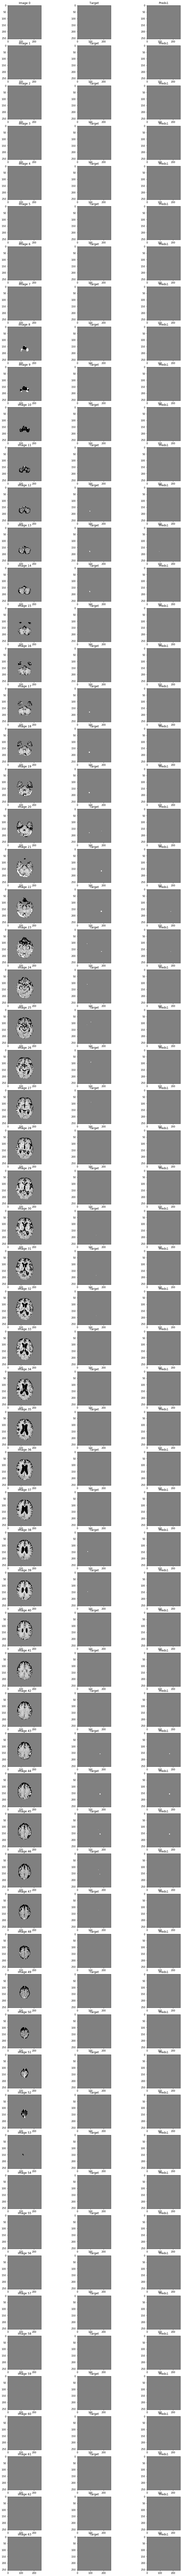

In [11]:
IMG_SET = 52
brainimgs = test_ds.__getitem__(IMG_SET)
plt.figure(figsize=(15, 200))
c = 1
for i in range(0,64):
    plt.subplot(64, 3, c)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Image ' + str(i))
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_masks[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Target')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_preds1[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds1')
    c = c + 1 

In [14]:
w = FloatSlider(value=32,min=0,max=63,step=1,description='Slice:')

def InteractiveReview(z):
    fig = px.imshow(test_preds1[IMG_SET][int(z)], color_continuous_scale='gray', zmin=0, zmax=0.1)
    fig.update_layout(height=400, width=600)
    fig.show()

In [15]:
interactive(InteractiveReview, z=w)

interactive(children=(FloatSlider(value=32.0, description='Slice:', max=63.0, step=1.0), Output()), _dom_class…

# 2mets model predictions

In [10]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200124_first_tx_2mets_b9');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [11]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds2, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

# 3mets model predictions

In [12]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200126_first_tx_3mets_b9');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [13]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds3, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

# 4-5mets model predictions

In [14]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200126_first_tx_4-5mets_b9_2');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [15]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds4_5, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

# 6-10mets model predictions

In [16]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200126_first_tx_6-10mets_b9_2');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [17]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds6_10, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

# 11+mets model predictions

In [18]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200126_first_tx_11+mets_b9');
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [19]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds11, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

# Save predictions

In [20]:
predictions = np.zeros((118,6,64,256,256),dtype=float)
for i in range(0,np.shape(test_preds1)[0]):
    #fn = test_img[i].stem + '.npy'
    #print(fn)
    predictions[i][0] = test_preds1[i]
    predictions[i][1] = test_preds2[i]
    predictions[i][2] = test_preds3[i]
    predictions[i][3] = test_preds4_5[i]
    predictions[i][4] = test_preds6_10[i]
    predictions[i][5] = test_preds11[i]
    #print(np.shape(predictions))
    #np.save('/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/predictions/training/' + fn, predictions)

In [22]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
#m = f()

m = VolumetricUnet(in_c=6, out_c=2, n_layers=5, c=1, block_type=conv_relu_bn_drop,
                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
#learn.load('best_of_20200127_first_tx_all_mets_b9_combined_model_2');
learn.load('best_of_20200129_first_tx_enssemble');

In [23]:
data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_all_mets")
data_path2 = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/predictions")

test_img = sorted(list(Path(data_path2/"testing/").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/mets_masks_1x1x3/").iterdir()))

class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

predictions_ds = MR_3D_Dataset(test_img, test_mask)

combined_dl = DeviceDataLoader(DataLoader(predictions_ds, batch_size=bs), device=data.device)

In [24]:

# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_combined, test_masks = get_img_pred_masks(learn, combined_dl)

# Combine masks

In [55]:
# total_preds = np.zeros((118,64,256,256), dtype=float)
# for i in range(0,118):
#     total_preds[i] = np.sum([test_preds1[i], test_preds2[i], test_preds3[i], test_preds4_5[i], test_preds6_10[i], test_preds11[i]], axis=0)

In [59]:
# combined_preds = np.zeros((118,64,256,256), dtype=float)
# combined_preds[total_preds==6] = 1
#combined_preds[test_preds4_5==1 and test_preds6_10==1 and test_preds11==1] = 1
# combined_preds[total_preds > 2] = 1


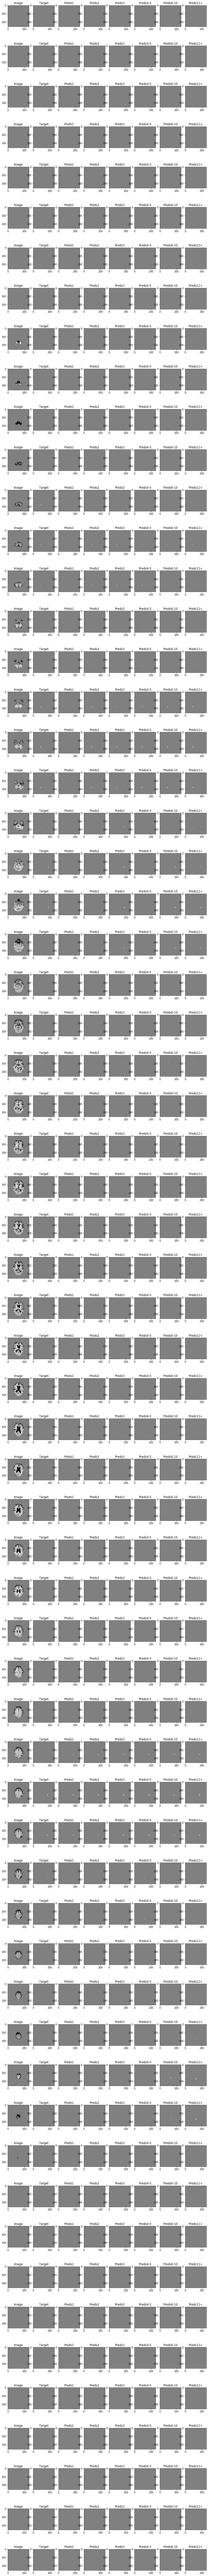

In [54]:
IMG_SET = 52
brainimgs = test_ds.__getitem__(IMG_SET)
plt.figure(figsize=(15, 200))
c = 1
for i in range(0,64):
    plt.subplot(64, 8, c)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Image')
    c = c + 1
    plt.subplot(64, 8, c)
    plt.imshow(test_masks[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Target')
    c = c + 1
    plt.subplot(64, 8, c)
    plt.imshow(test_preds1[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds1')
    c = c + 1 
    plt.subplot(64, 8, c)
    plt.imshow(test_preds2[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds2')
    c = c + 1
    plt.subplot(64, 8, c)
    plt.imshow(test_preds3[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds3')
    c = c + 1
    plt.subplot(64, 8, c)
    plt.imshow(test_preds4_5[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds4-5')
    c = c + 1 
    plt.subplot(64, 8, c)
    plt.imshow(test_preds6_10[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds6-10')
    c = c + 1
    plt.subplot(64, 8, c)
    plt.imshow(test_preds11[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Preds11+')
    c = c + 1 

In [80]:
w = FloatSlider(value=32,min=0,max=63,step=1,description='Slice:')

def InteractiveReview(z):
    fig = px.imshow(t[int(z)], color_continuous_scale='gray', zmin=0, zmax=5)
    fig.update_layout(height=400, width=600)
    fig.show()

In [81]:
interactive(InteractiveReview, z=w)

interactive(children=(FloatSlider(value=32.0, description='Slice:', max=63.0, step=1.0), Output()), _dom_class…

# Generate table and figures, review testing set

In [25]:
def summary_table(target_masks, pred_masks, file_names):
    pred_dice_scores = [dice_score(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    pred_percent_vol_diff = [vol_perc_diff(target_masks[i], pred_masks[i], True)*100 for i in range(len(target_masks))]
    TPs = [true_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    FPs = [false_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    target_mets = [label(target_masks[i]) for i in range(len(target_masks))]
    pred_mets = [label(pred_masks[i]) for i in range(len(target_masks))]
    target_num = [target_mets[i][1] for i in range(len(target_masks))] 
    pred_num = [pred_mets[i][1] for i in range(len(target_masks))] 
    d = {'test_name': file_names,
         'pred_dice_scores': pred_dice_scores, 
         'pred_percent_vol_diff': pred_percent_vol_diff,
         'target_mets': target_num,
         'pred_mets': pred_num,
         'true_positive': TPs,
         'false_positive': FPs}
    df = pd.DataFrame(data=d)
    return df

def met_volume(image,res):
    numMets = np.amax(image)# max number
    metNum, counts = np.unique(image.flatten(), return_counts=True)
    return np.asarray(counts[1:]*res)

def vol_perc_diff(mask, pred, absolute=False):
    #mask_vol = (((mask.numpy()).sum()).sum()).sum()
    #pred_vol = (((pred.numpy()).sum()).sum()).sum()
    mask_vol = ((mask.sum()).sum()).sum()
    pred_vol = ((pred.sum()).sum()).sum()
    if not absolute:
        return (pred_vol-mask_vol)/mask_vol
    return abs(pred_vol-mask_vol)/mask_vol

def dice_score(target, preds, thresh=0.5):
    iT = target#.numpy()
    iP = preds#.numpy()
    intersection = (((iT * iP).sum()).sum()).sum()
    return ((2.0 * intersection) / (((iT.sum()).sum()).sum() + ((iP.sum()).sum()).sum() + 1e-6))

# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
def true_positive(true_labels, pred_labels):
    TP = np.logical_and(pred_labels == 1., true_labels == 1.).sum().sum().sum()
    return TP

# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
def true_negative(true_labels, pred_labels):
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    return TN

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
def false_positive(true_labels, pred_labels):
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    return FP


In [26]:
names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_all_mets/")
test1_img_files = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(test_masks, test_combined, names)
df.describe()

pred_dice_scores  pred_percent_vol_diff  target_mets   pred_mets  \
count        118.000000             118.000000   118.000000  118.000000   
mean           0.764918              33.969345     4.584746   12.177966   
std            0.172632              76.326202     4.451690    9.931071   
min            0.000000               0.014311     1.000000    1.000000   
25%            0.697569               4.449683     2.000000    5.000000   
50%            0.824261              13.140306     3.000000   10.000000   
75%            0.887843              31.423836     6.000000   16.000000   
max            0.964044             552.091480    25.000000   52.000000   

       true_positive  false_positive  
count     118.000000      118.000000  
mean     1917.635593      519.093220  
std      1790.822356      981.429552  
min         0.000000        0.000000  
25%       702.000000       68.250000  
50%      1338.000000      176.500000  
75%      2669.250000      432.500000  
max      8951.000000     5943.000000

In [ ]:
df[df['pred_dice_scores'] > 0.3].describe()

In [53]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

test_name  pred_dice_scores  pred_percent_vol_diff  \
0    BrainMets-UCSF-00001          0.522487               7.392566   
1    BrainMets-UCSF-00012          0.236878              50.290400   
2    BrainMets-UCSF-00014          0.615385              63.903904   
3    BrainMets-UCSF-00016          0.866349             152.387097   
4    BrainMets-UCSF-00025          0.487099             218.157895   
5    BrainMets-UCSF-00072          0.585098              26.061288   
6    BrainMets-UCSF-00104          0.548776              33.433570   
7    BrainMets-UCSF-00123          0.162884             219.339985   
8    BrainMets-UCSF-00154          1.021295              61.253161   
9    BrainMets-UCSF-00157          0.496656              54.597049   
10   BrainMets-UCSF-00161          0.453634              15.874481   
11   BrainMets-UCSF-00165          0.253210              14.340898   
12   BrainMets-UCSF-00169          0.164377              14.989059   
13   BrainMets-UCSF-00195          1.159509             251.128915   
14   BrainMets-UCSF-00219          0.384925              41.161422   
15   BrainMets-UCSF-00220          0.757677             217.865315   
16   BrainMets-UCSF-00224          0.575221               2.625680   
17   BrainMets-UCSF-00308          1.043832              65.741981   
18   BrainMets-UCSF-00328          0.978181             123.990126   
19   BrainMets-UCSF-00349          0.549440              53.580763   
20   BrainMets-UCSF-00379          0.374023              85.248714   
21   BrainMets-UCSF-00405          0.713051               5.510018   
22   BrainMets-UCSF-00428          0.270740             119.075630   
23   BrainMets-UCSF-00466          0.809524              70.017534   
24   BrainMets-UCSF-00515          0.365169            2142.105263   
25   BrainMets-UCSF-00534          0.967620             154.370238   
26   BrainMets-UCSF-00558          0.507232             681.770443   
27   BrainMets-UCSF-00589          0.125556              12.695109   
28   BrainMets-UCSF-00632          0.391348              12.620321   
29   BrainMets-UCSF-00643          0.851613             490.068493   
30   BrainMets-UCSF-00670          0.733561              90.648743   
31   BrainMets-UCSF-00674          0.225417               4.347826   
32   BrainMets-UCSF-00699          0.528736               8.740360   
33   BrainMets-UCSF-00726          0.475000              32.804233   
34   BrainMets-UCSF-00745          0.434548              91.445428   
35   BrainMets-UCSF-00764          0.656633              62.988348   
36   BrainMets-UCSF-00780          1.027707              64.215765   
37   BrainMets-UCSF-00787          0.326288             185.241730   
38   BrainMets-UCSF-00811          0.215633             104.098361   
39   BrainMets-UCSF-00841          0.356475              58.304961   
40   BrainMets-UCSF-00867          0.489491               1.428207   
41   BrainMets-UCSF-00871          0.133225             234.982332   
42   BrainMets-UCSF-00876          0.324339               2.260198   
43   BrainMets-UCSF-00879          0.443500               3.148807   
44   BrainMets-UCSF-00880          0.100698            3258.620690   
45   BrainMets-UCSF-00887          0.134715            1698.360656   
46   BrainMets-UCSF-00891          0.157333            1117.073171   
47   BrainMets-UCSF-00899          0.818753              81.496599   
48   BrainMets-UCSF-00901          0.980000             268.227425   
49   BrainMets-UCSF-00902          0.569544              33.959311   
50   BrainMets-UCSF-00908          0.234064             415.609990   
51   BrainMets-UCSF-00919          0.497744             407.305936   
52   BrainMets-UCSF-00925          0.986729             312.400000   
53   BrainMets-UCSF-00957          0.732824              43.607624   
54   BrainMets-UCSF-00969          0.706131              79.261993   
55   BrainMets-UCSF-00980          0.541582              17.407407   
56   BrainMets-UCSF-00987 

In [11]:
indexes = df[df['pred_dice_scores']>0.8].index.tolist()
names = df['test_name'].tolist()
len(indexes)
df[df['pred_dice_scores']<0.25]['test_name'].tolist()

['BrainMets-UCSF-01129', 'BrainMets-UCSF-01648']

/usr/local/share/anaconda3/envs/ventricle/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



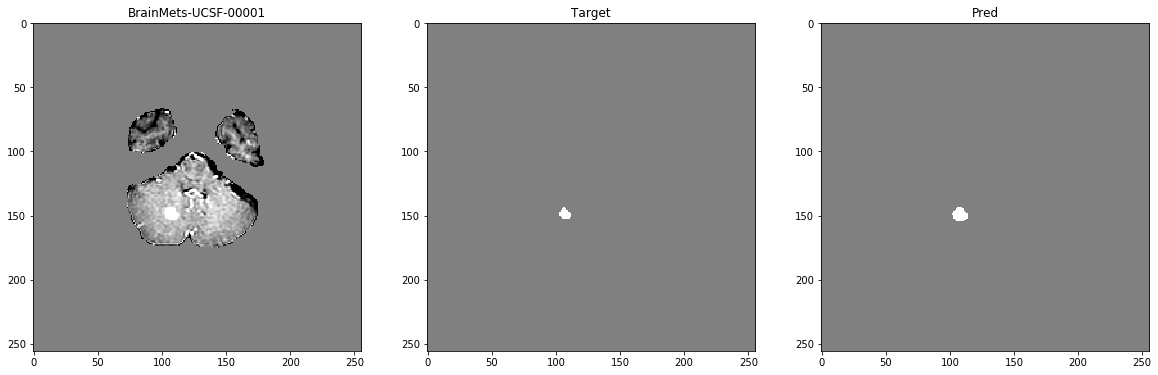

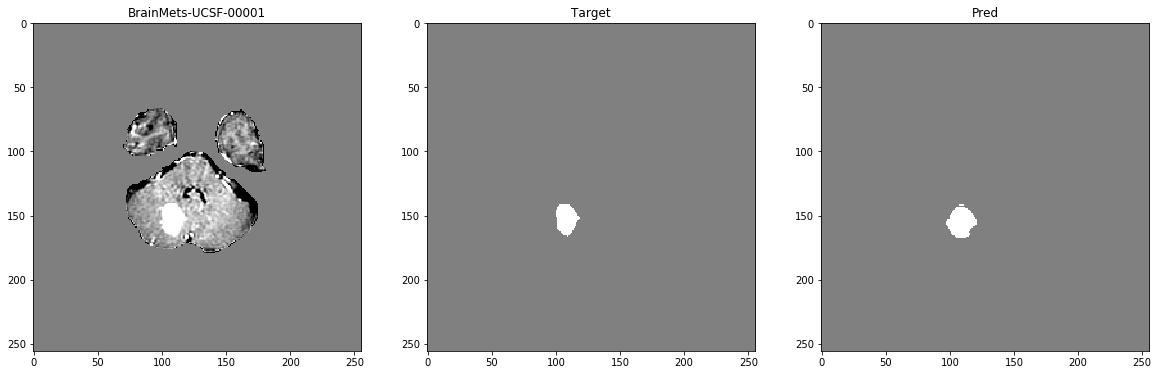

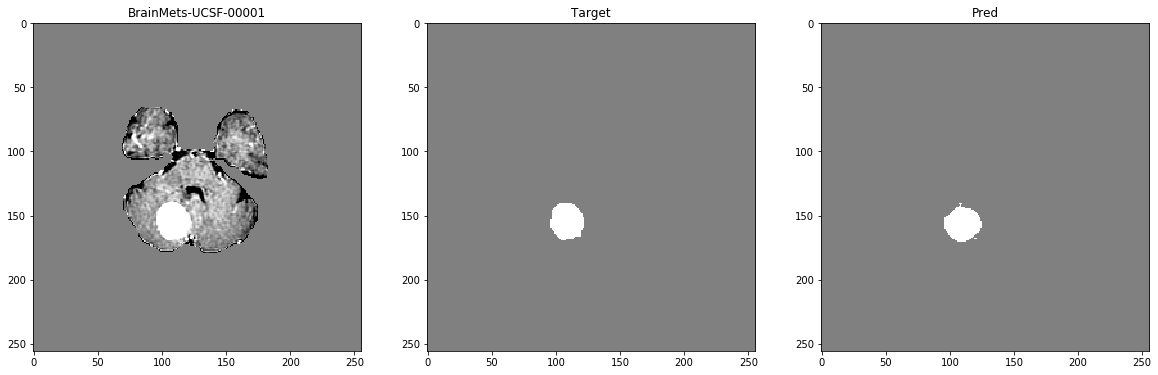

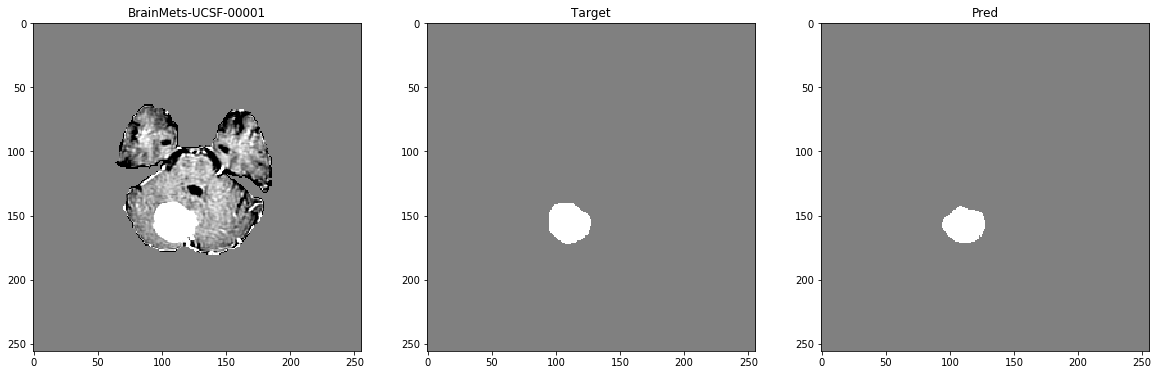

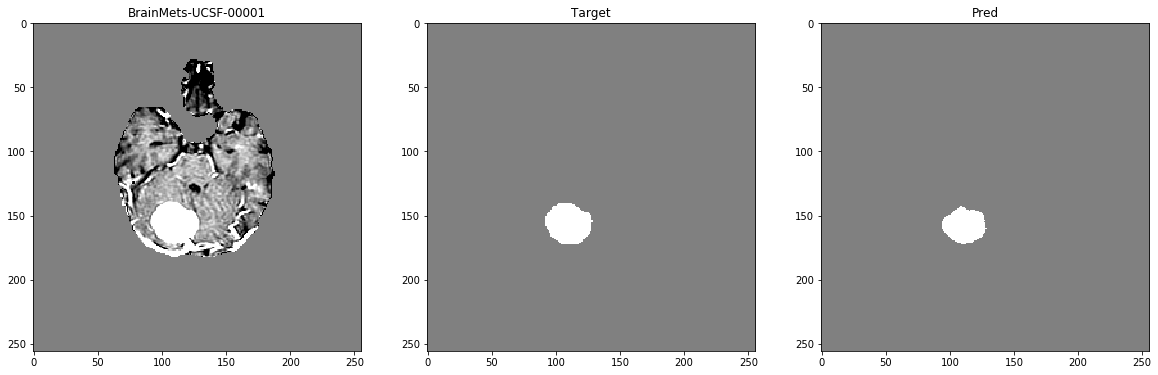

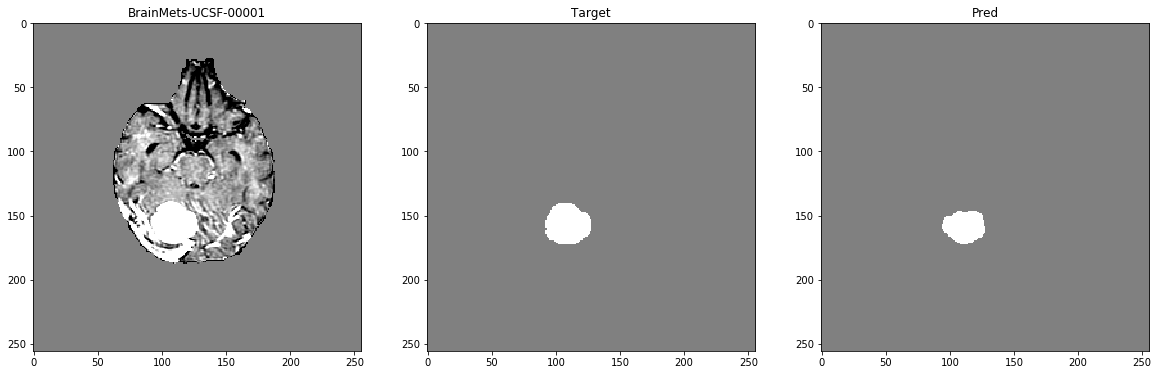

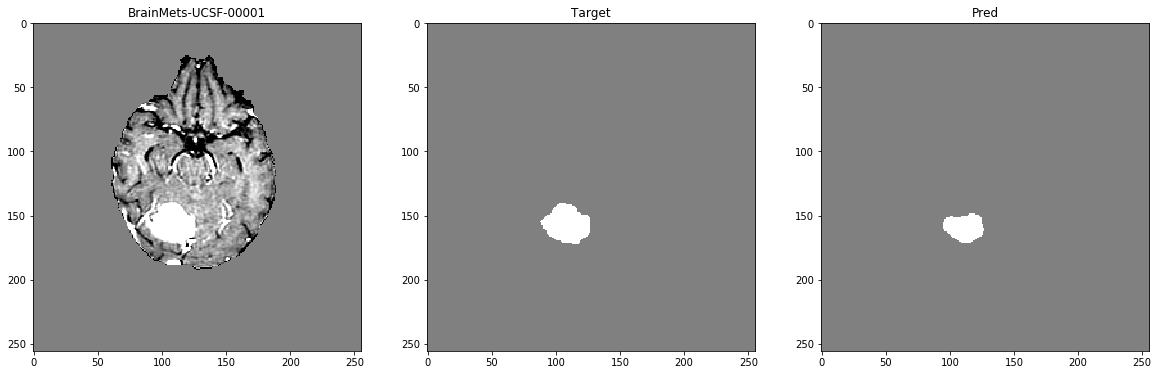

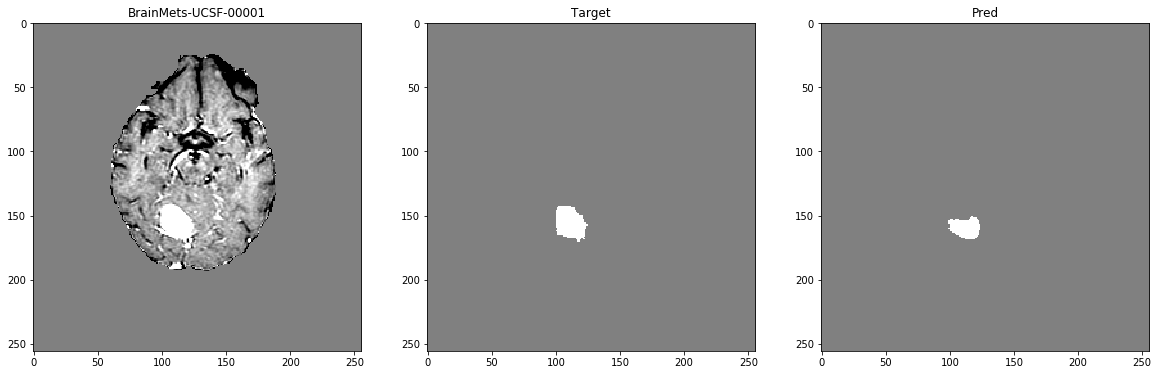

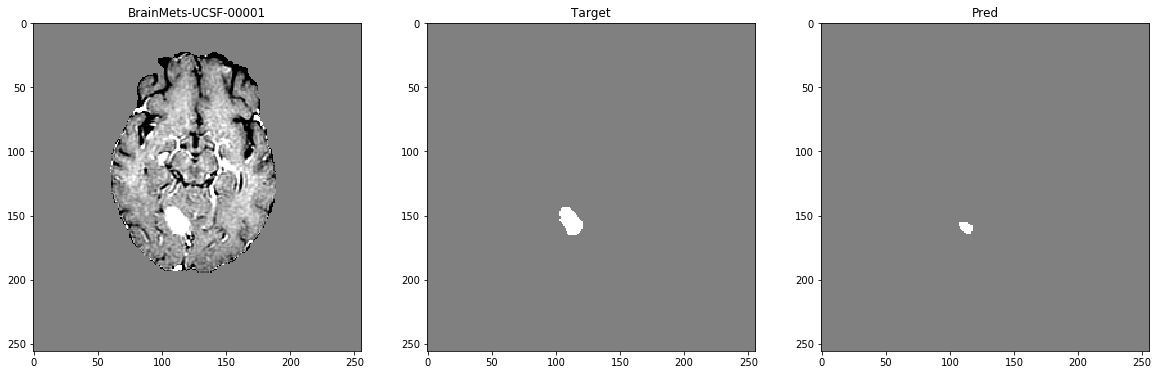

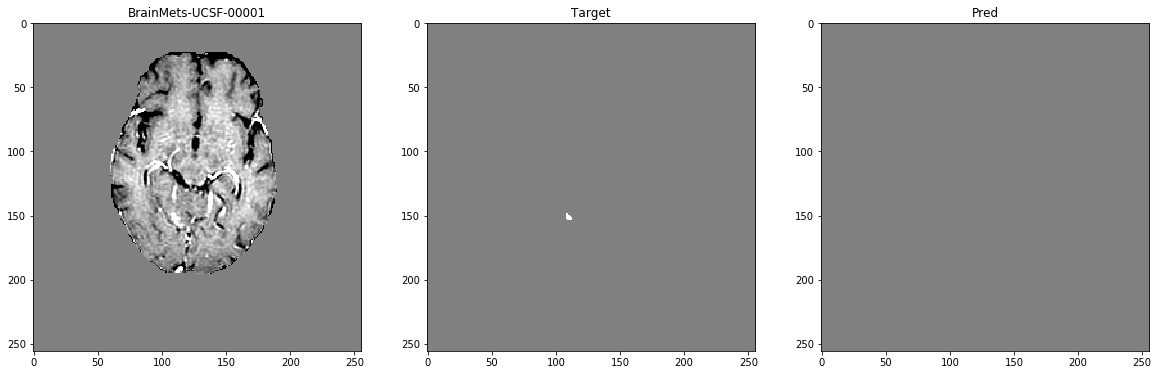

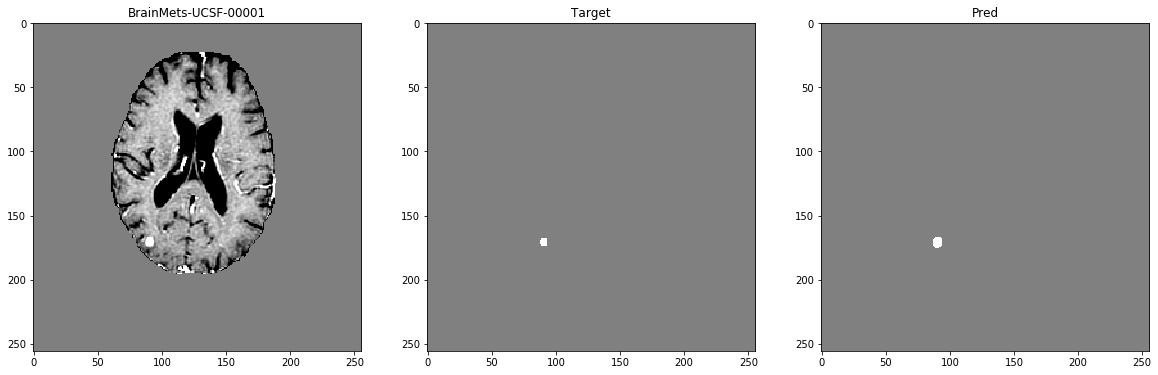

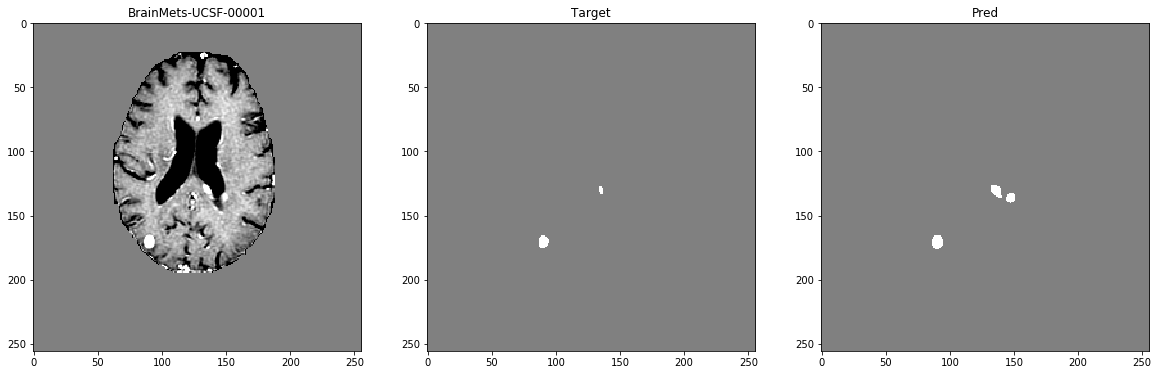

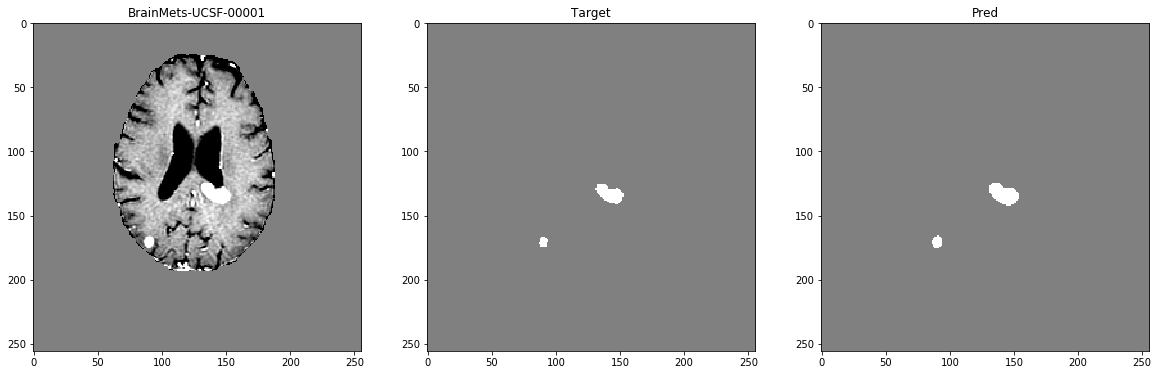

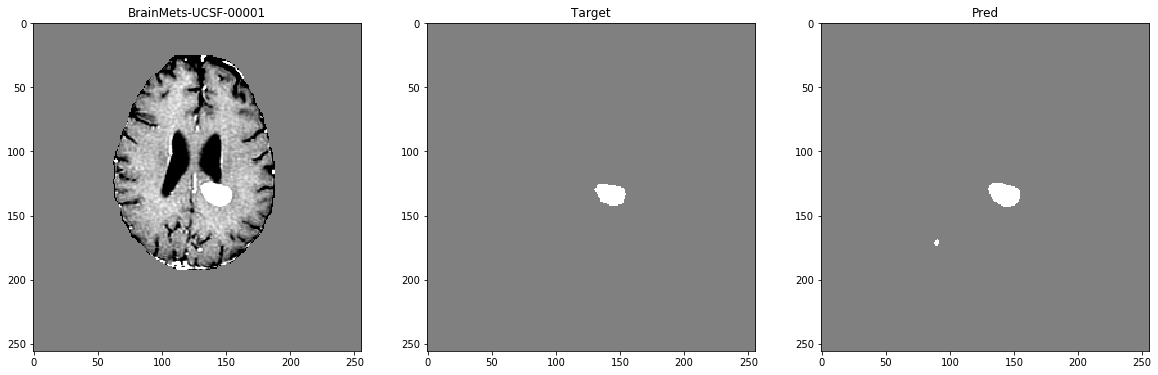

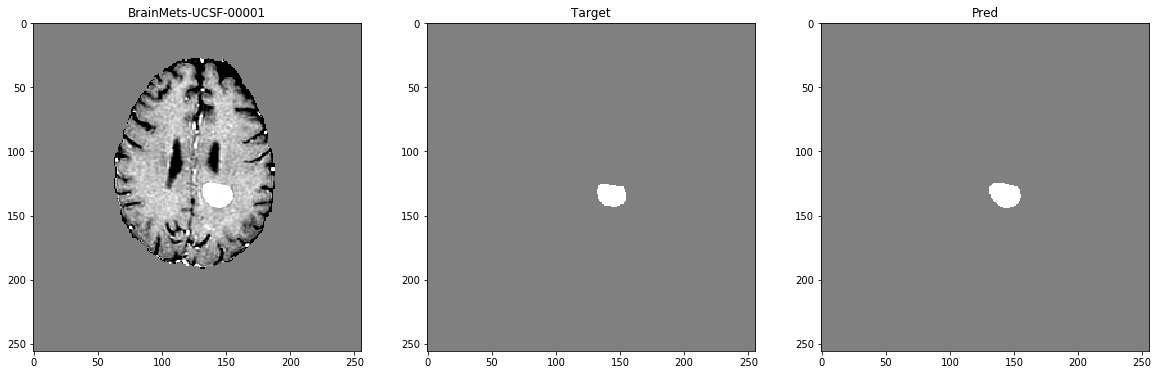

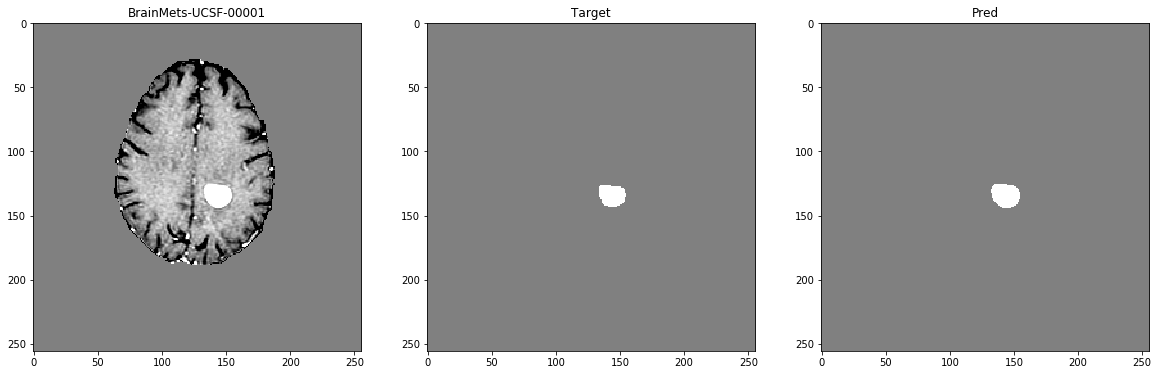

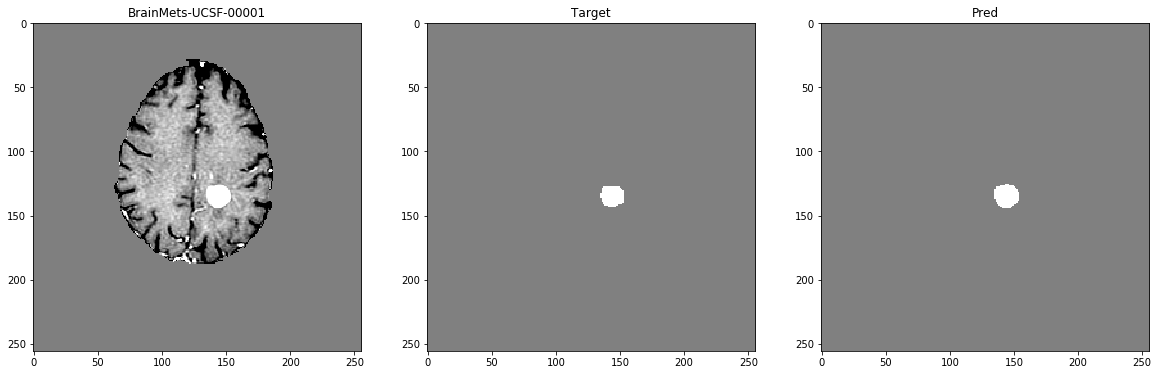

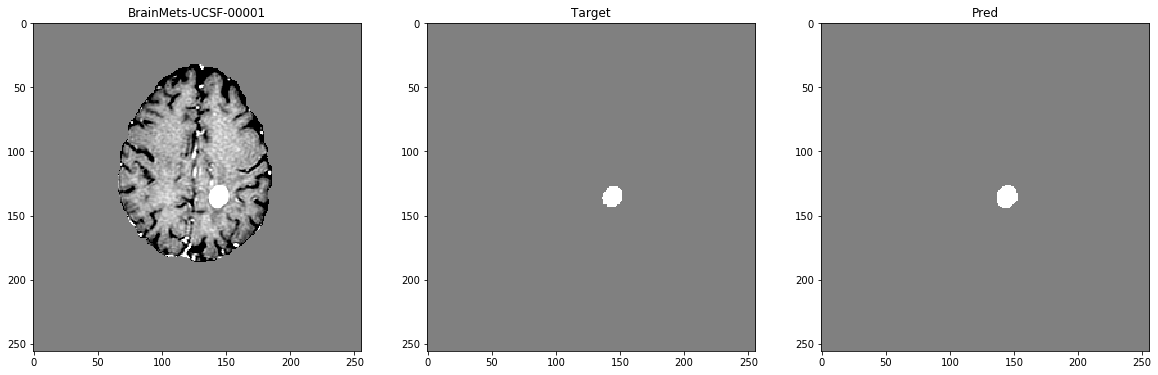

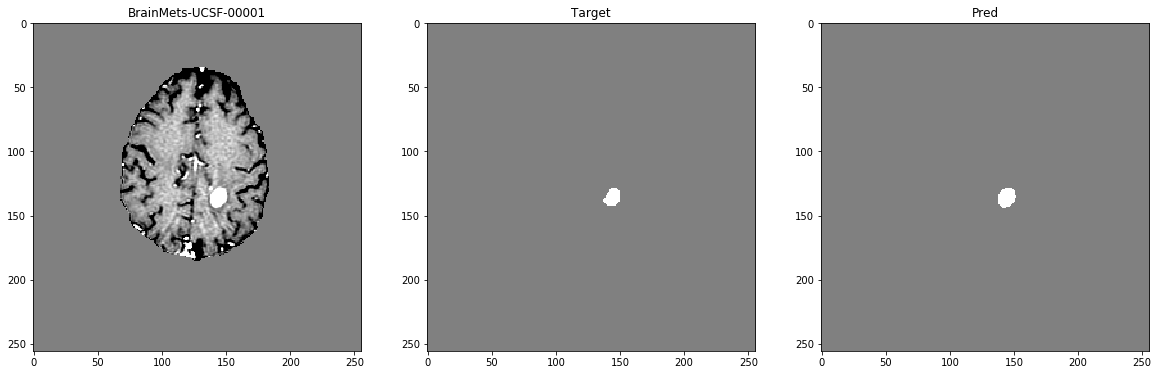

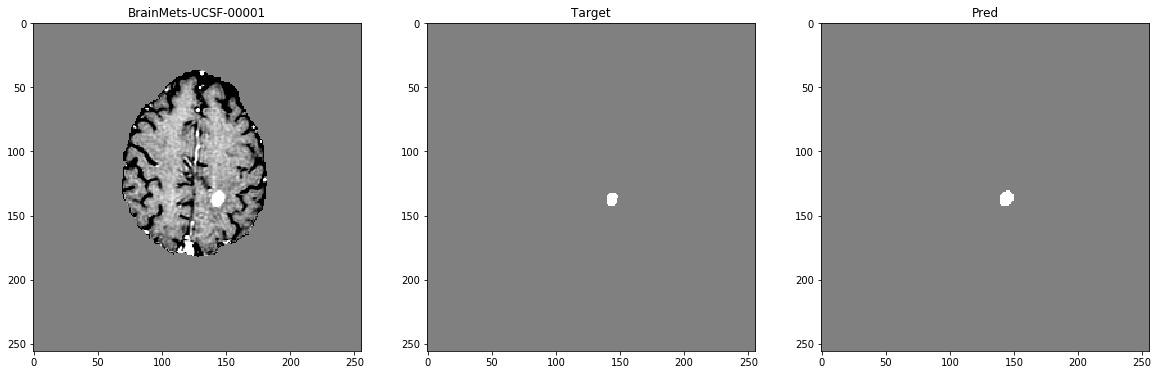

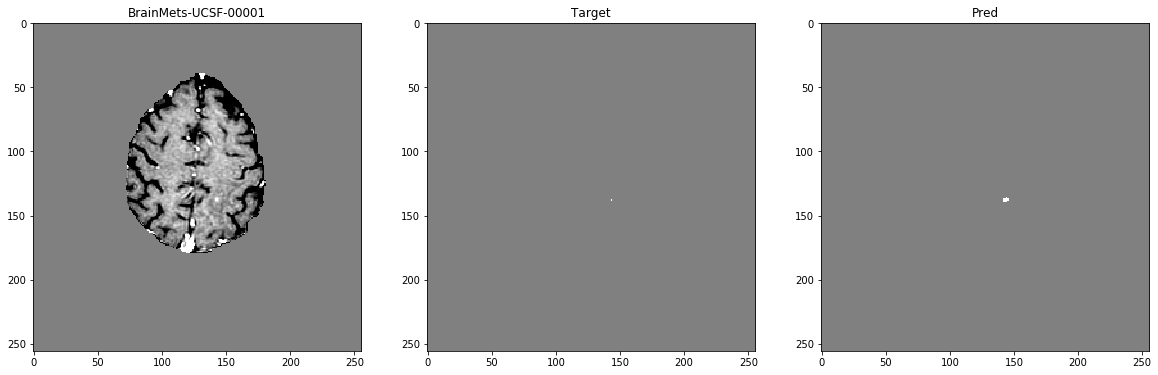

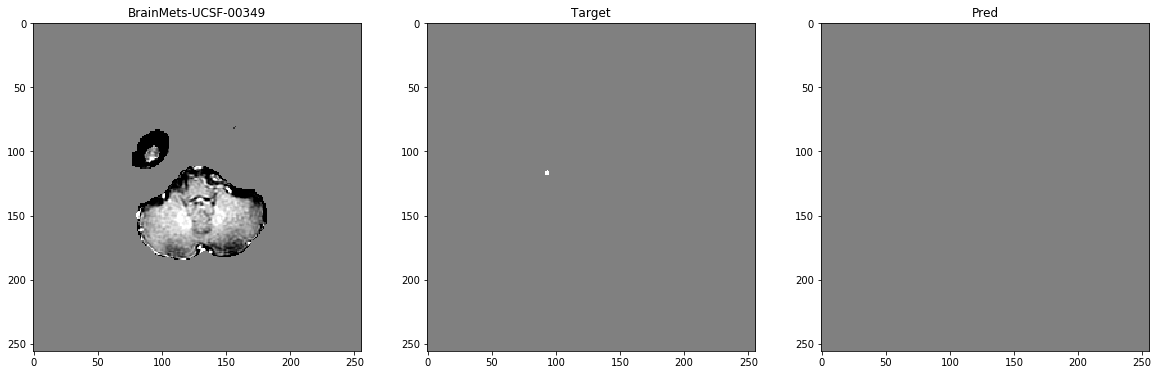

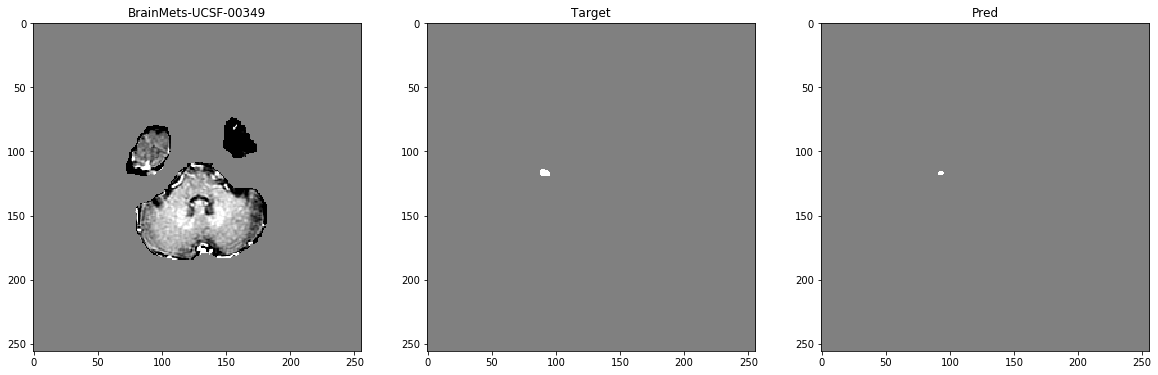

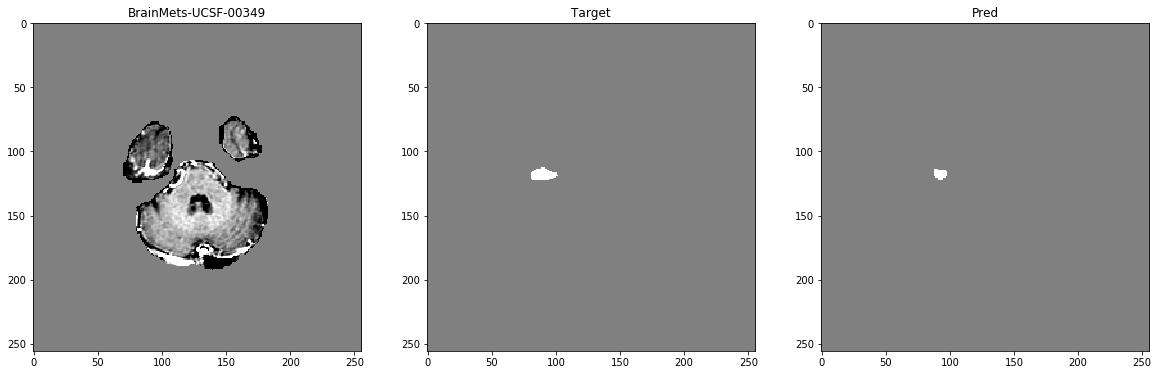

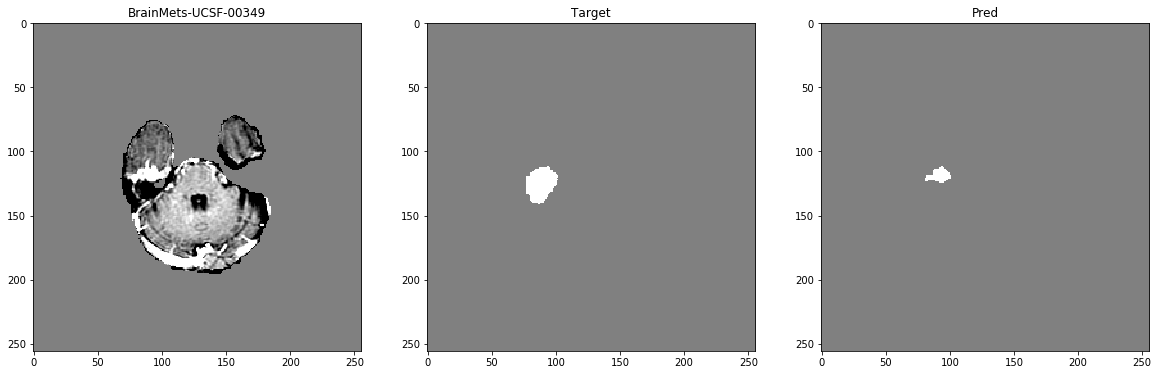

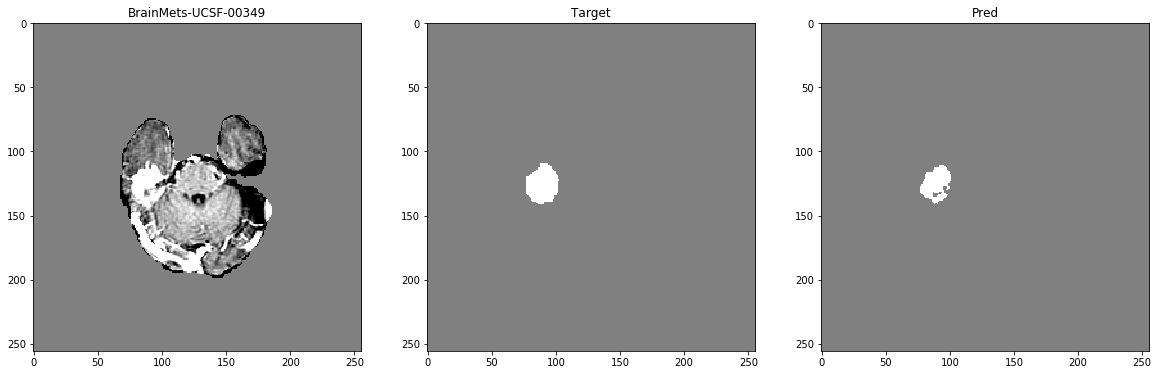

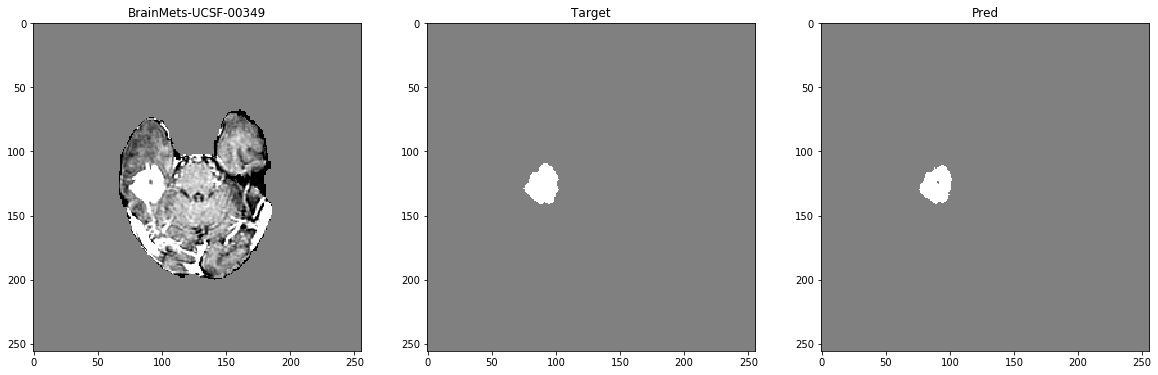

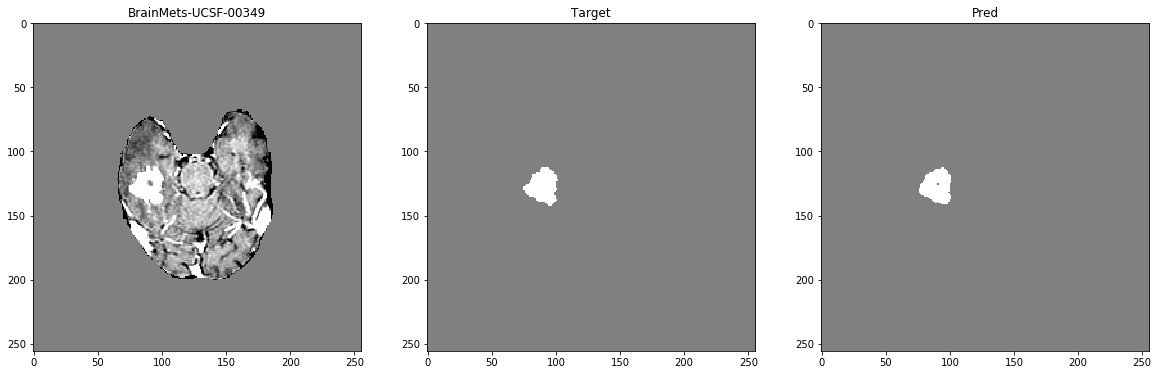

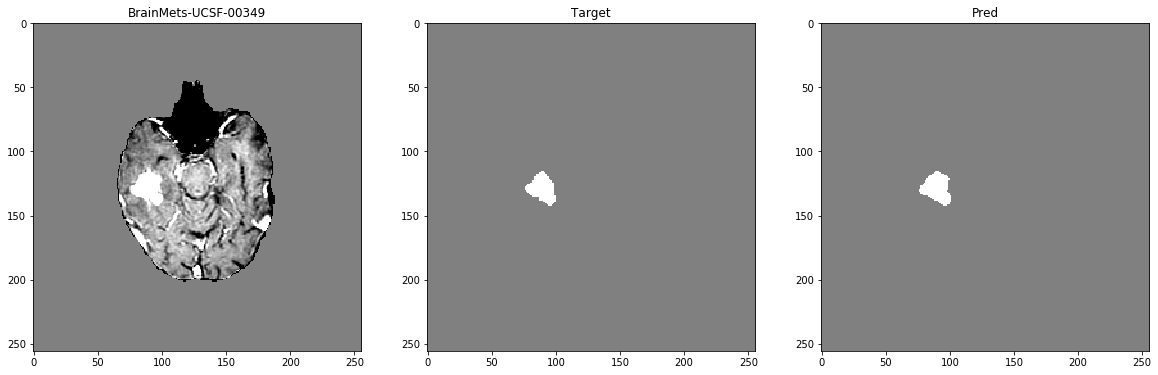

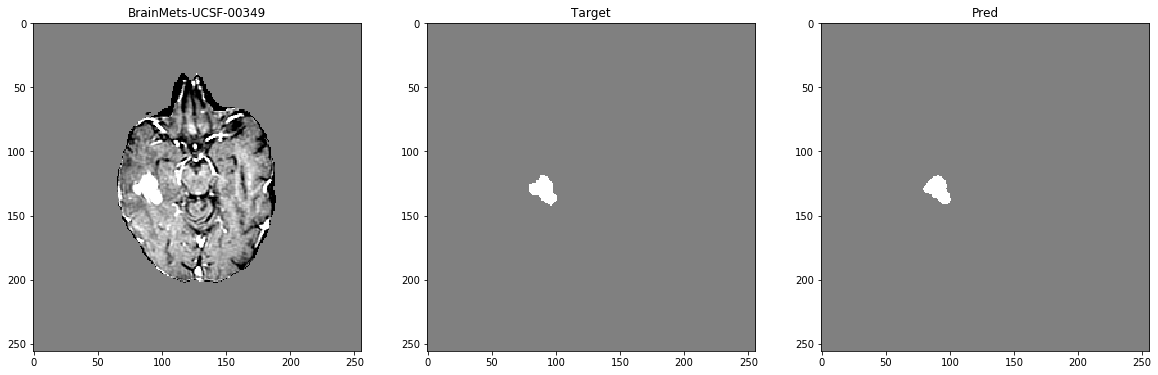

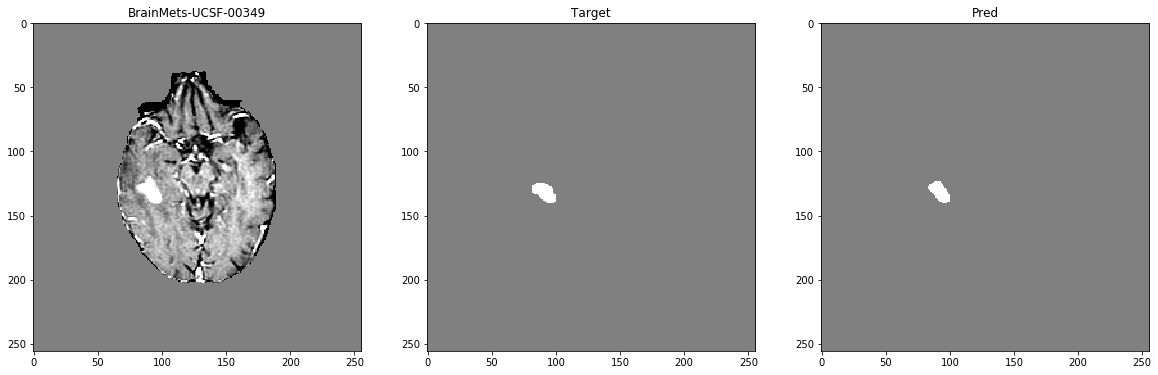

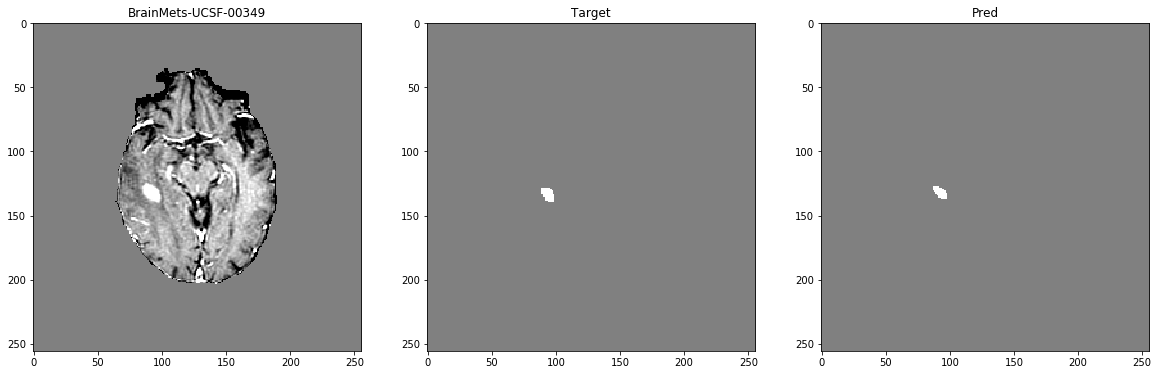

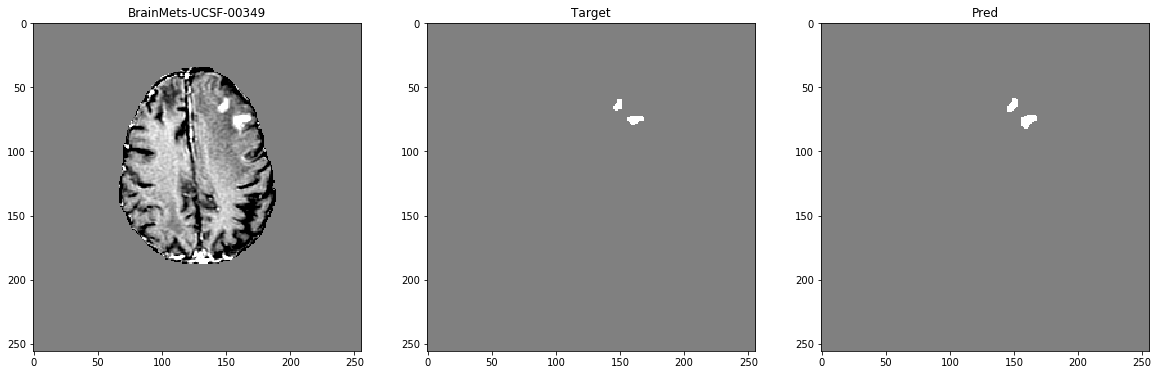

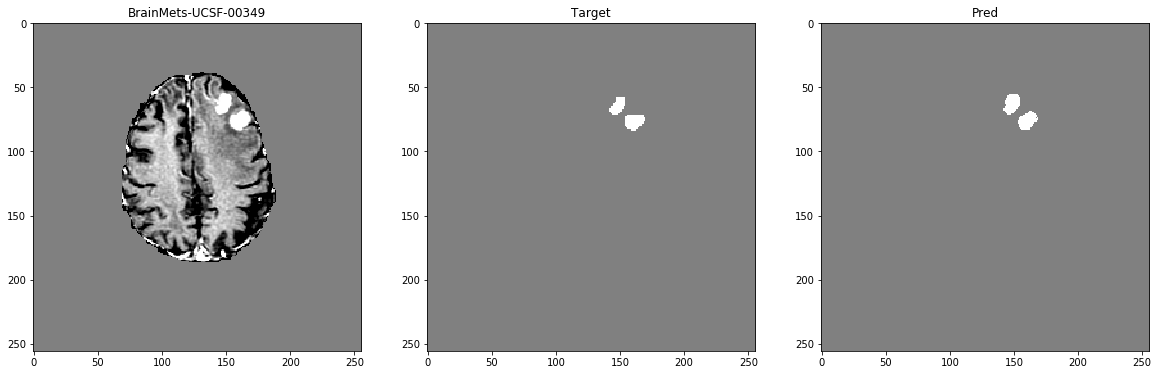

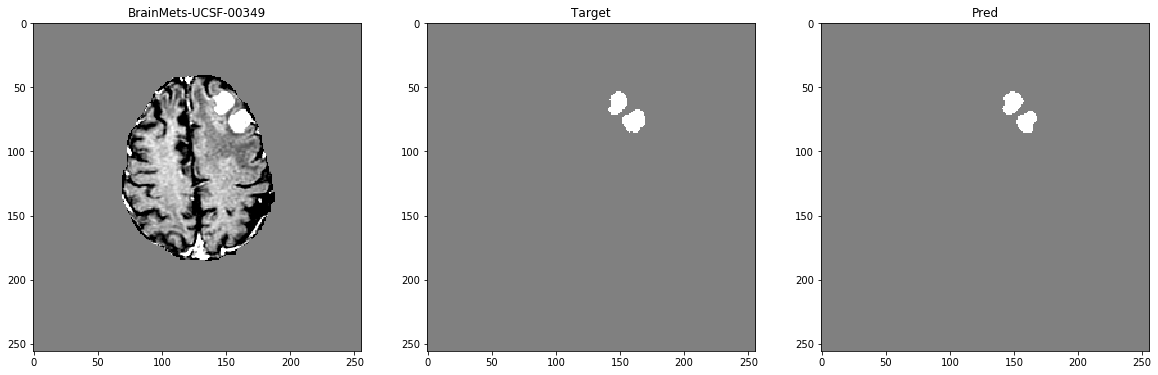

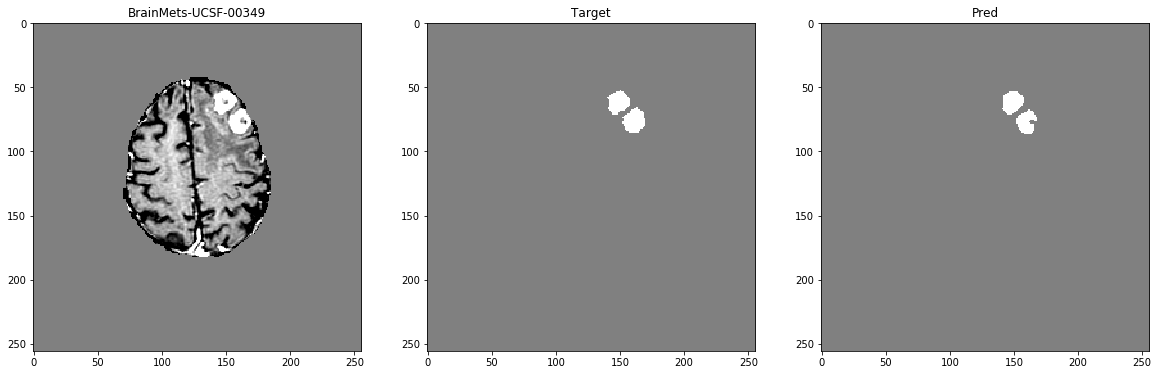

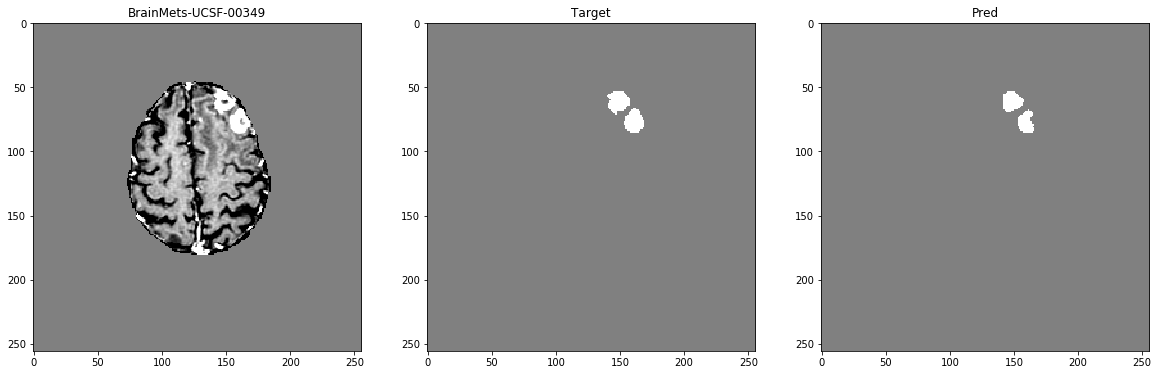

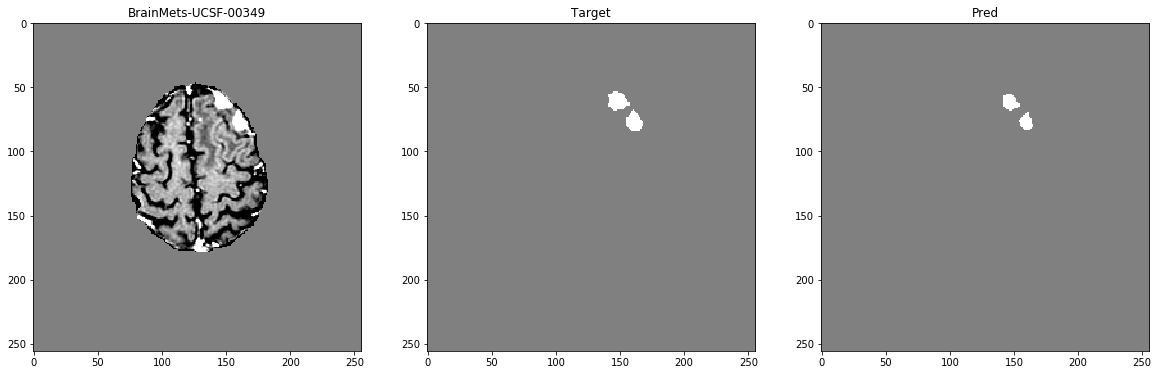

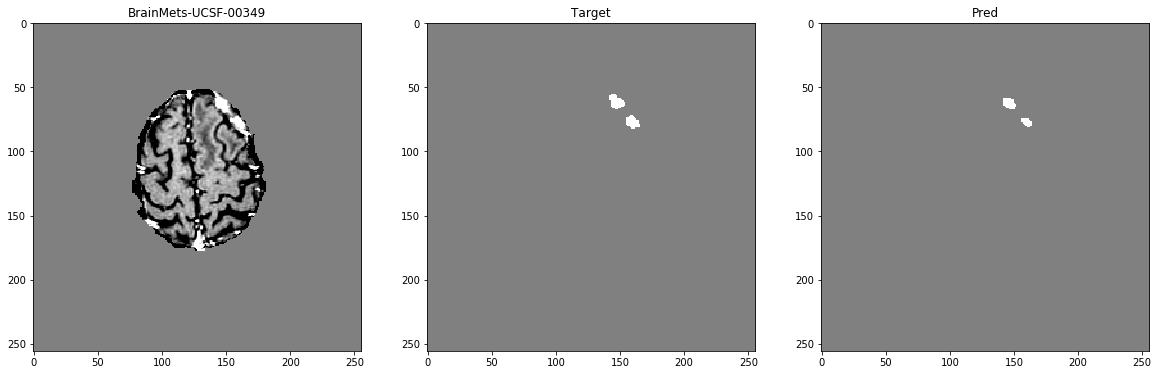

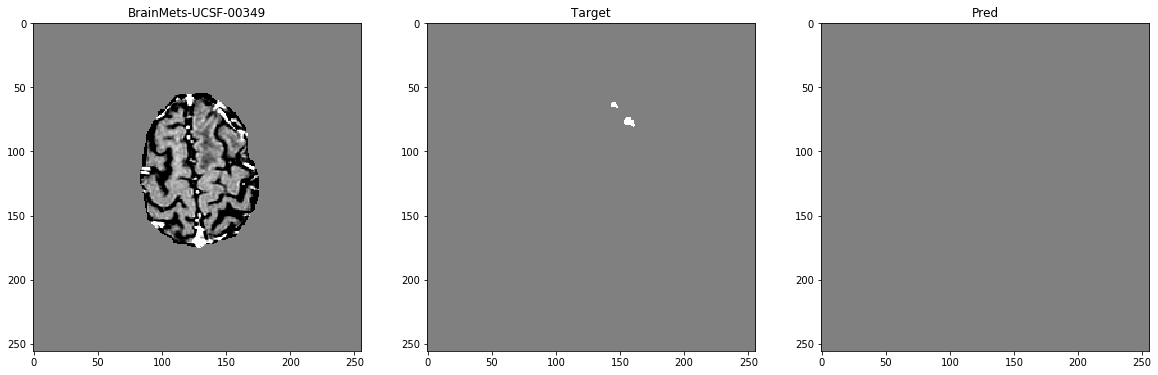

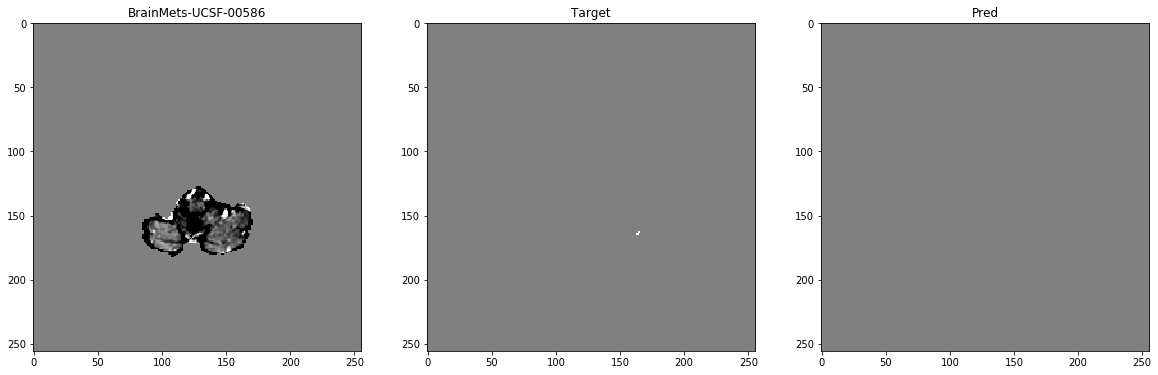

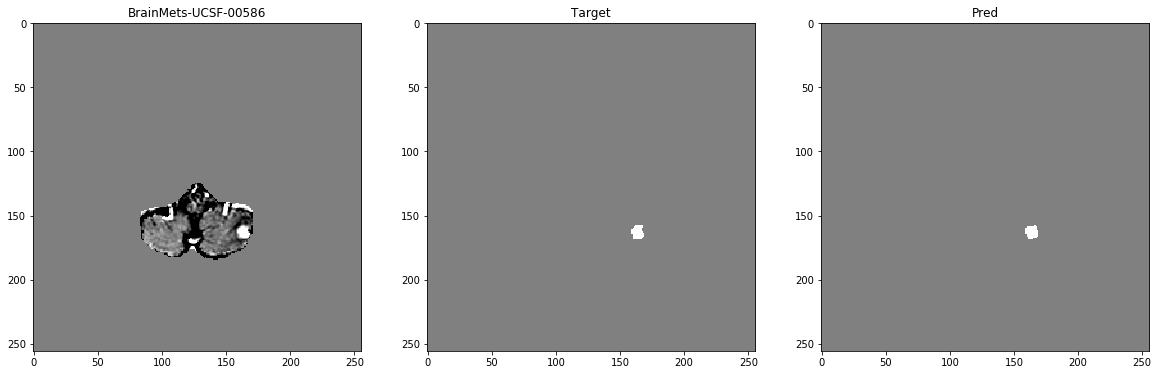

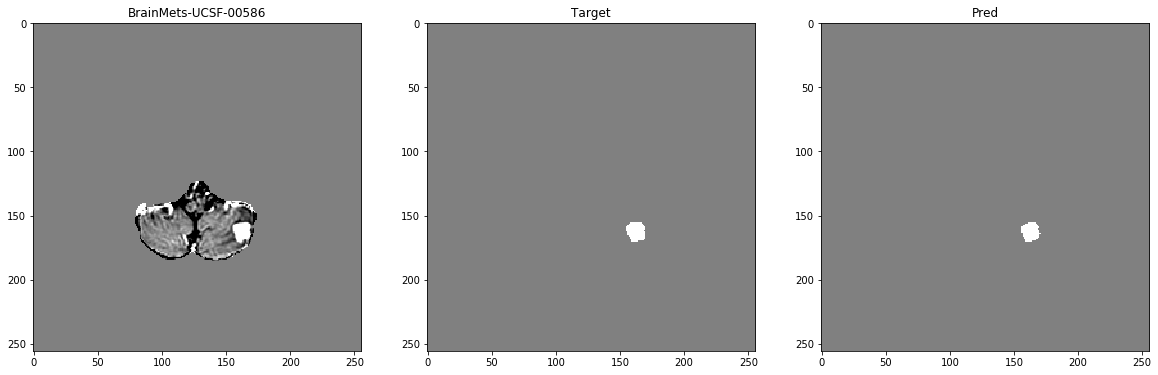

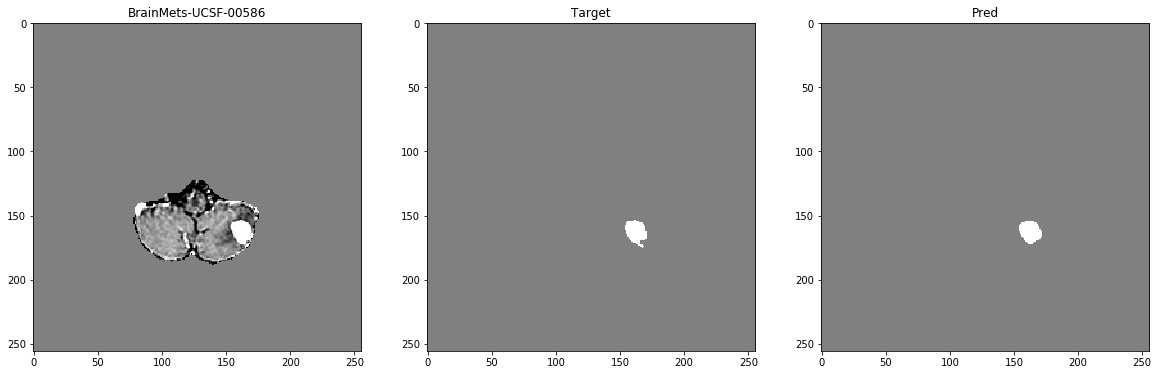

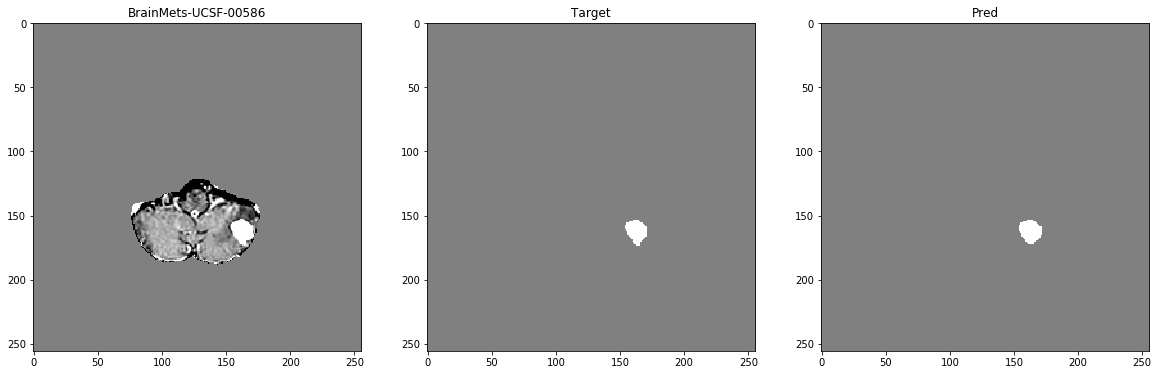

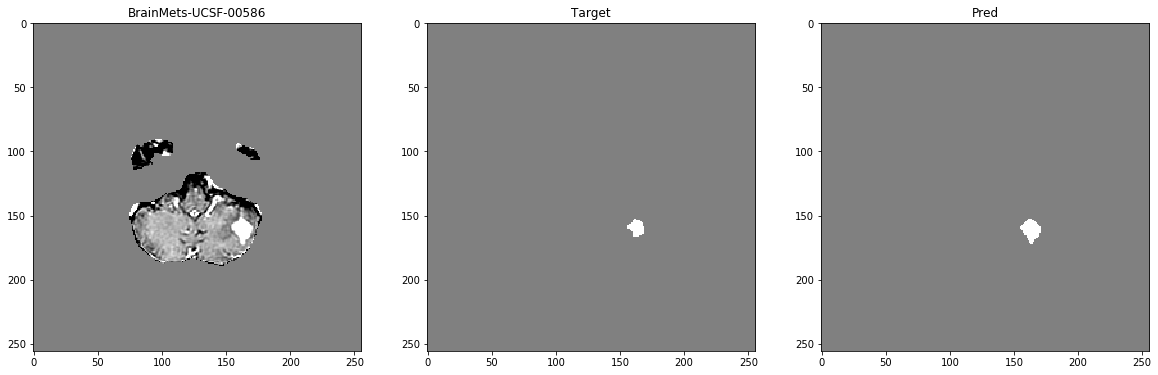

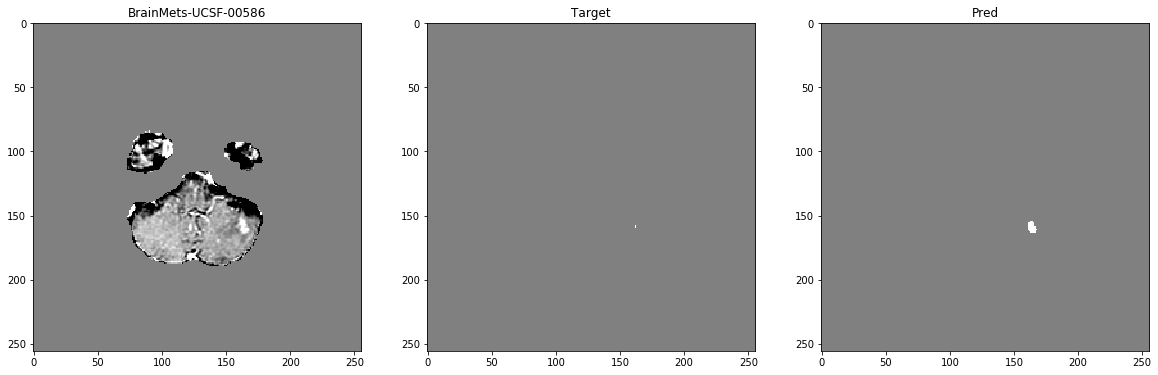

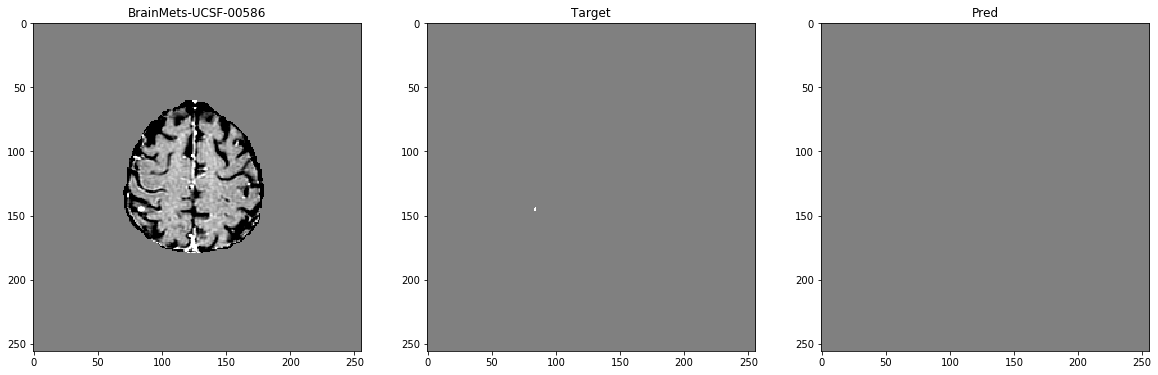

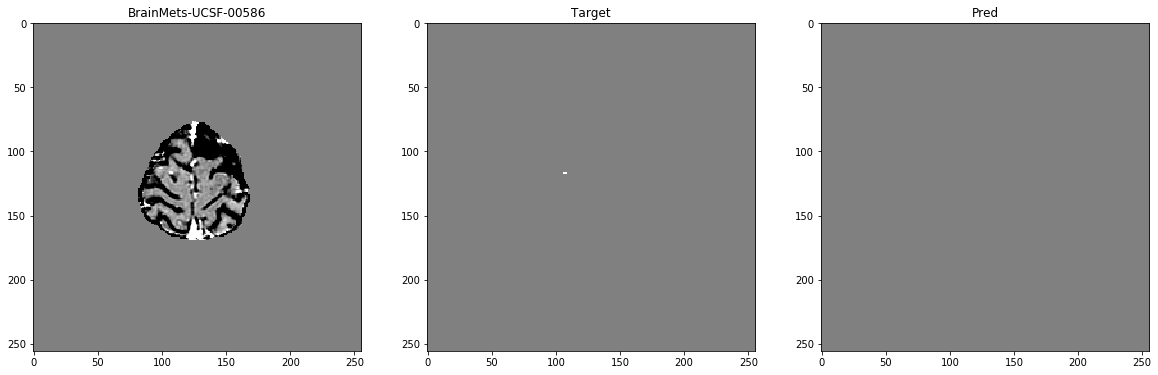

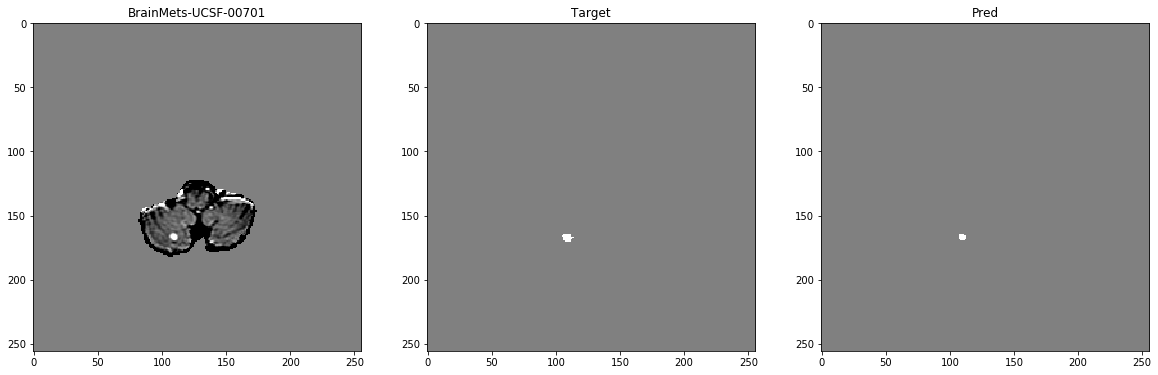

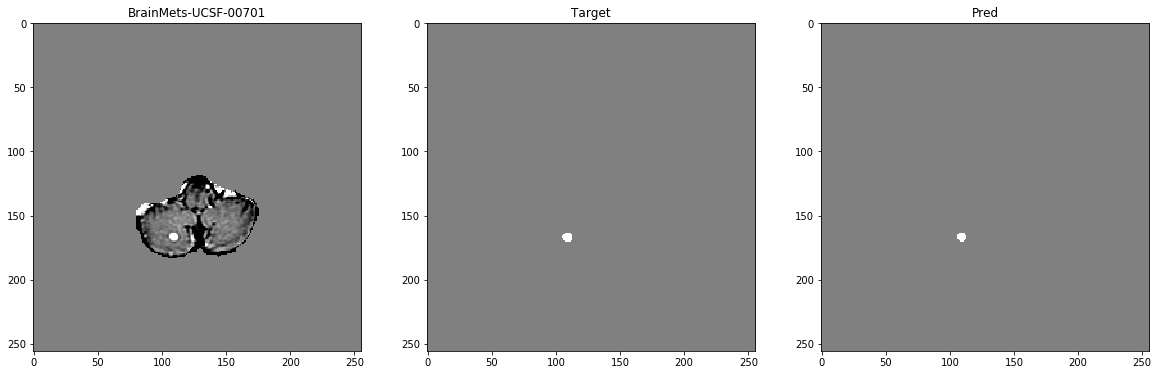

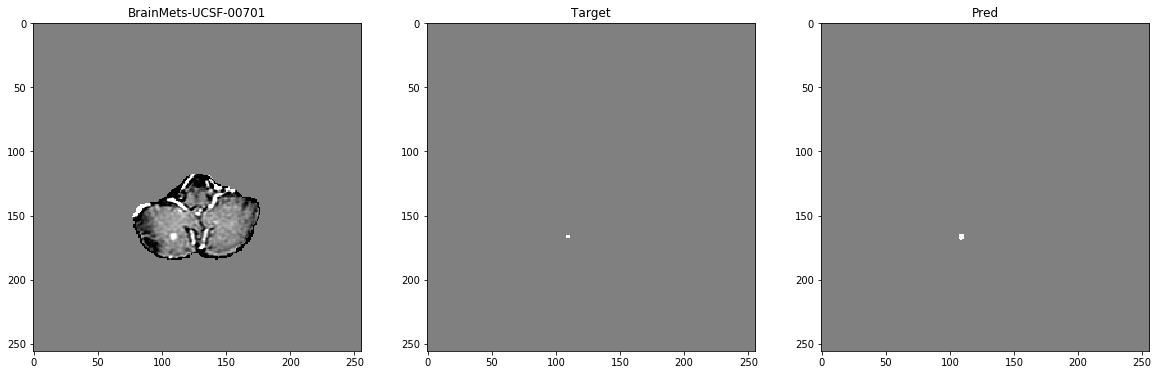

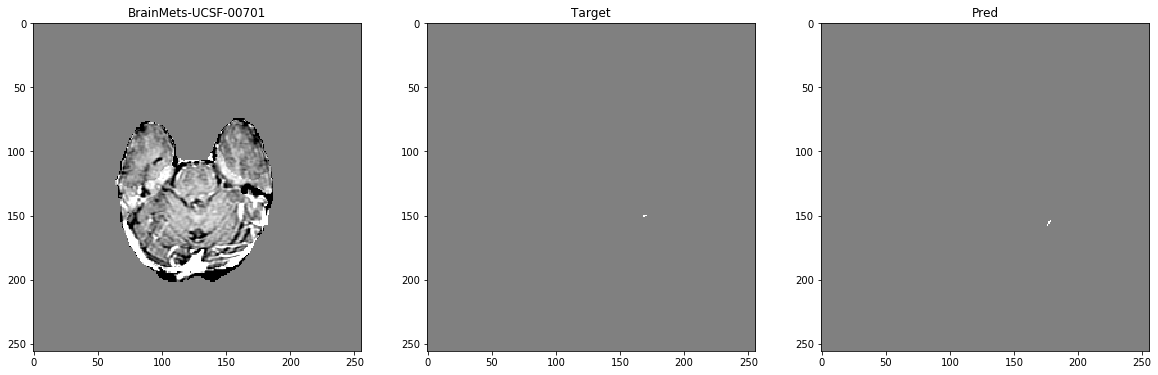

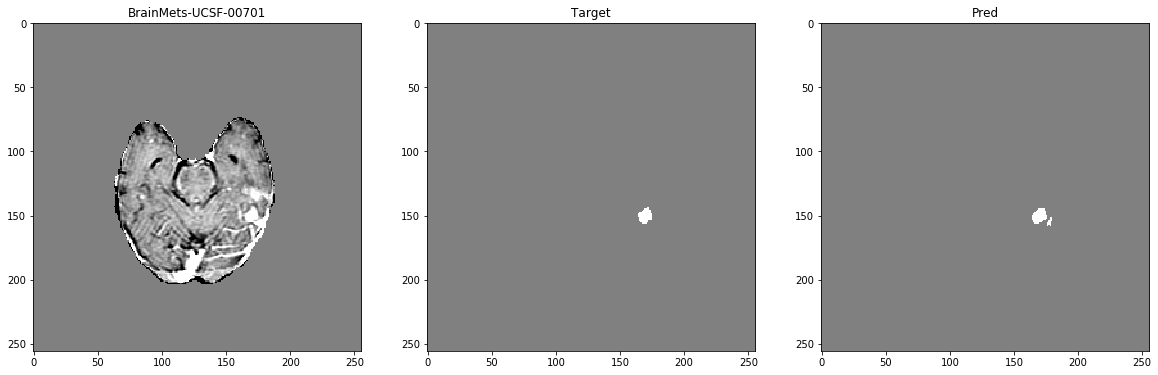

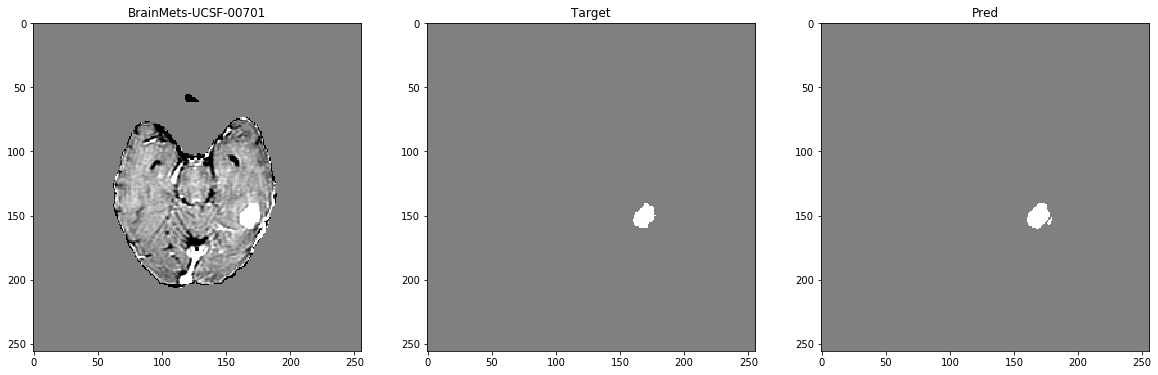

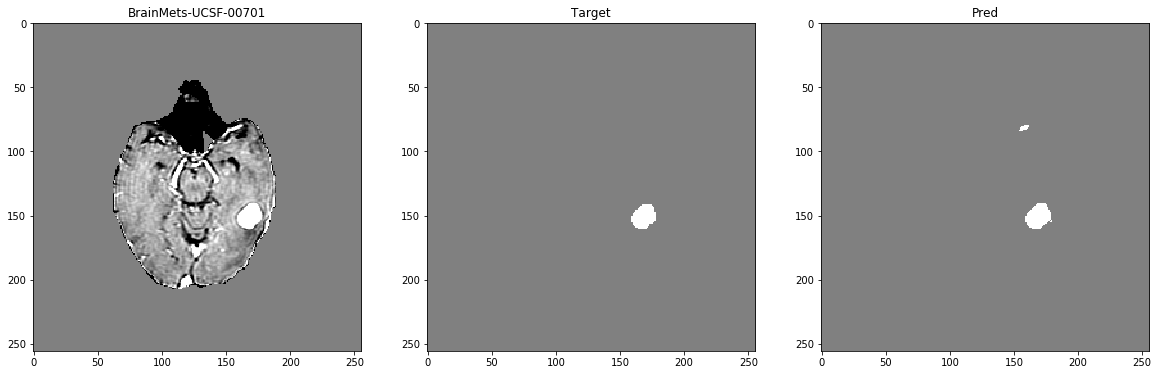

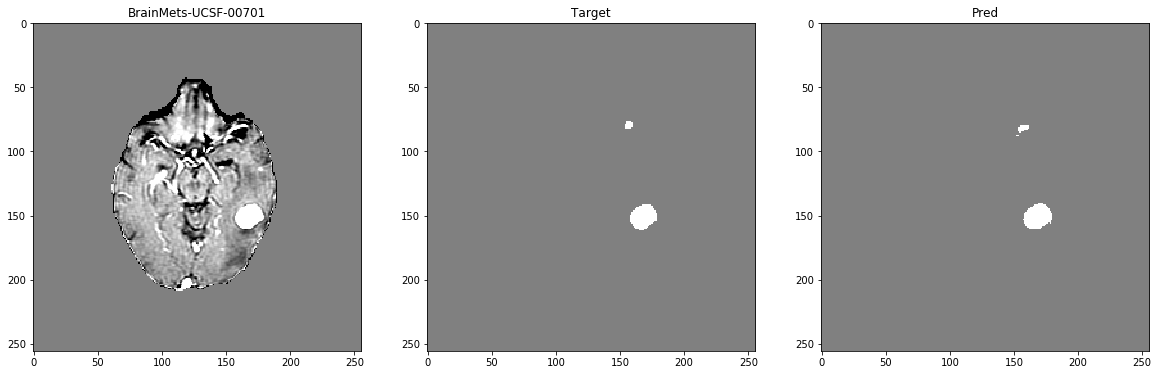

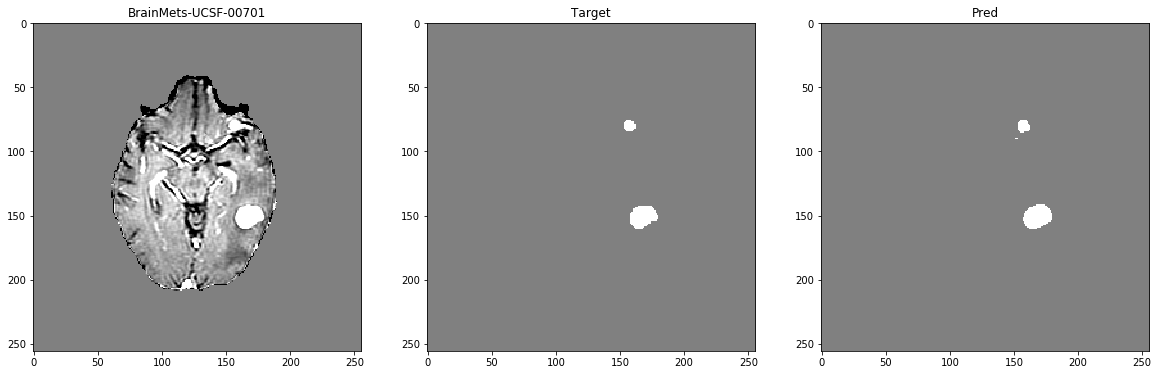

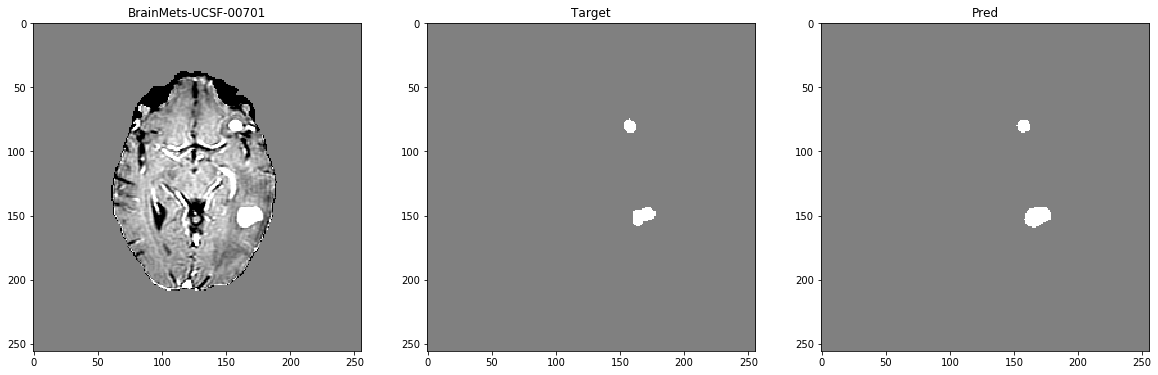

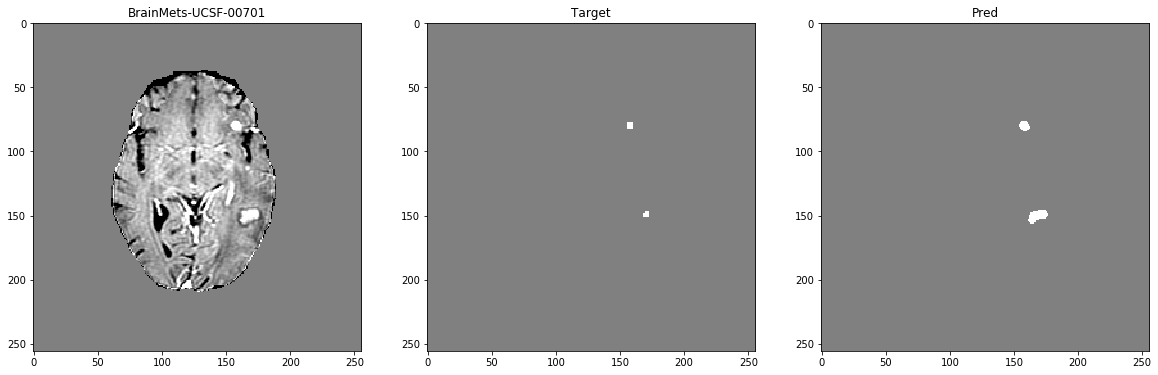

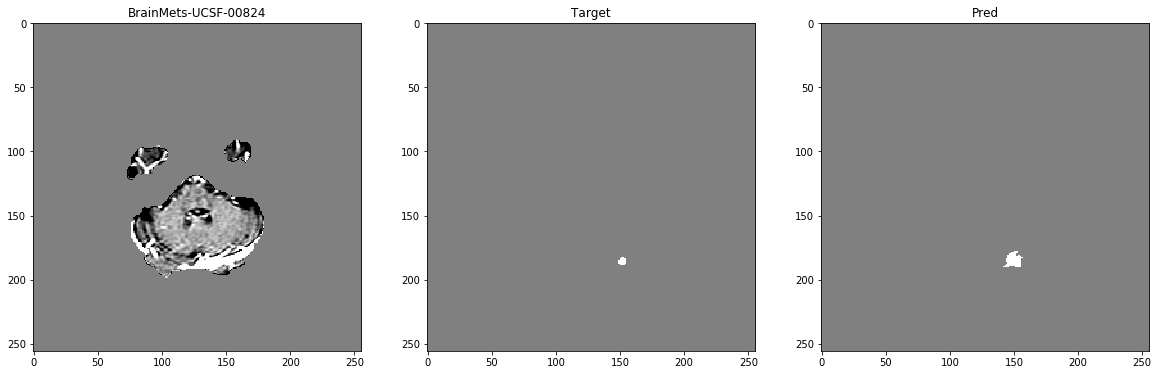

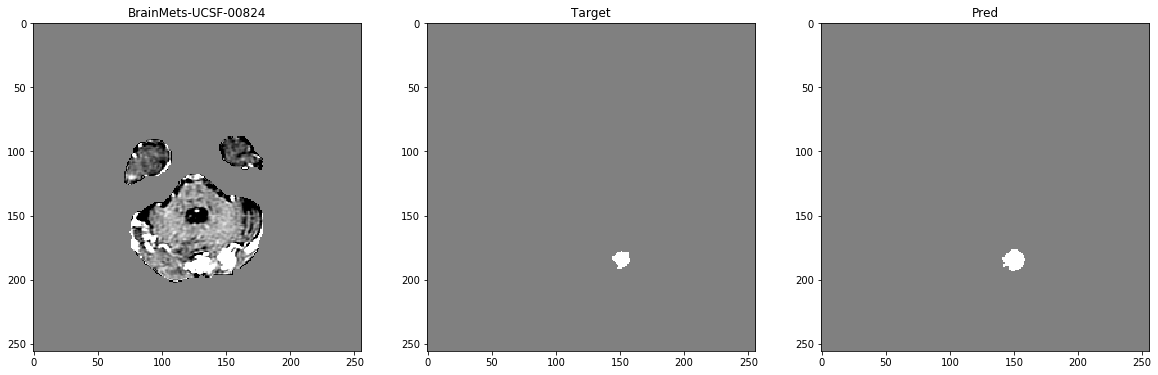

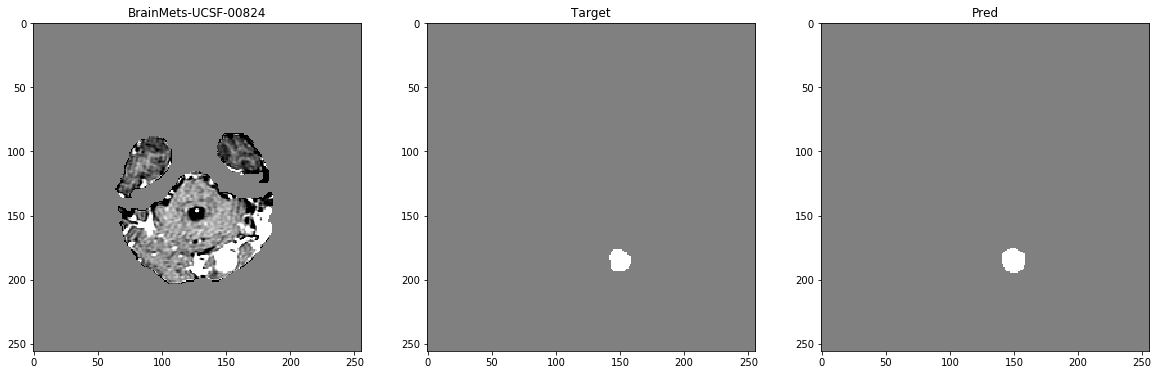

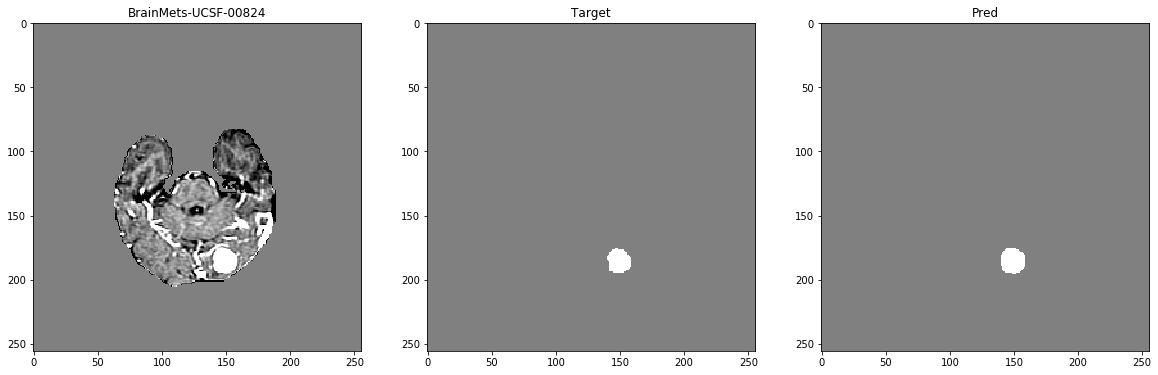

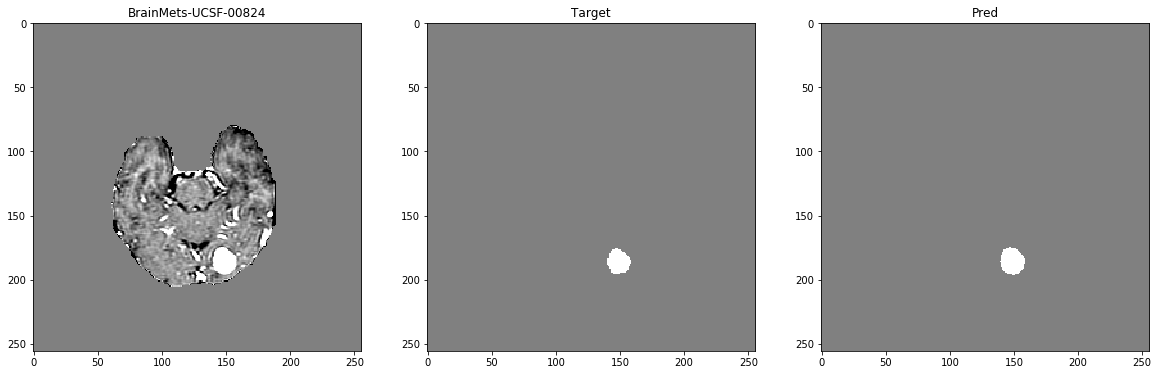

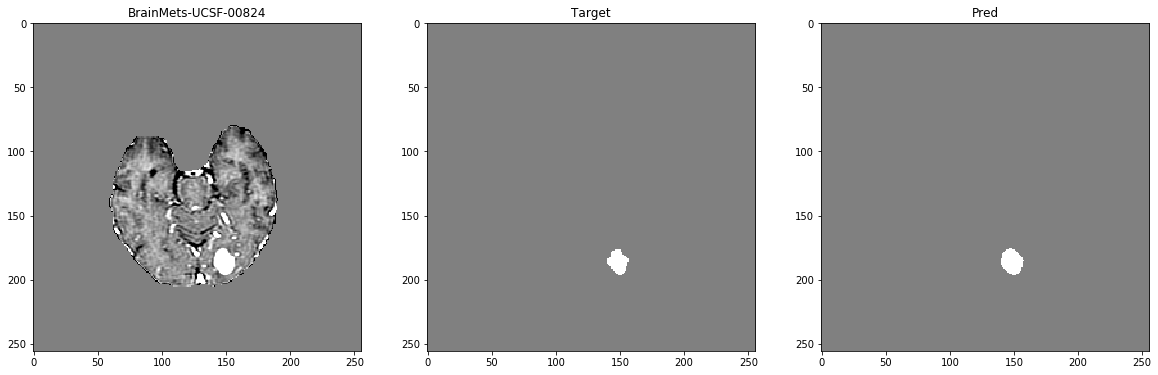

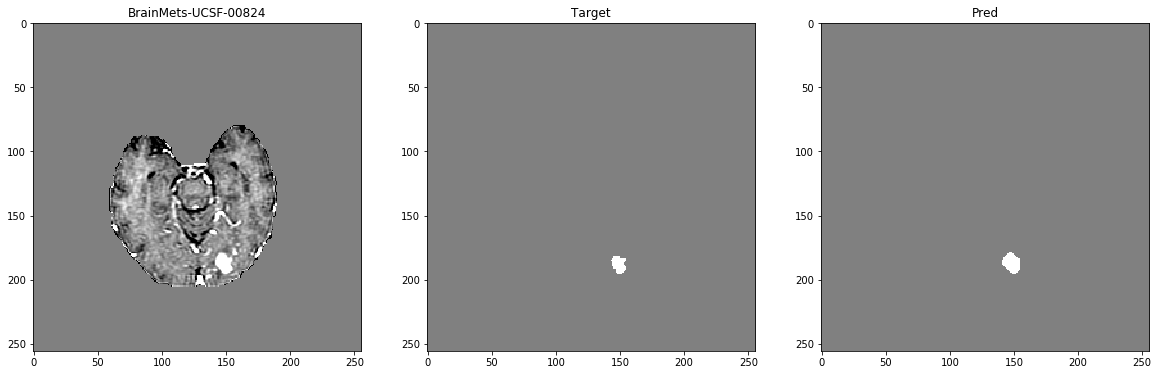

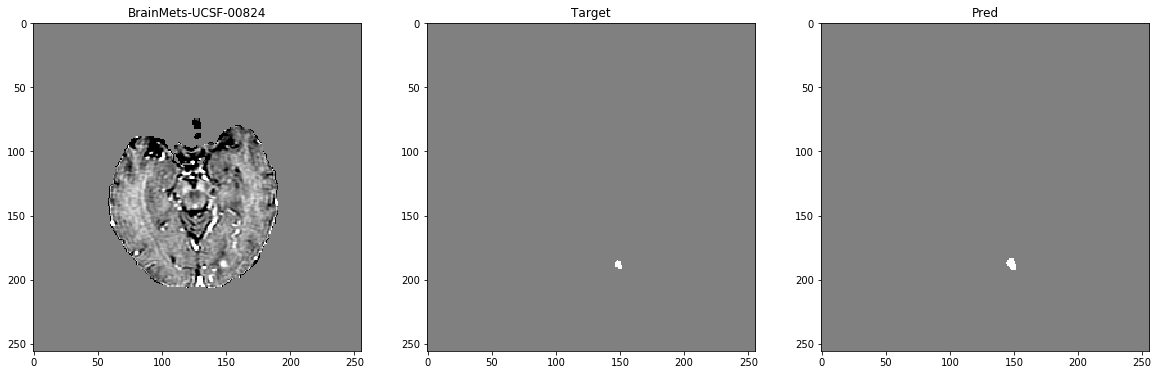

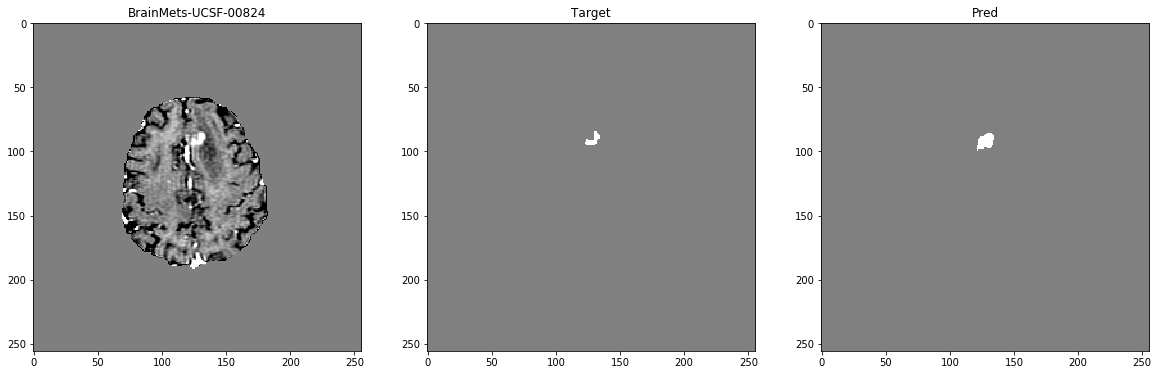

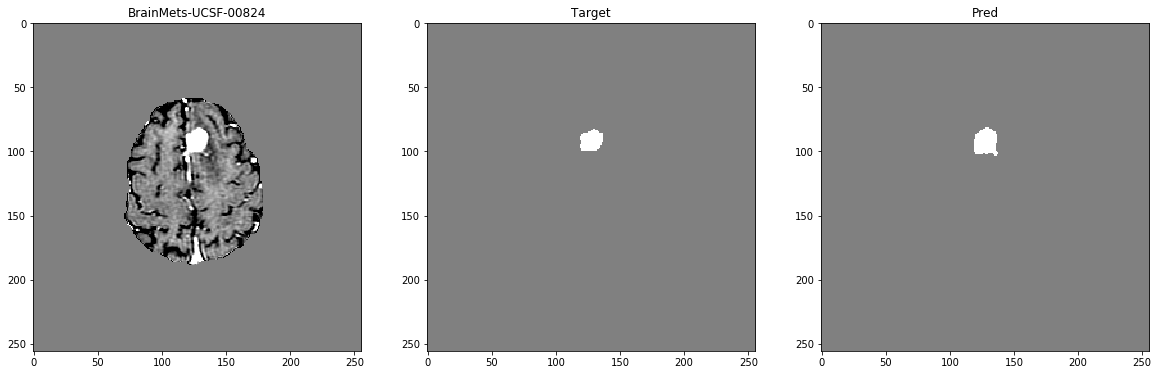

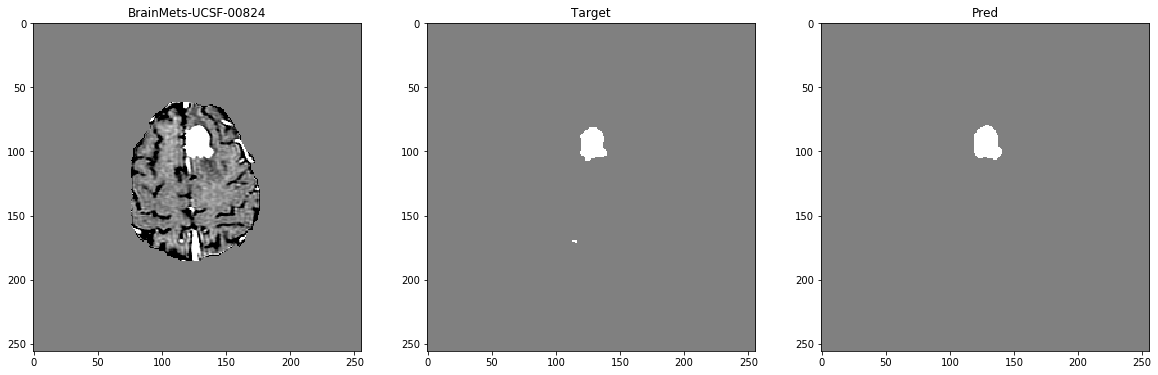

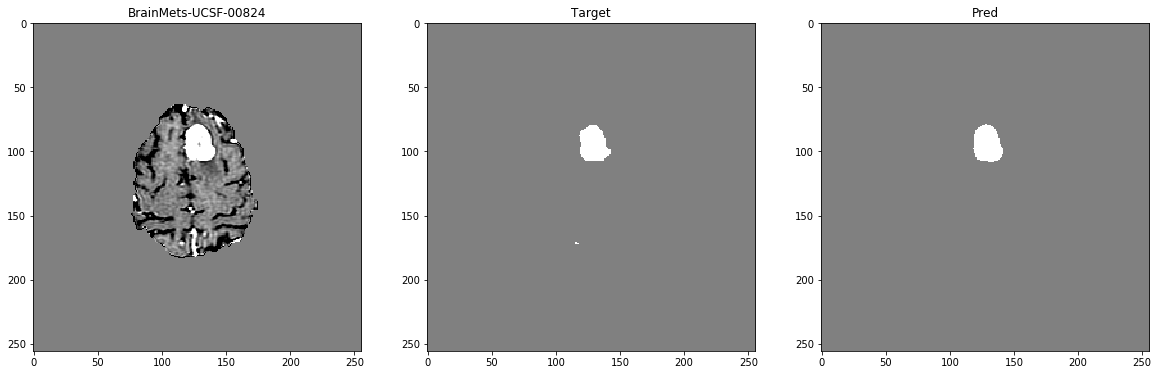

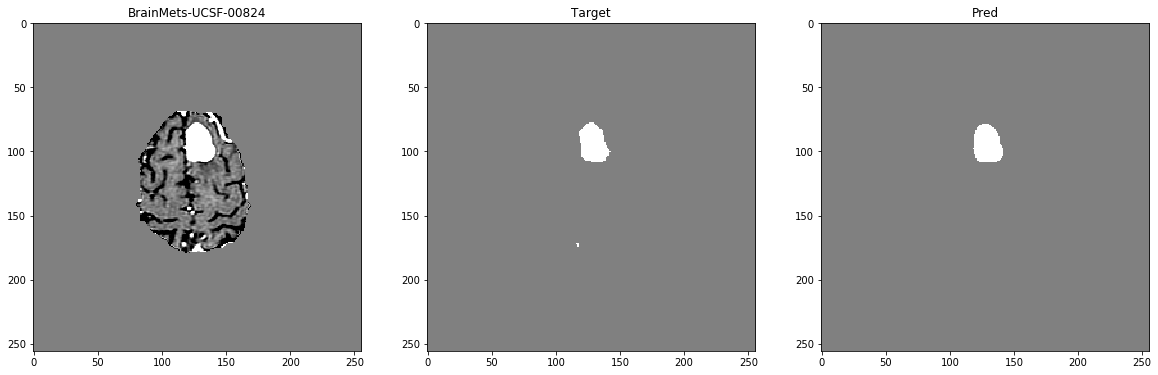

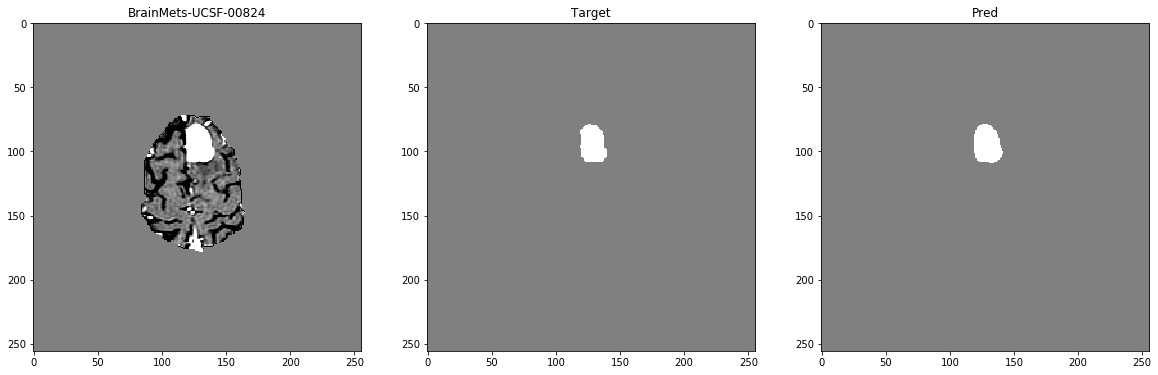

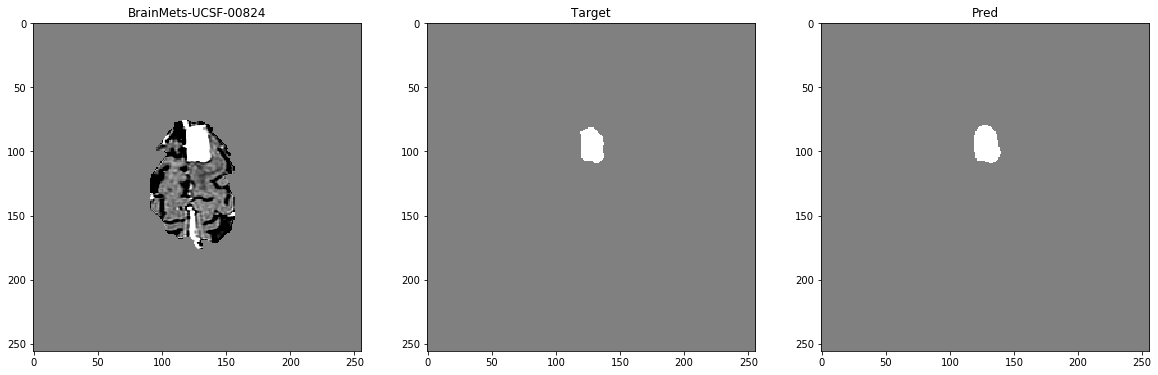

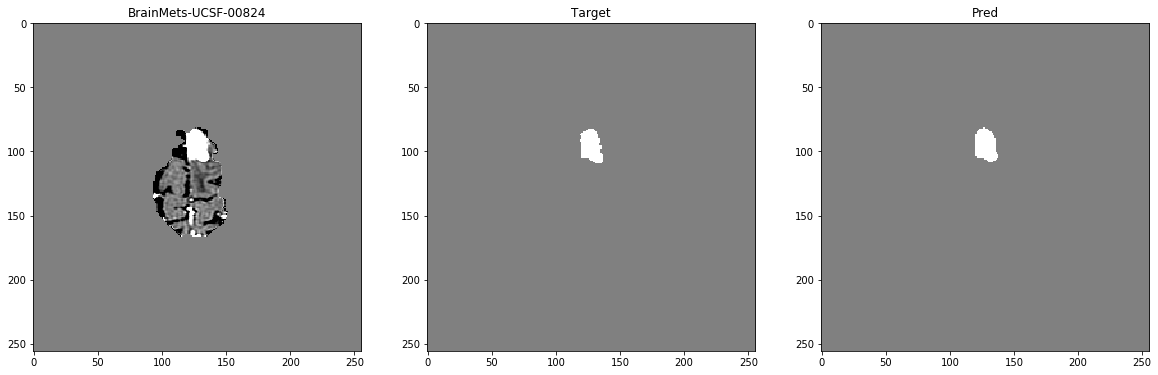

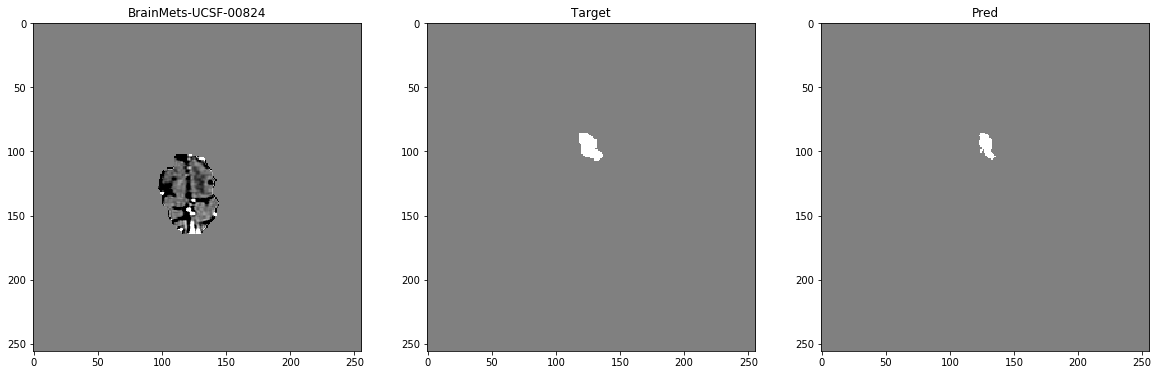

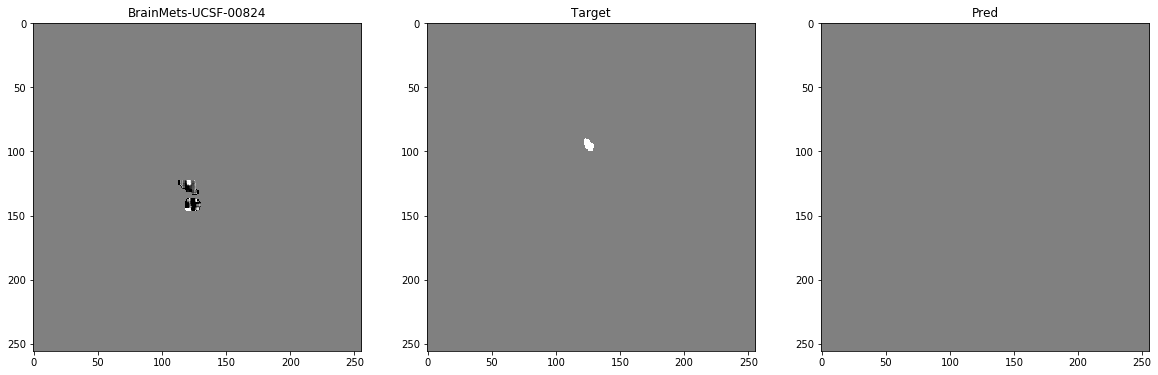

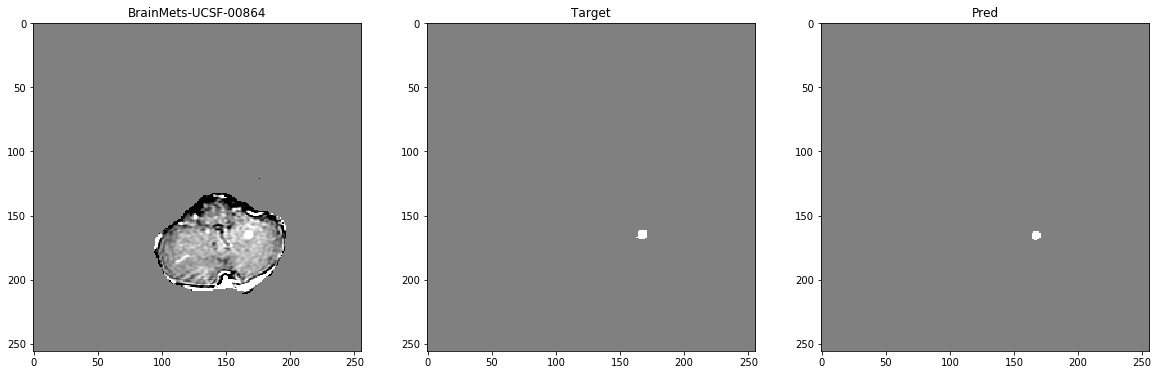

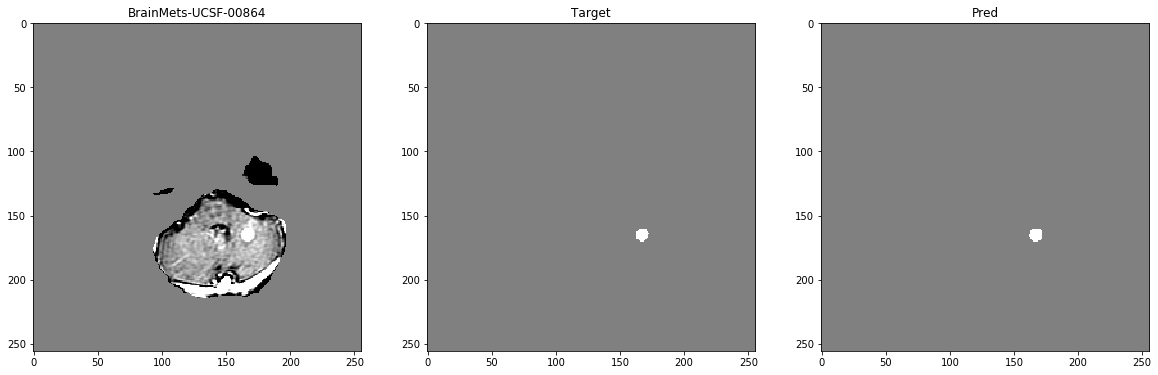

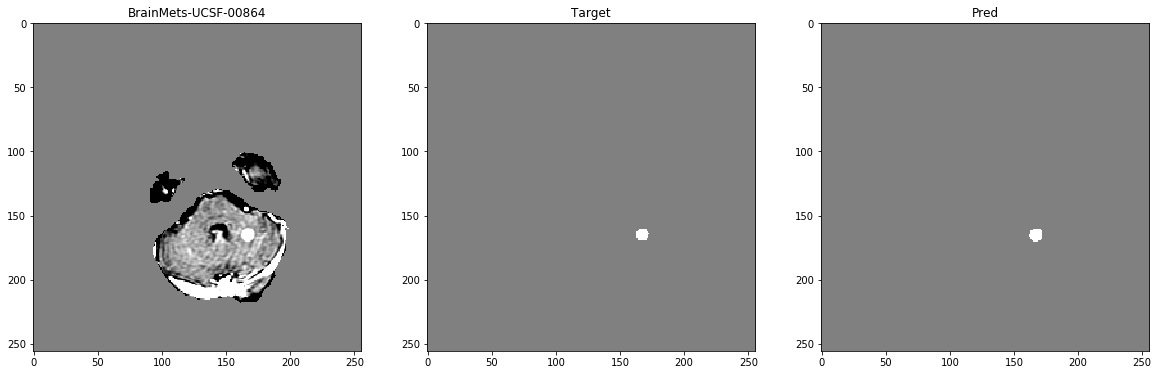

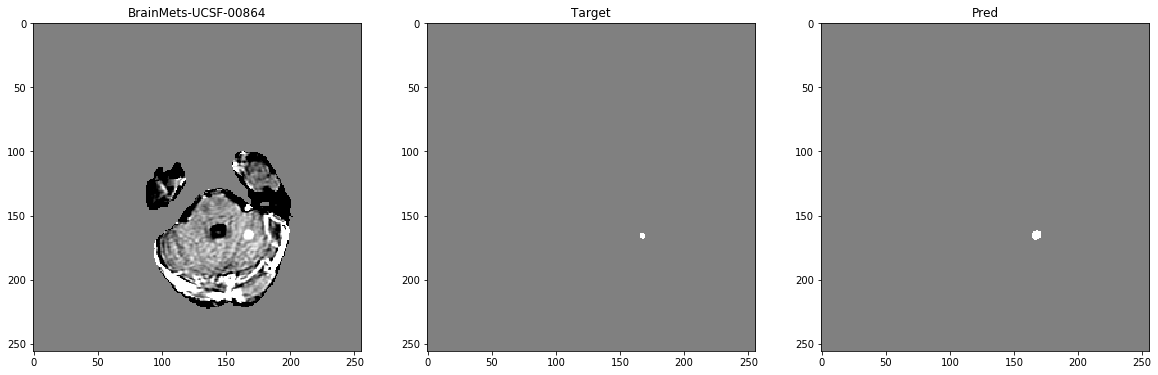

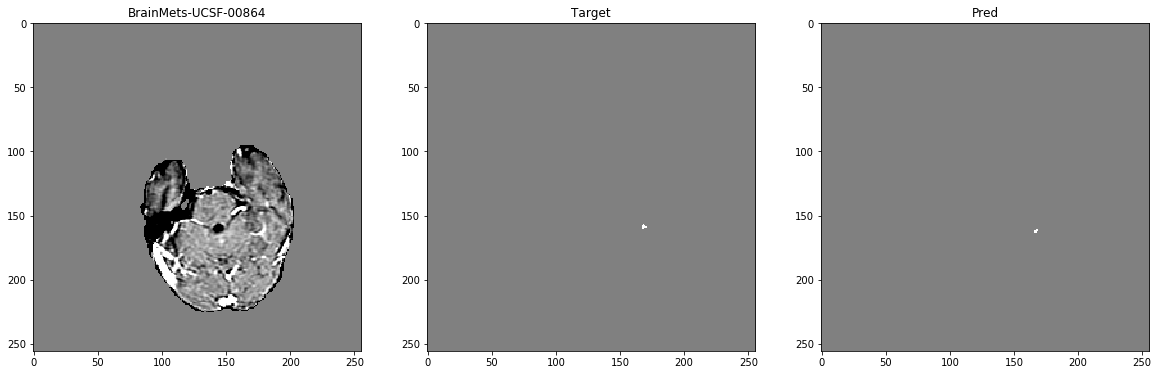

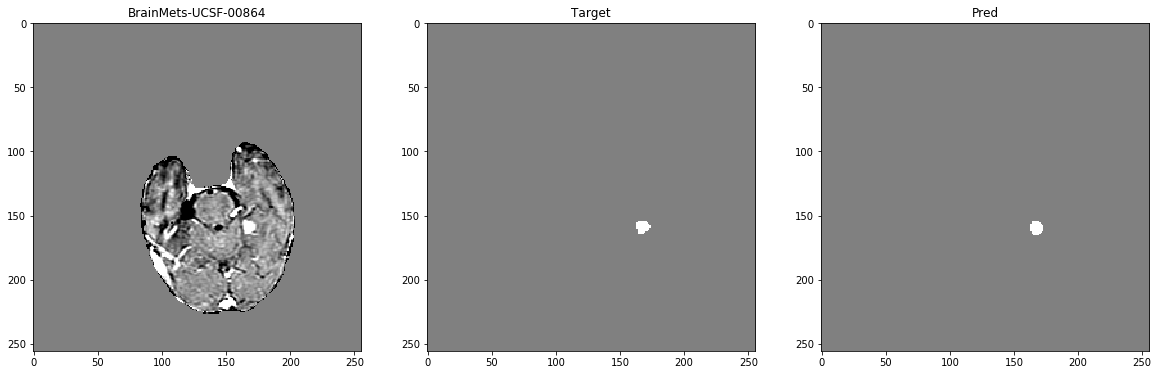

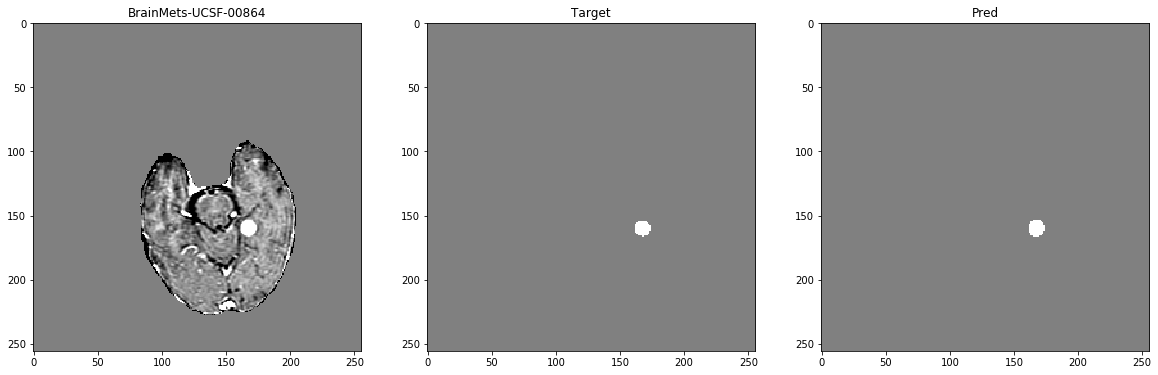

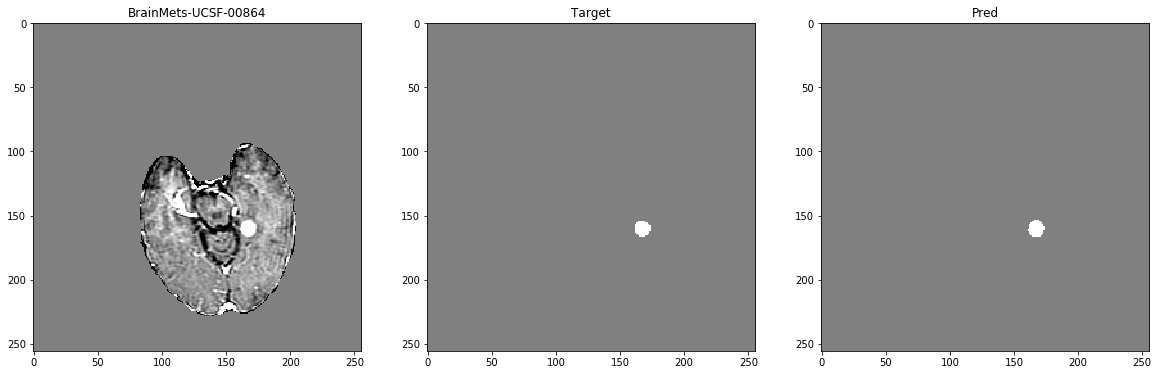

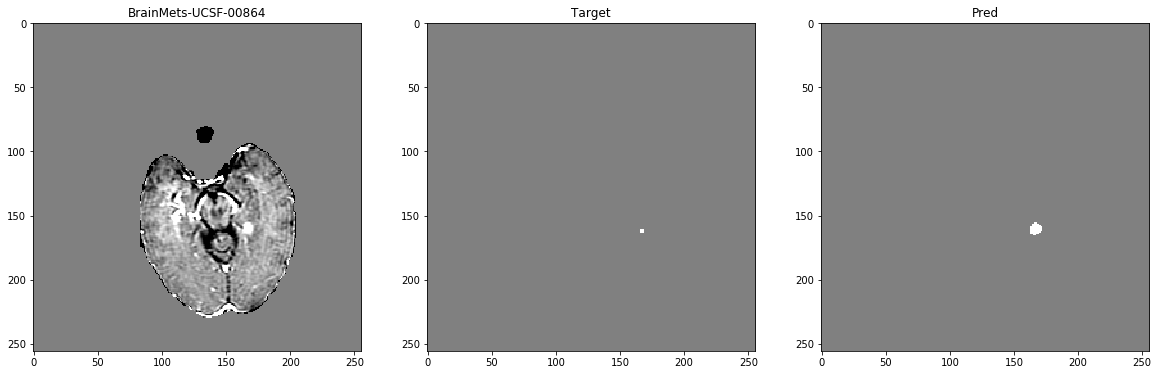

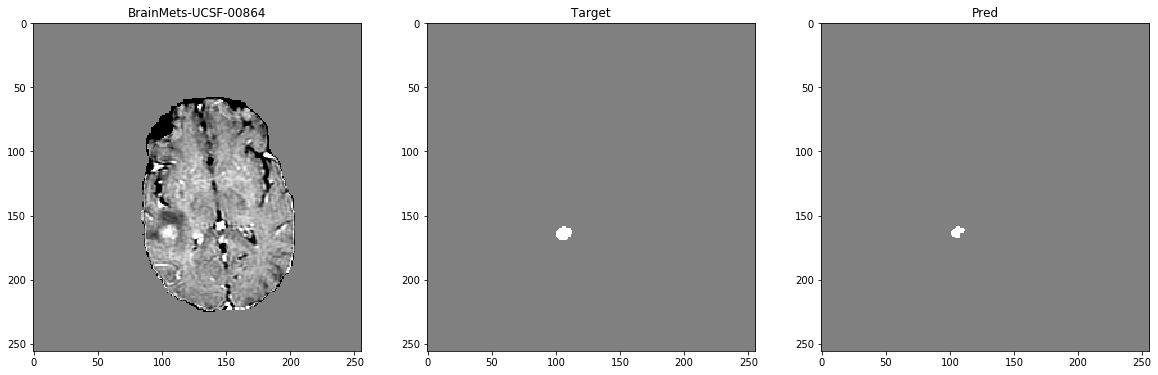

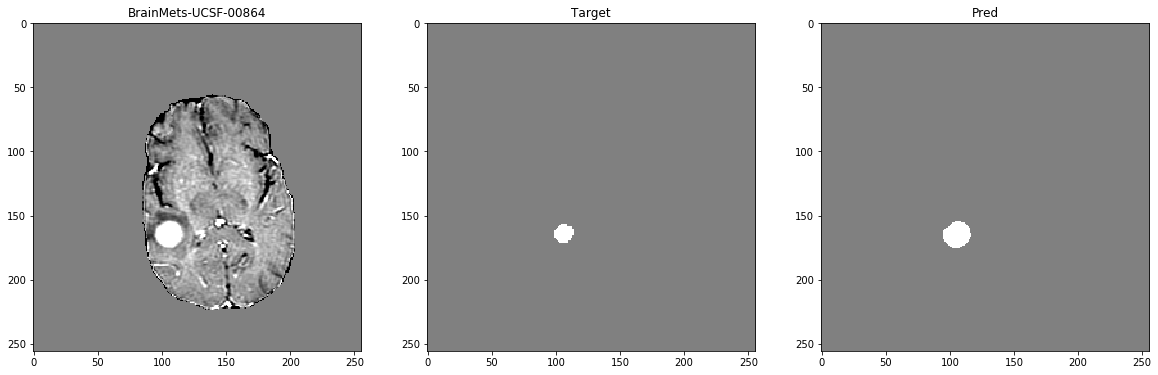

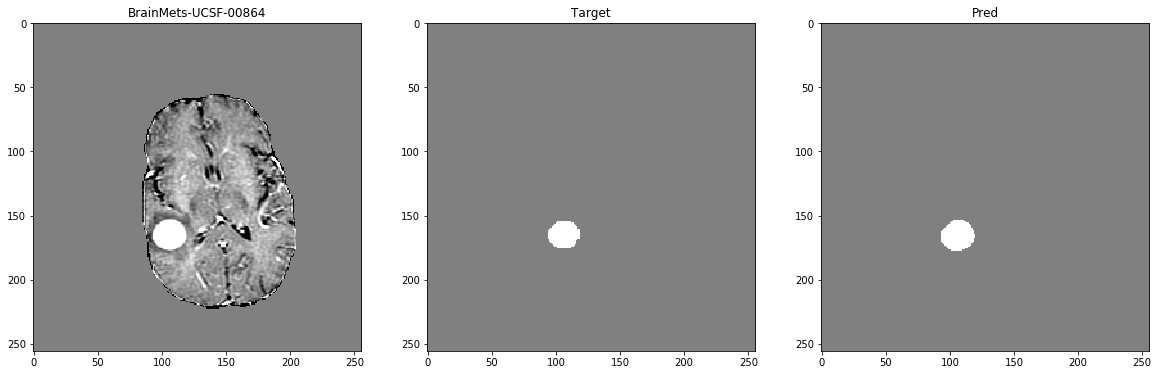

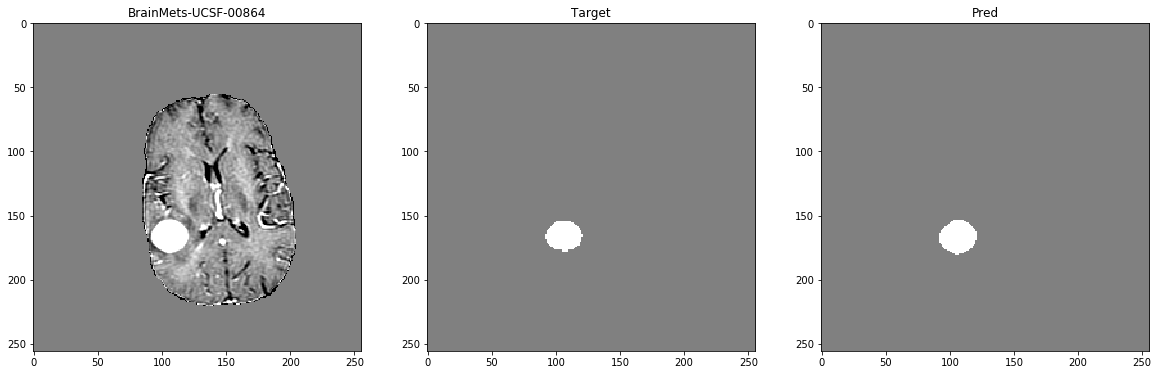

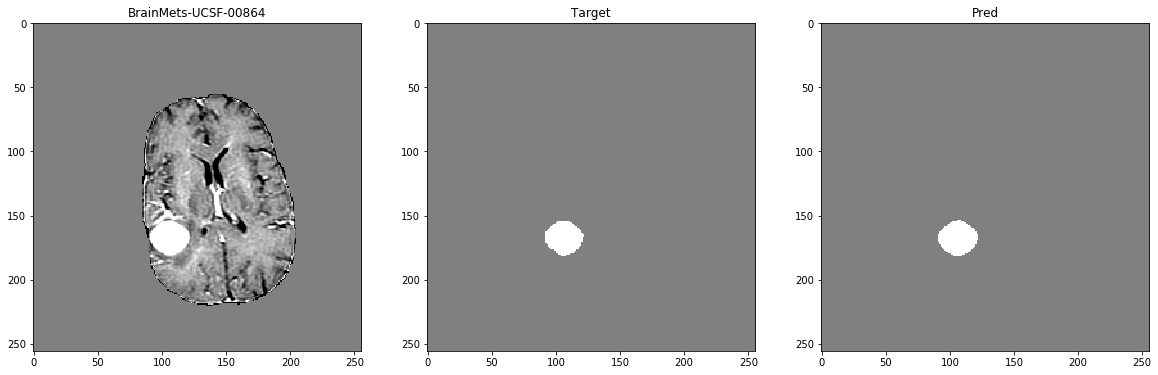

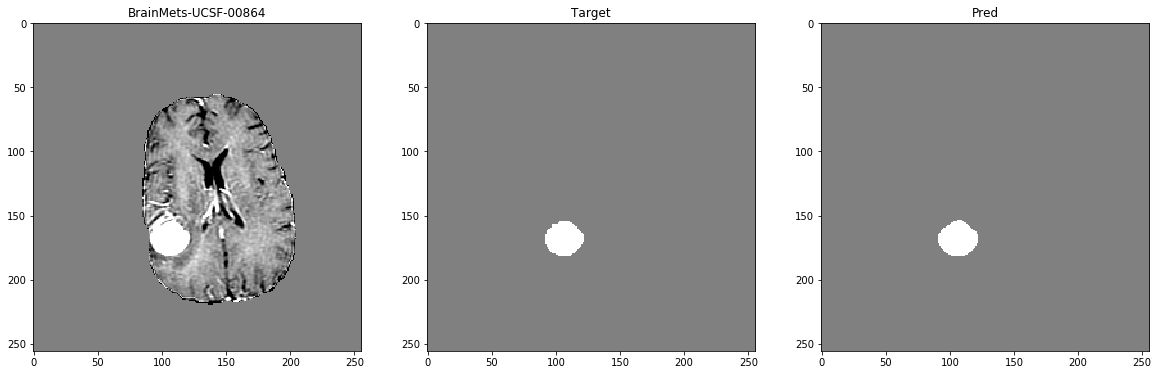

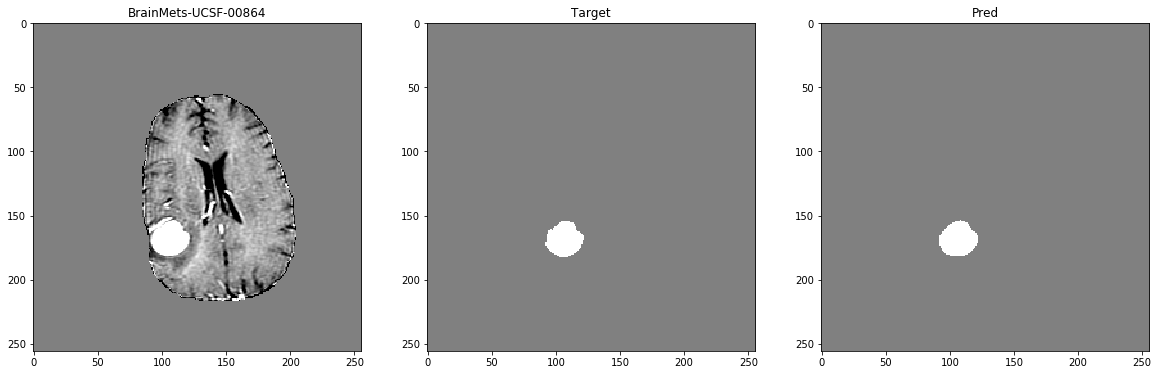

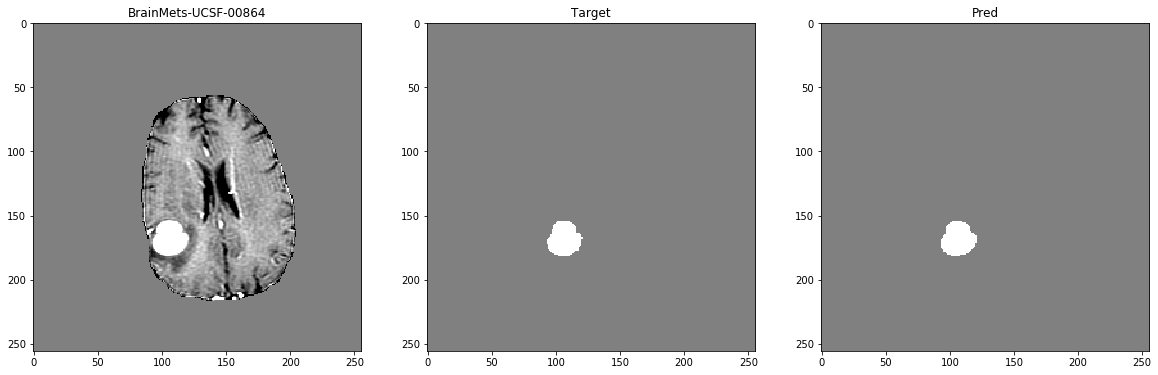

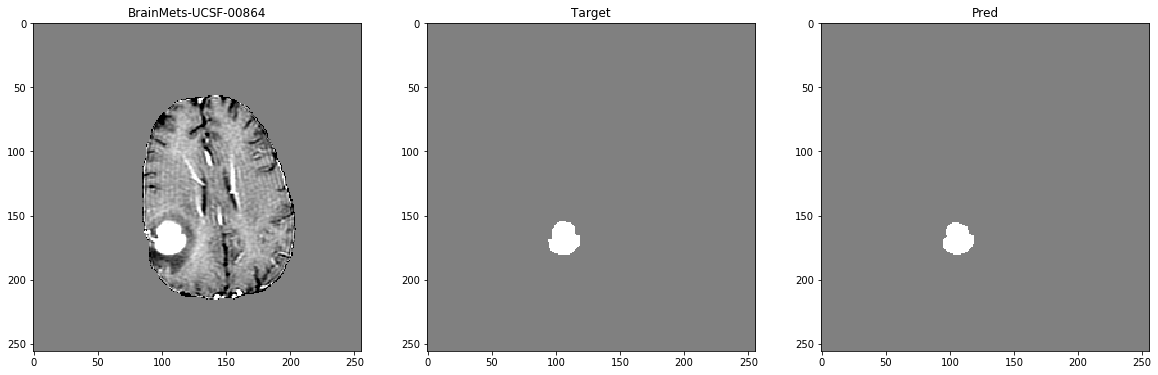

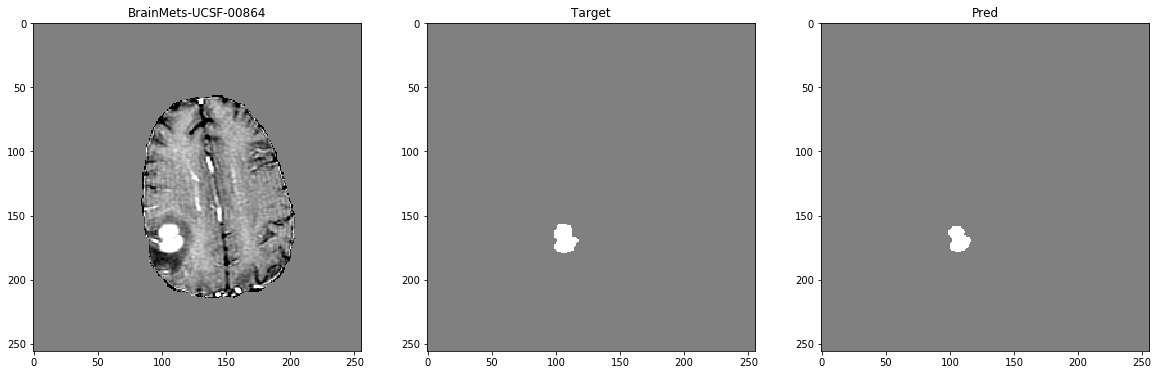

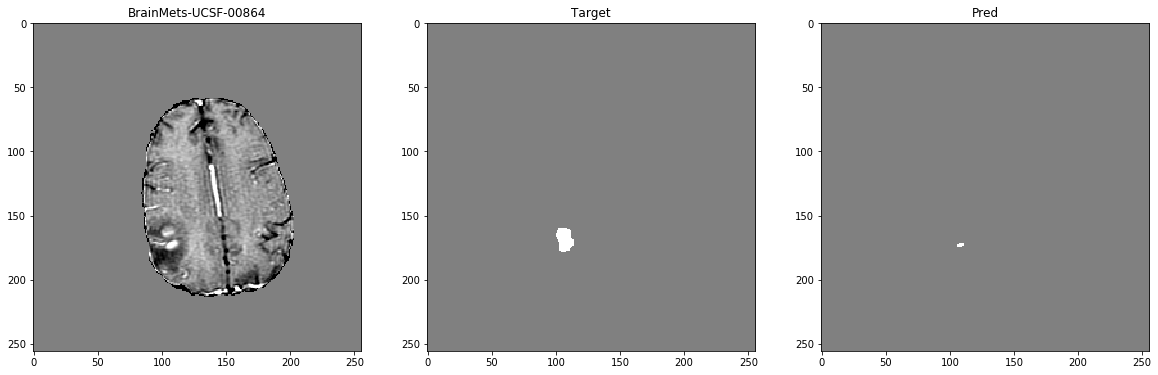

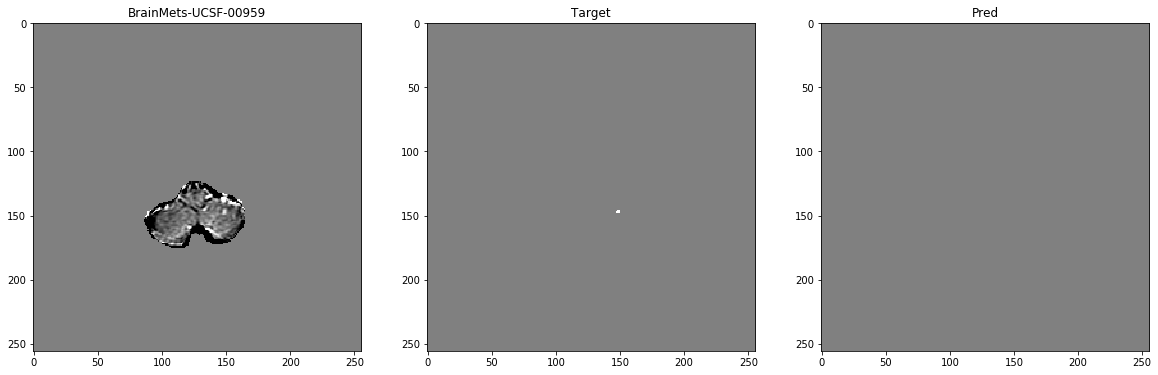

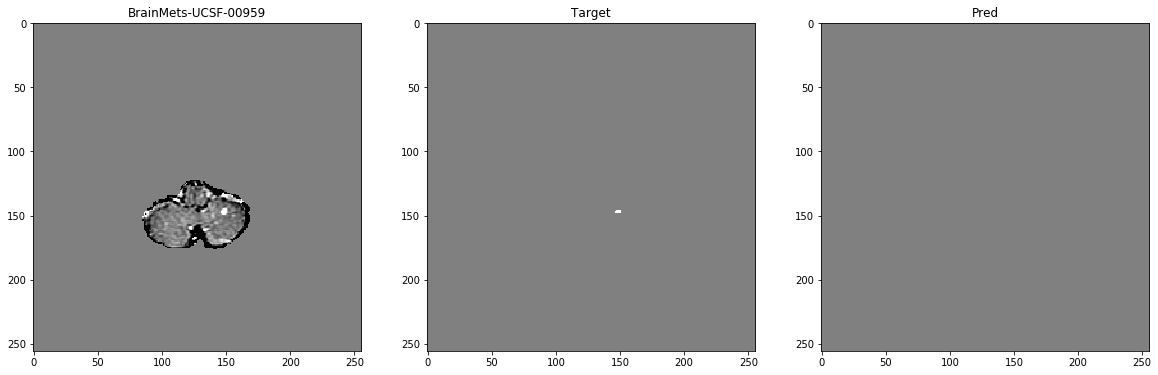

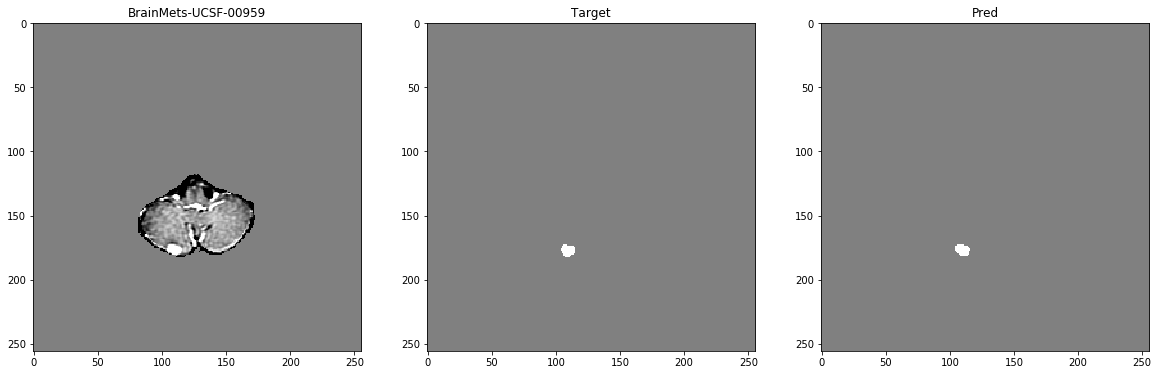

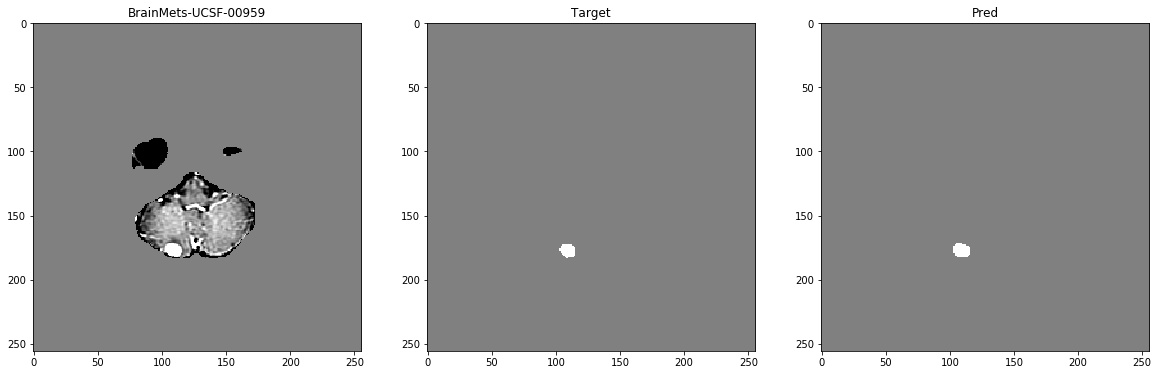

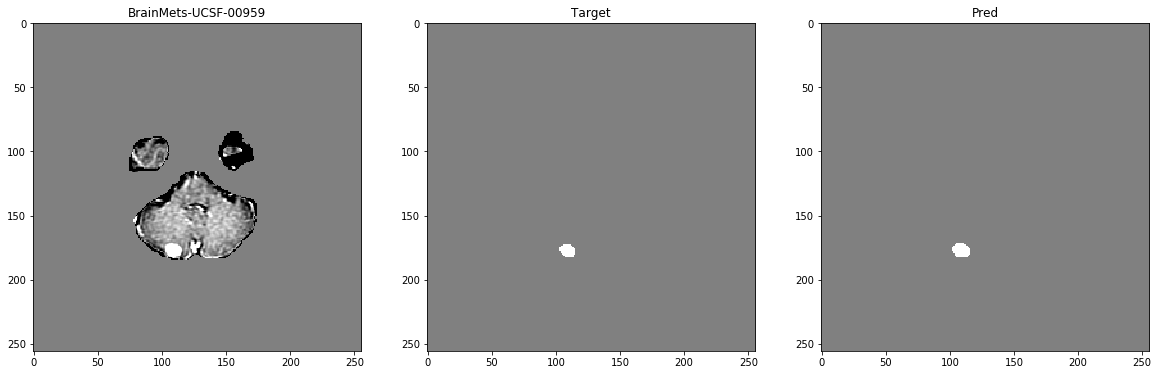

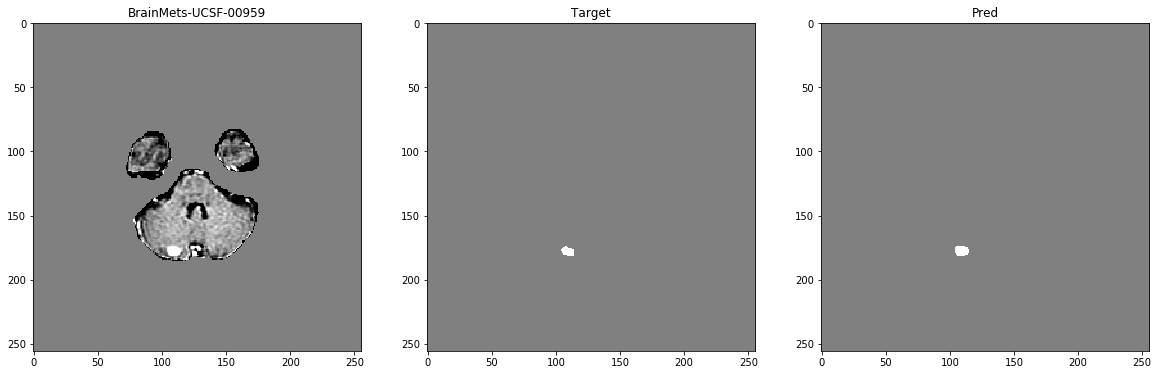

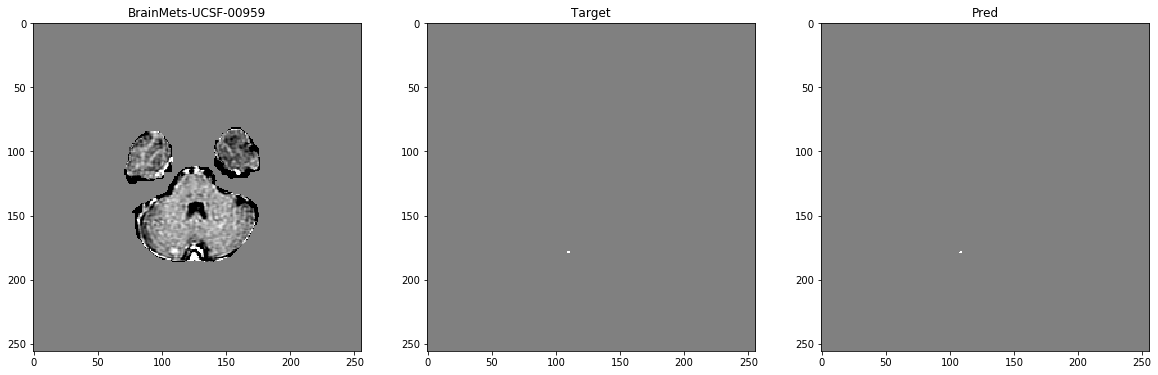

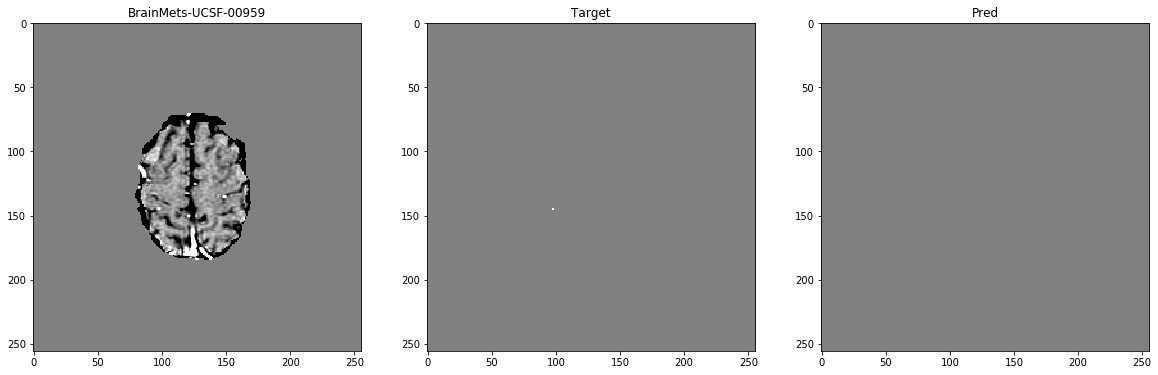

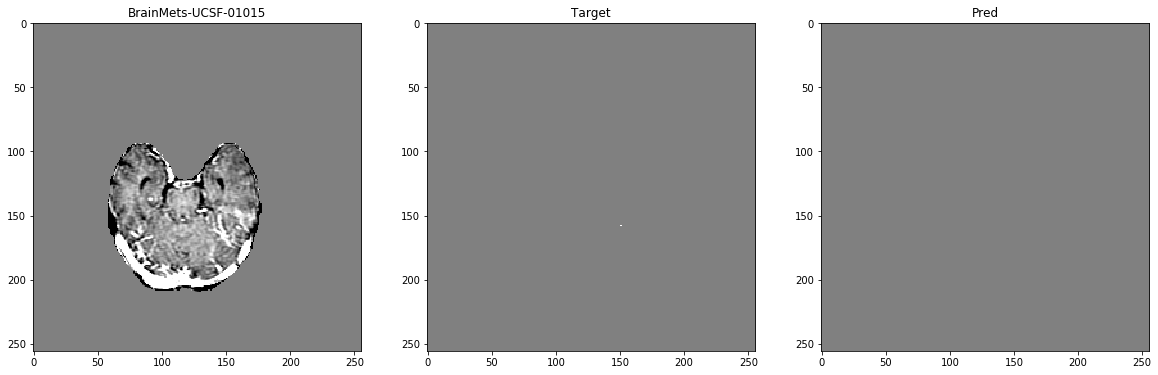

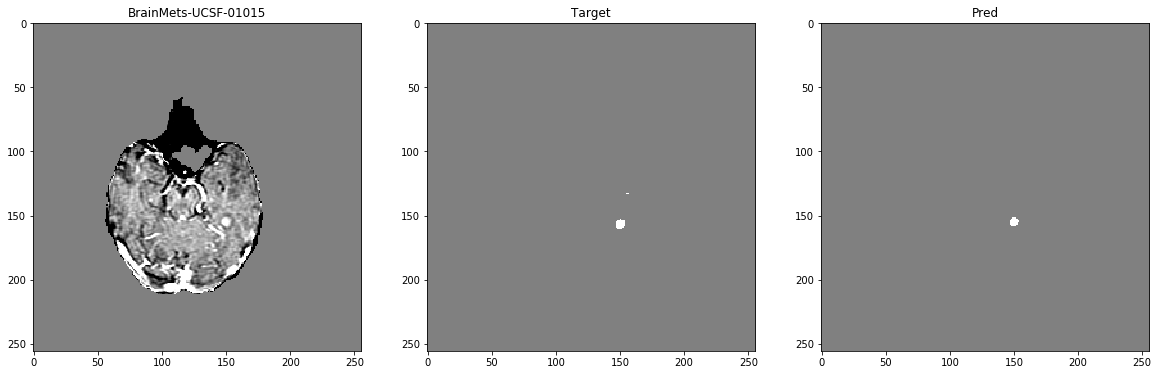

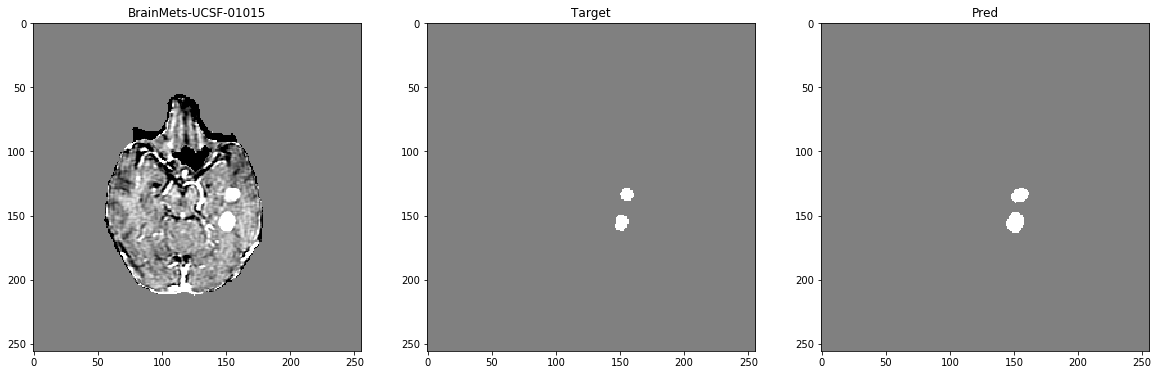

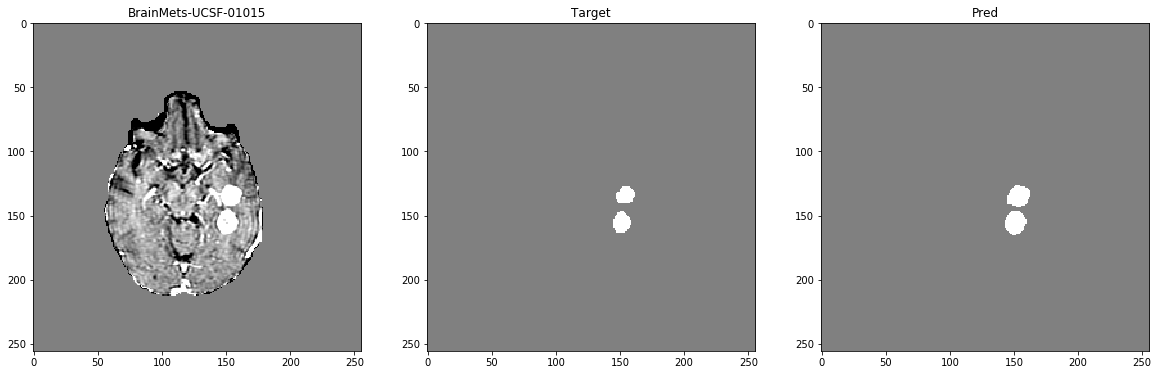

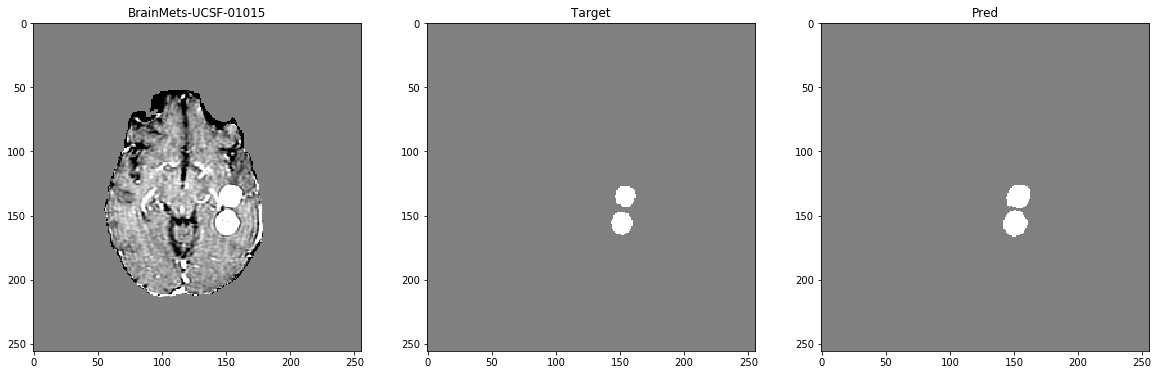

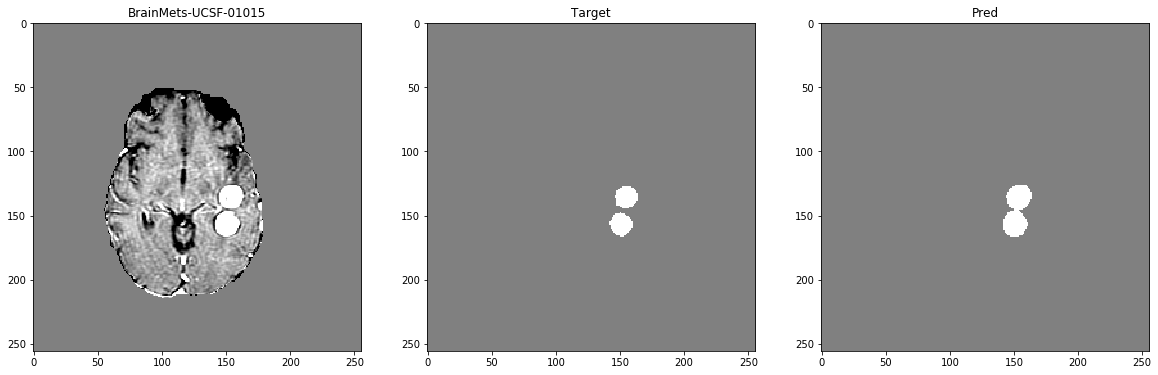

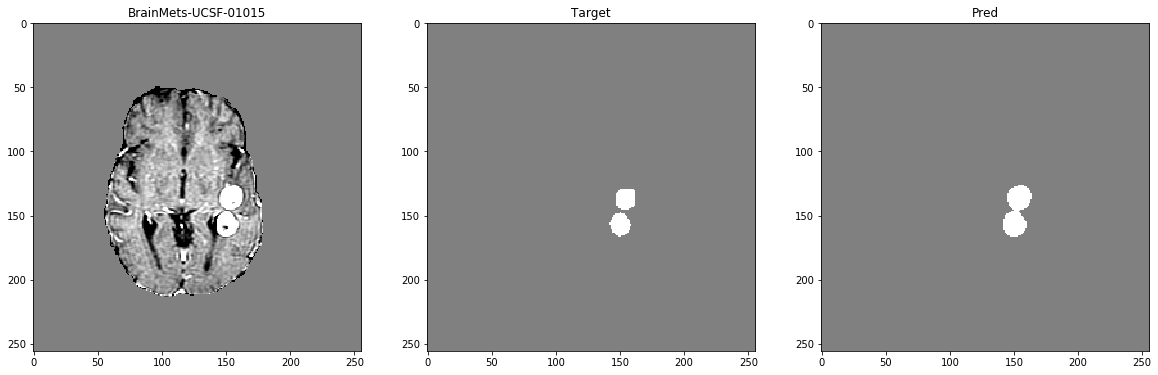

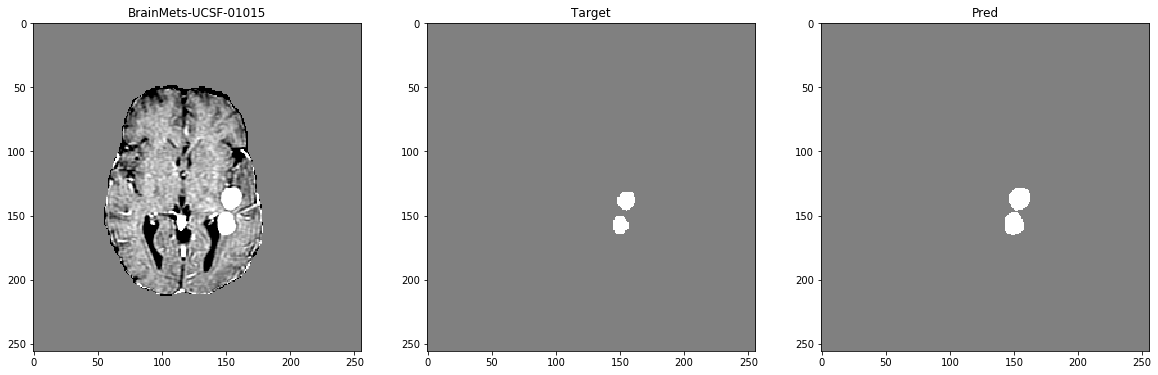

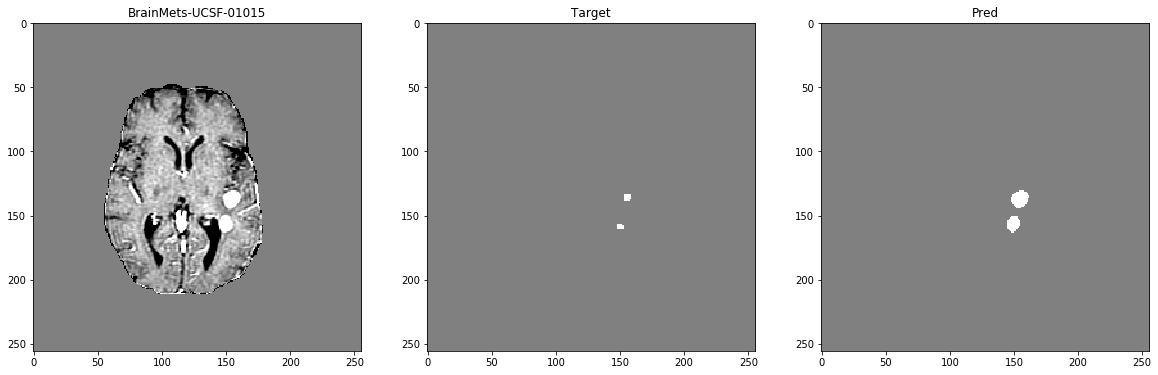

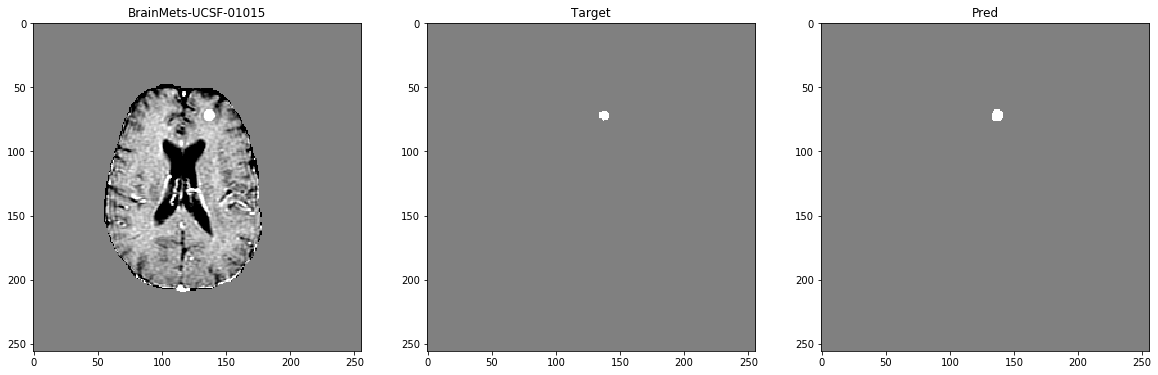

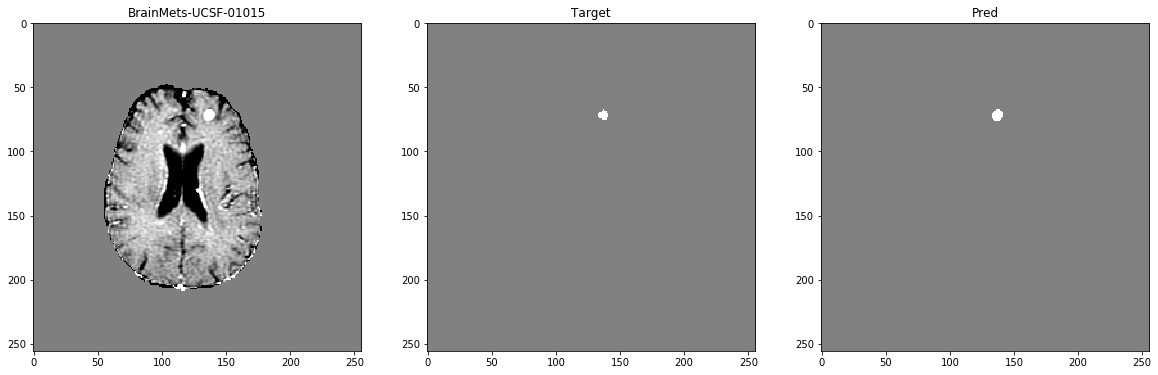

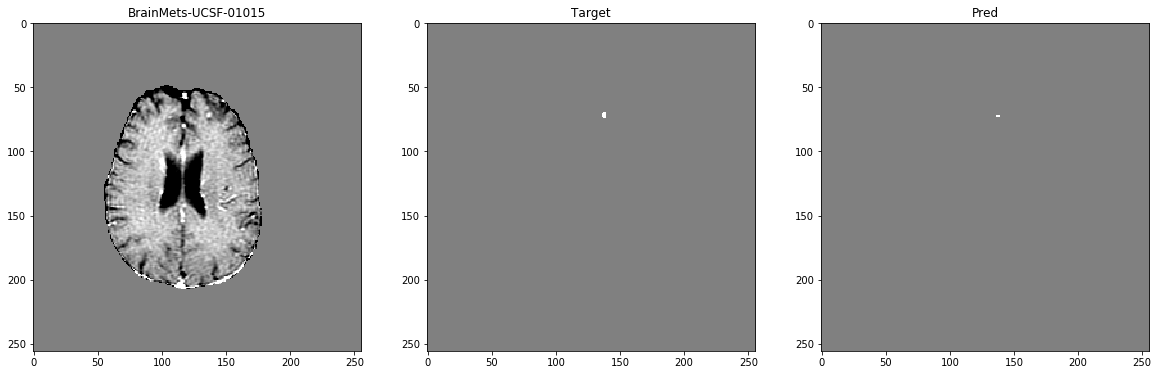

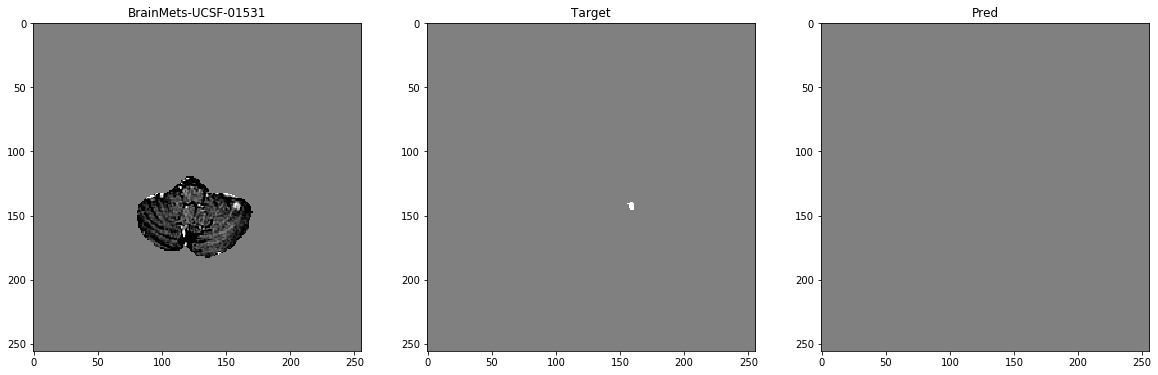

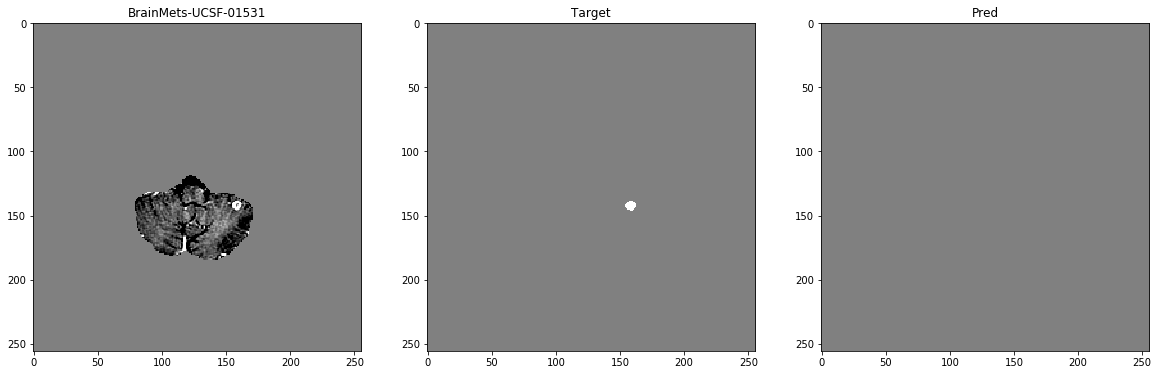

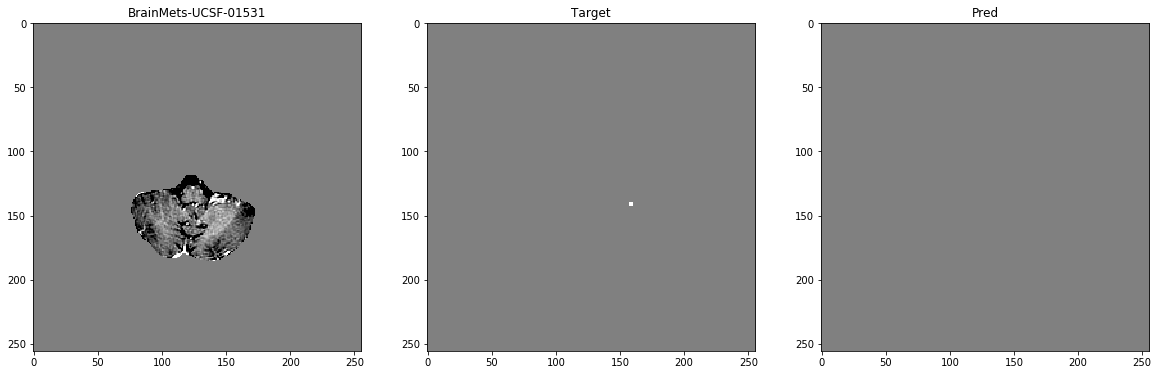

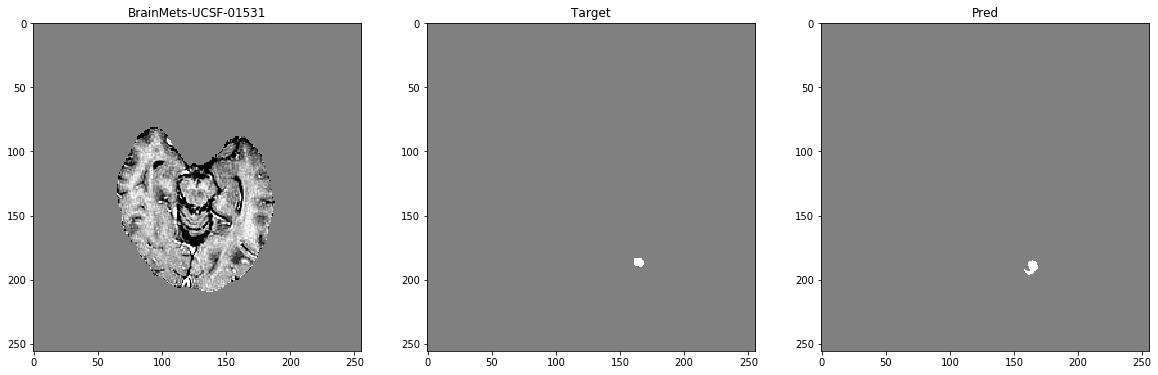

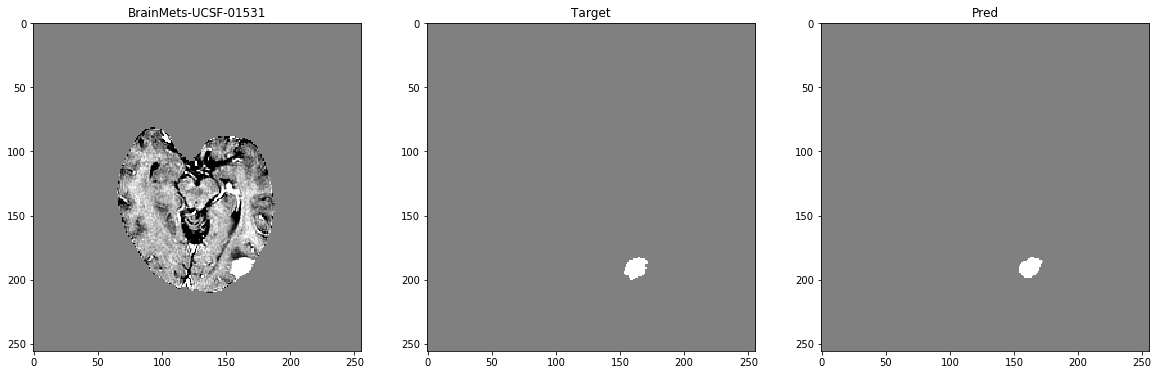

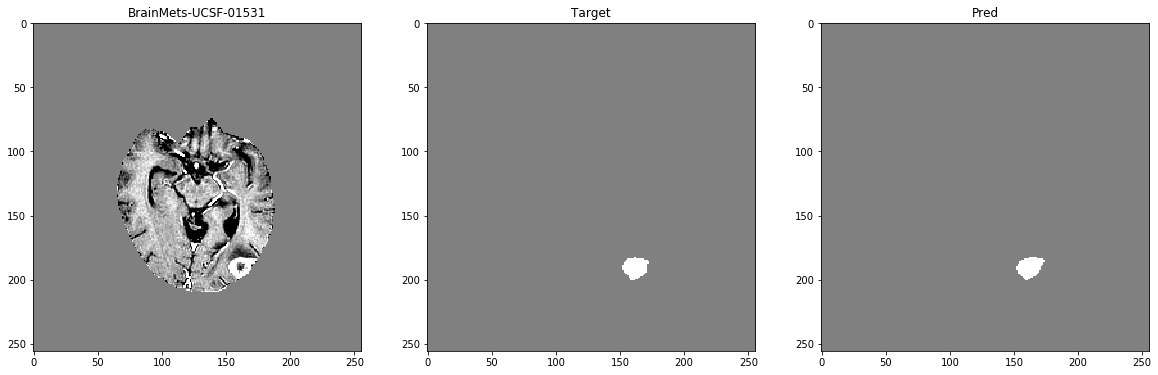

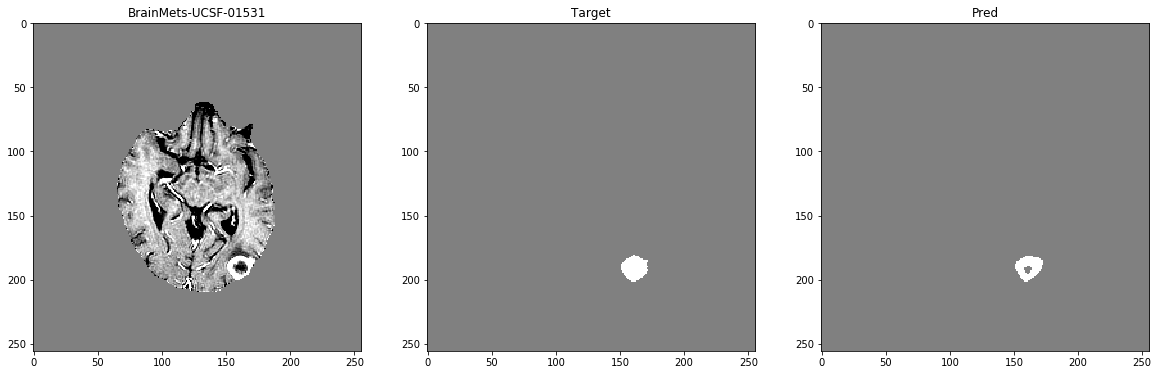

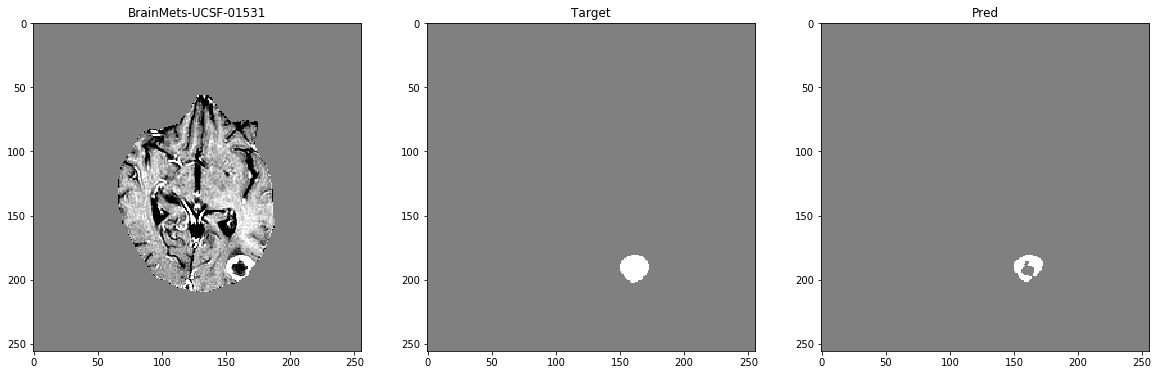

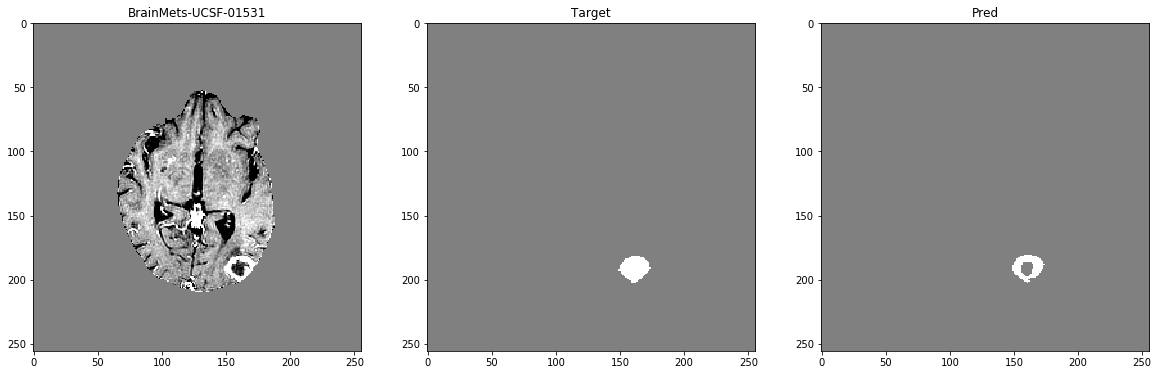

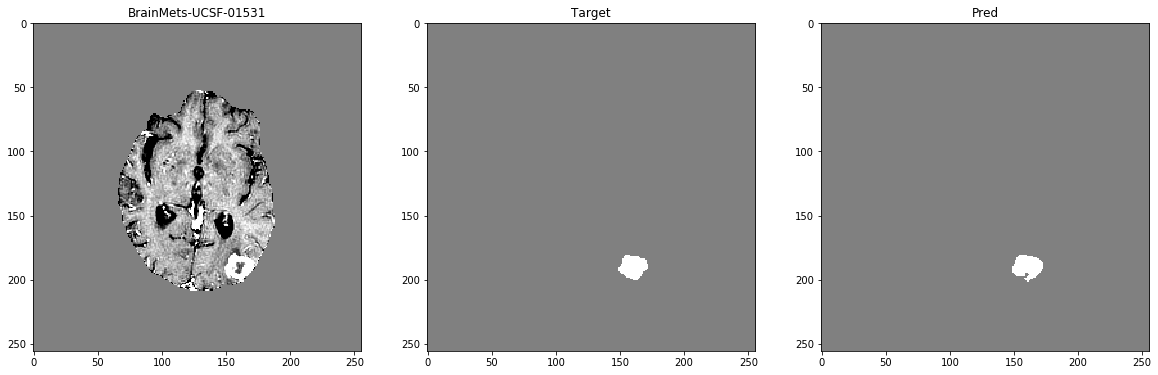

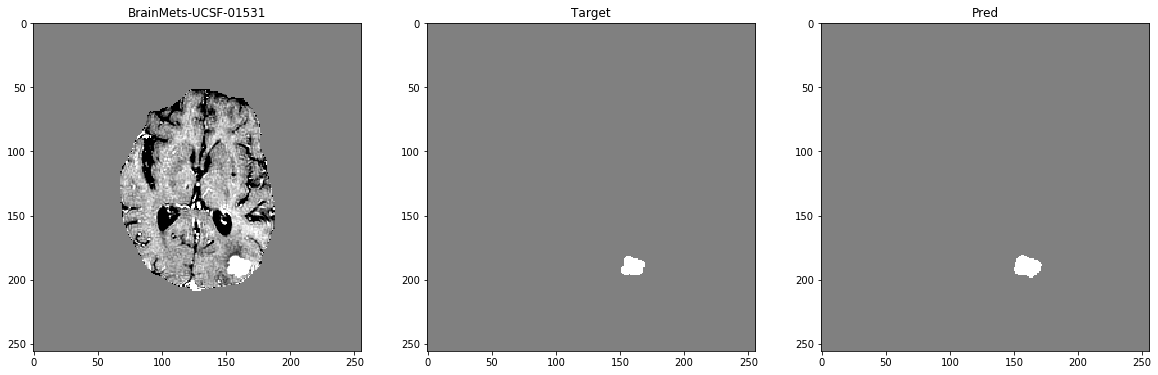

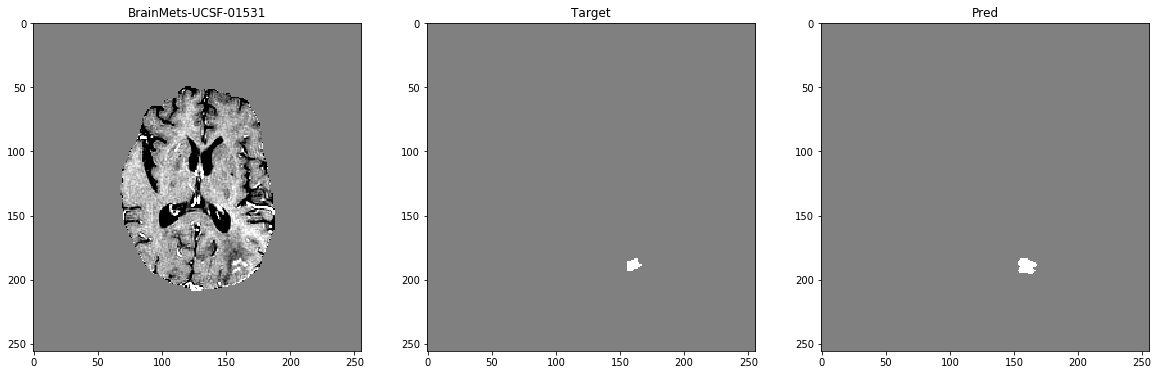

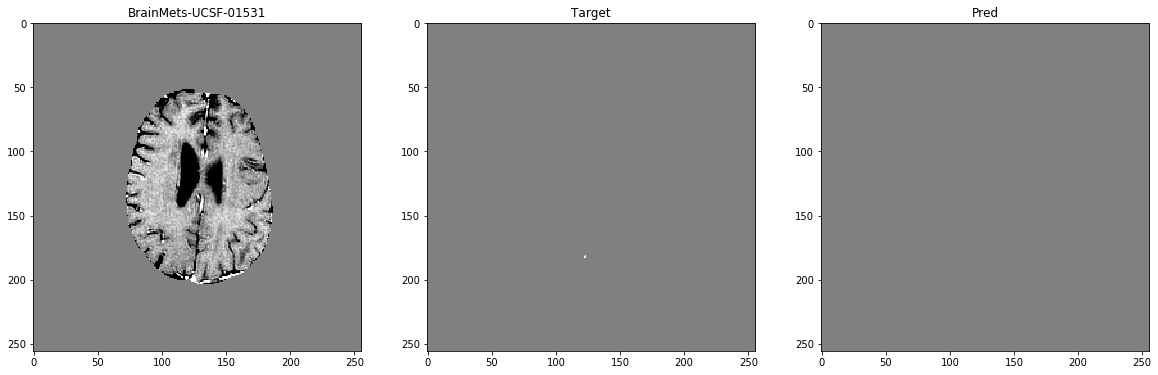

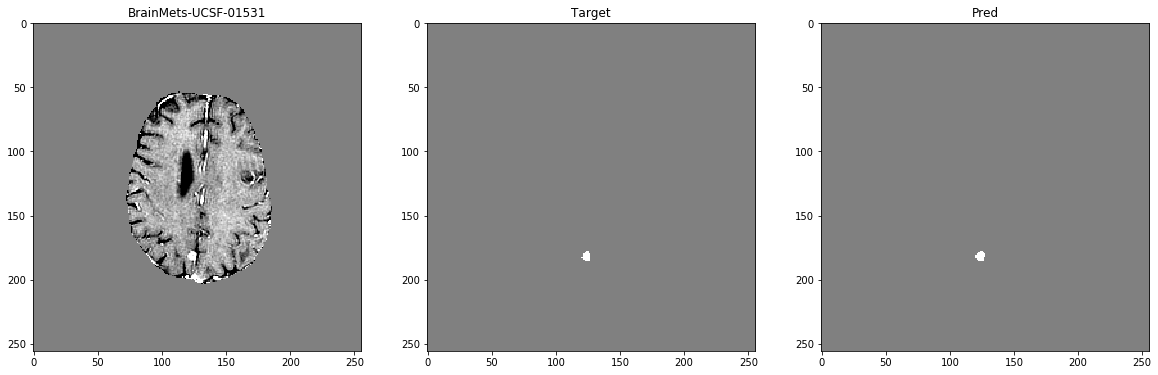

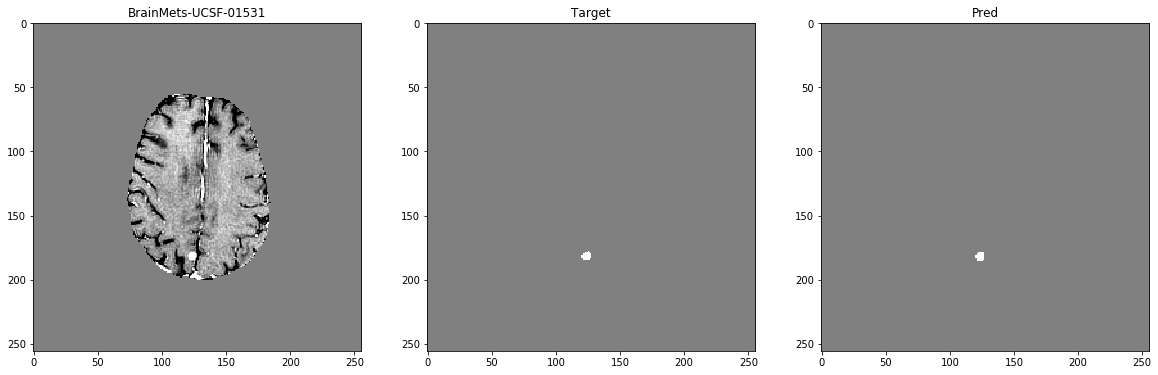

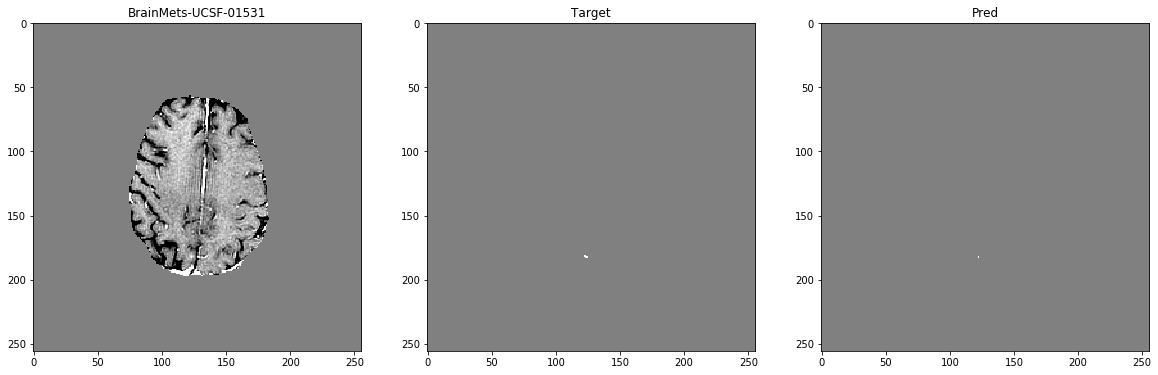

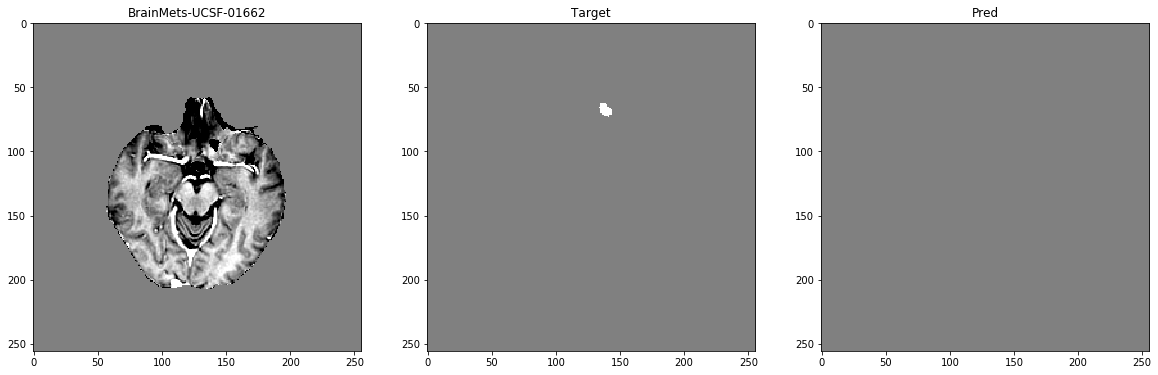

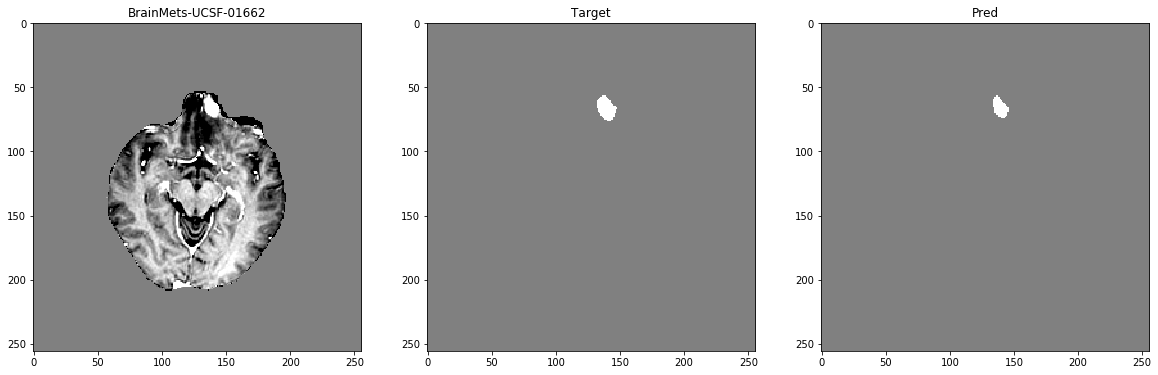

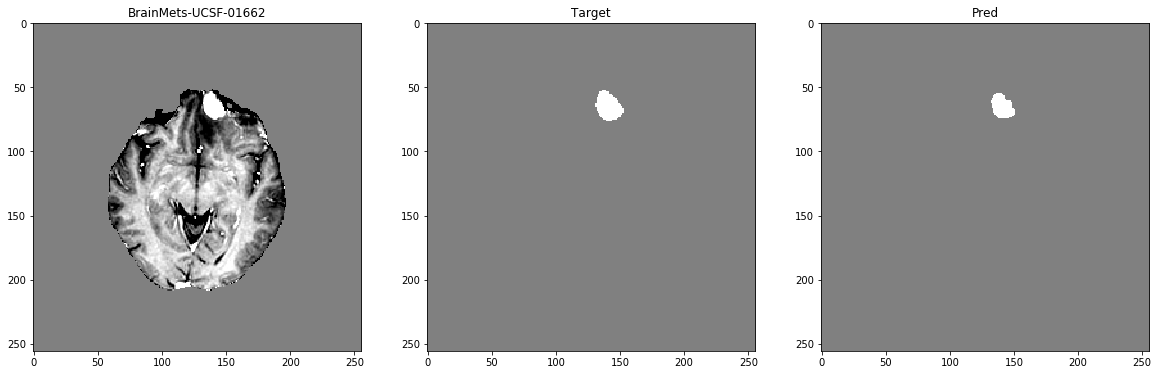

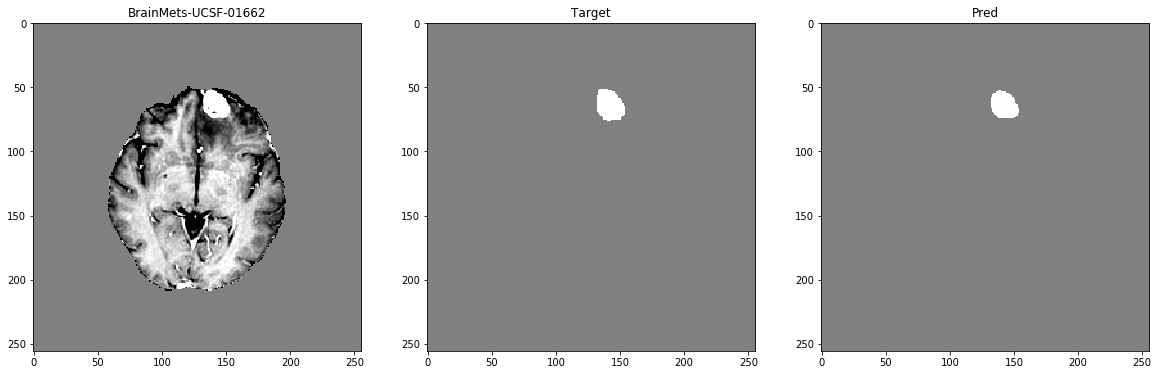

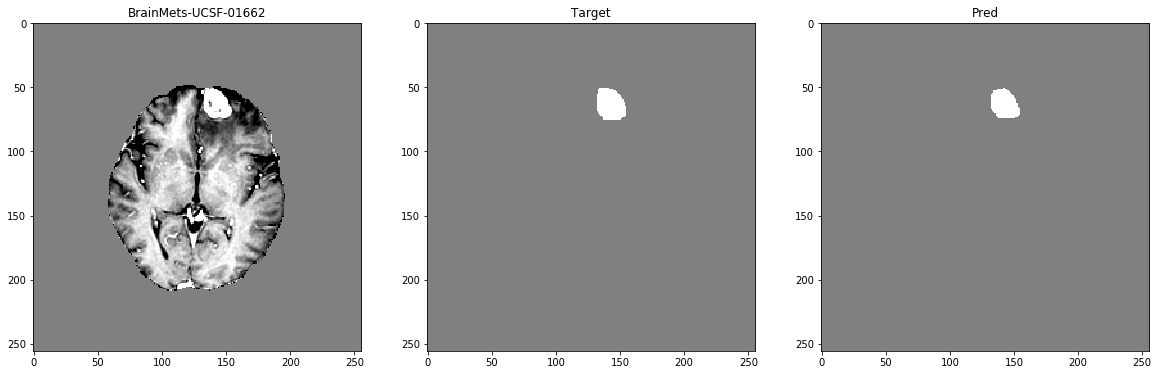

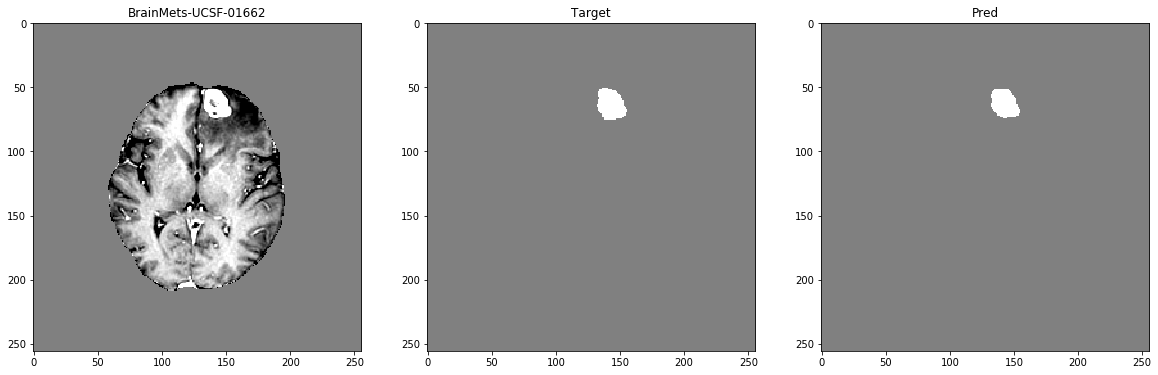

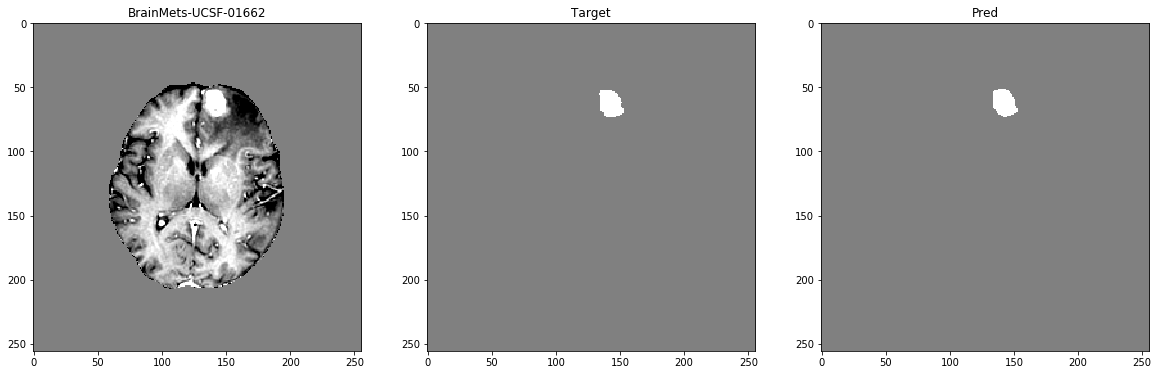

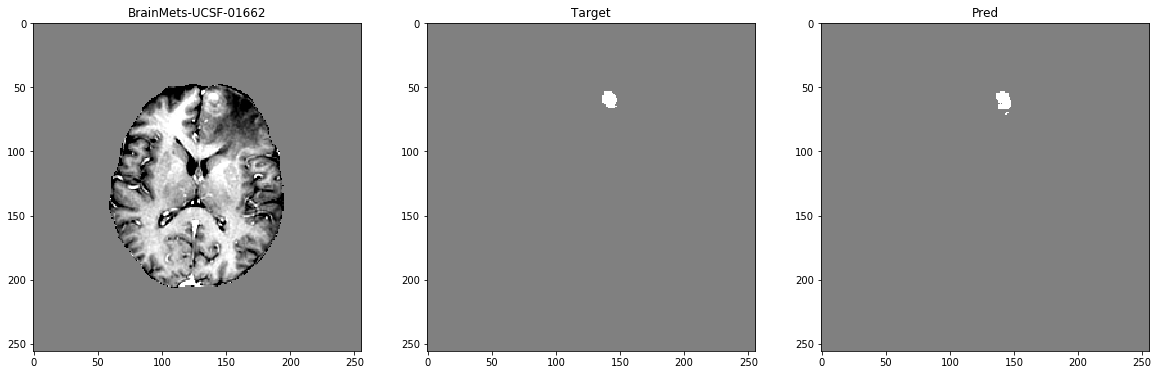

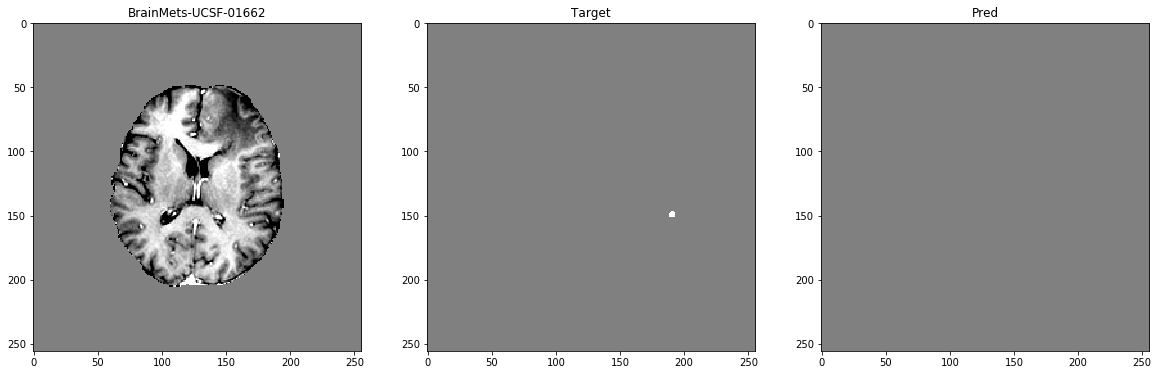

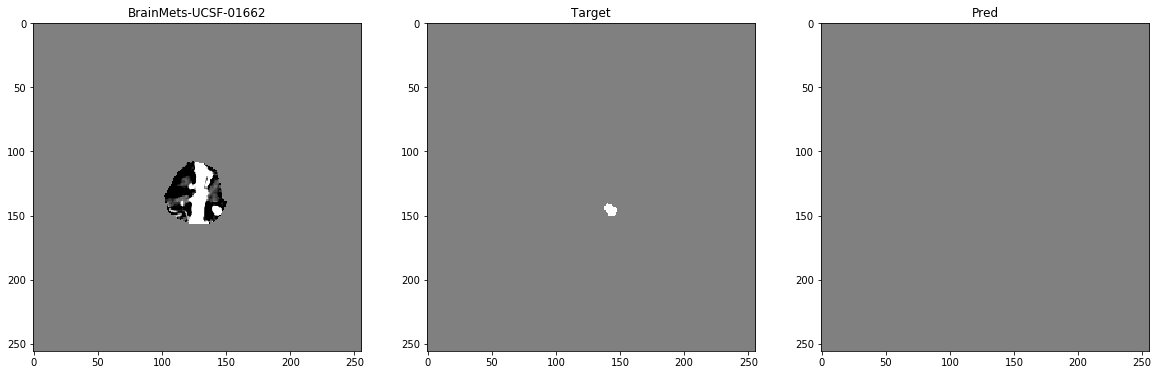

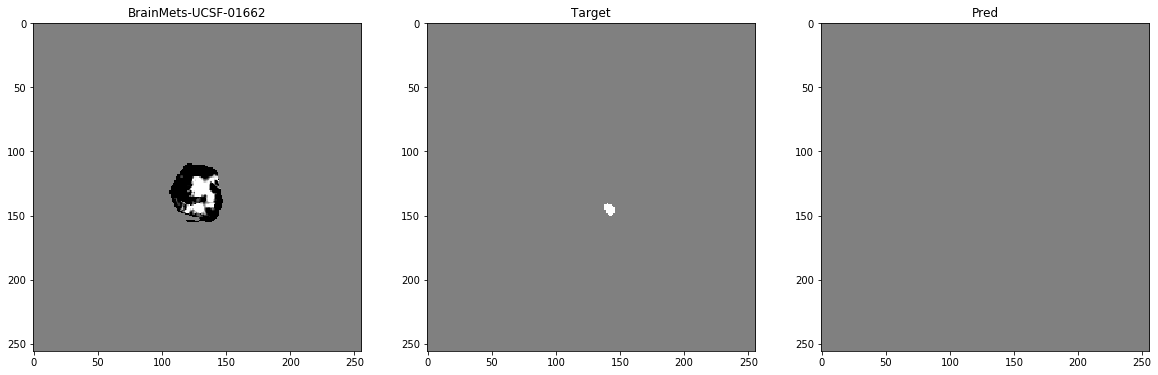

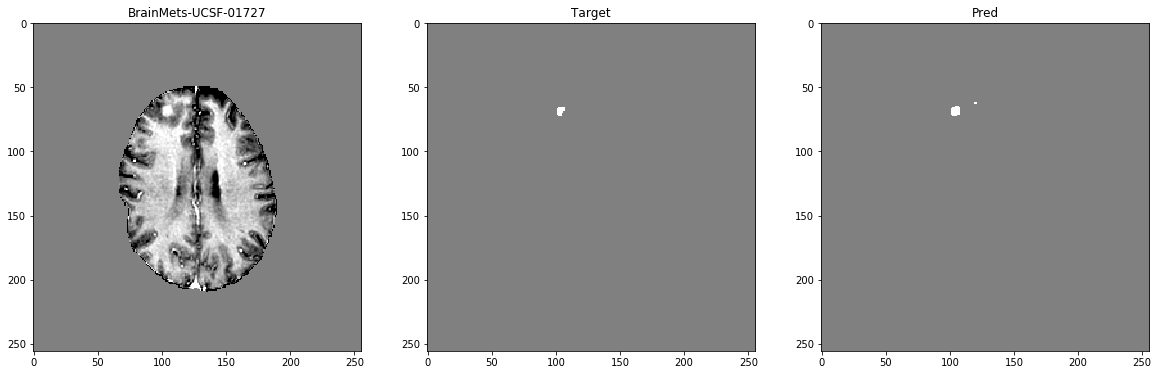

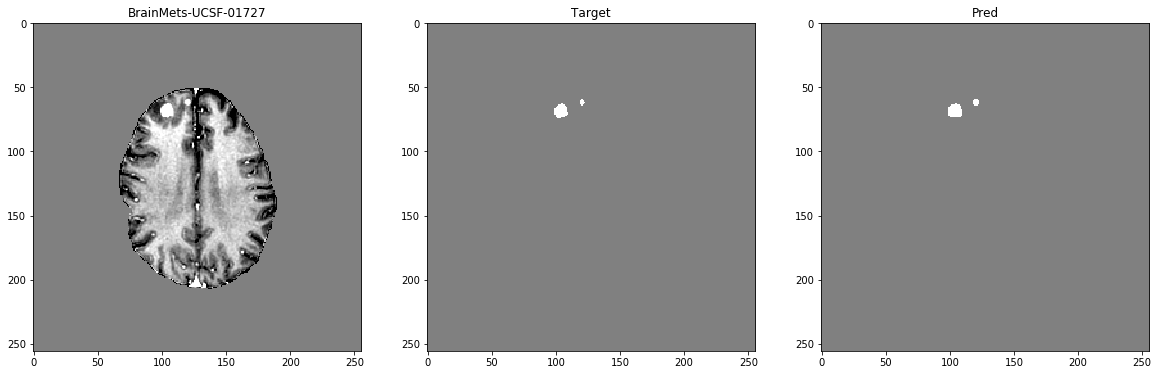

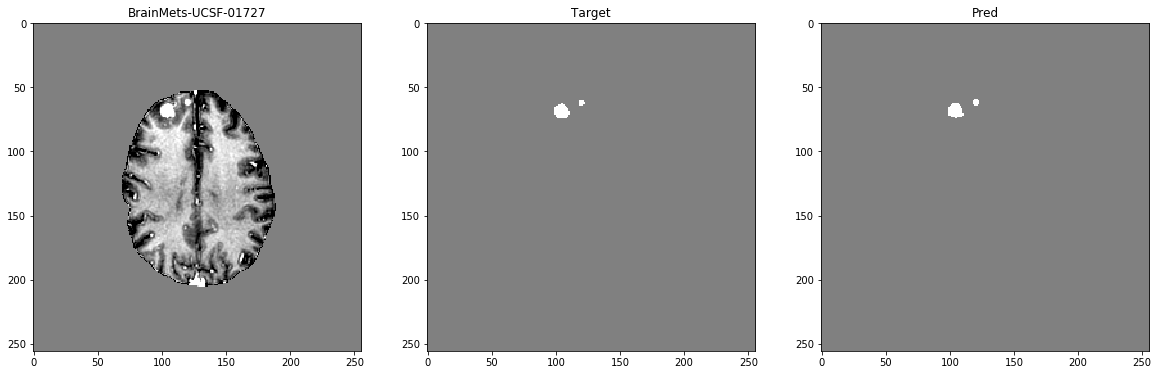

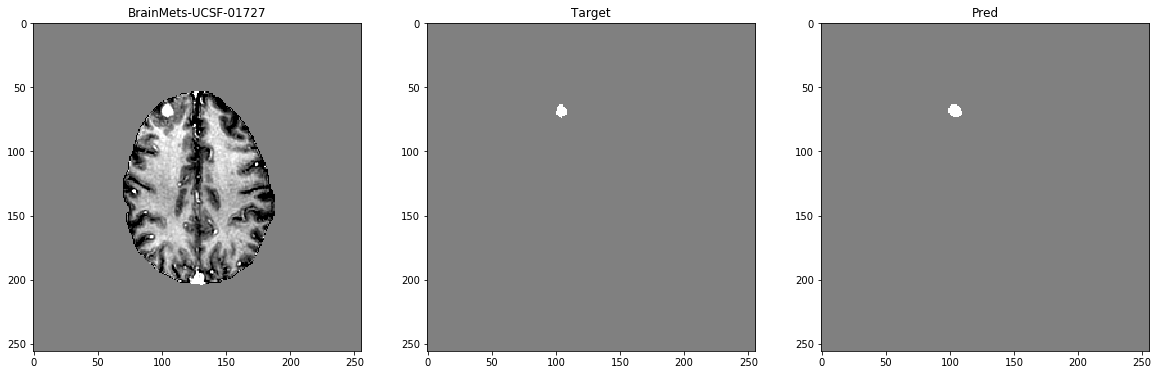

In [17]:
for i in indexes:
    for s in range(1,64):
        if sum(sum(test_masks[i][s,:,:])):
            fig = plt.figure(figsize=(20, 30))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title(names[i])
            plt.subplot(1, 3, 2)
            plt.imshow(test_masks[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title('Target')
            plt.subplot(1, 3, 3)
            plt.imshow(test_preds[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title('Pred')
            fig.savefig(names[i] + '_' + str(s) + '.png')


In [11]:
df.describe()

pred_dice_scores  pred_percent_vol_diff  target_mets  pred_mets  \
count         93.000000              93.000000    93.000000  93.000000   
mean           0.679541              44.468732     3.236559   2.548387   
std            0.282423             100.996918     1.322036   1.598342   
min            0.000000               0.000000     2.000000   0.000000   
25%            0.580995               8.067542     3.000000   1.000000   
50%            0.811321              15.170279     3.000000   2.000000   
75%            0.867497              33.398821     3.000000   3.000000   
max            0.935504             620.312500    14.000000   8.000000   

       true_positive  false_positive  
count      93.000000       93.000000  
mean     1088.892473      506.290323  
std      1295.225870     1282.375289  
min         0.000000        8.000000  
25%       144.000000       55.000000  
50%       685.000000      158.000000  
75%      1392.000000      395.000000  
max      4730.000000     8570.000000